In [1]:
from model_functions import *
from param_functions import *
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from IPython import display as ipd
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
import string

mpl.rcParams['figure.dpi'] = 400

# %matplotlib qt

In [14]:
(cs_areas['219'][0]+cs_areas['219'][2])*fridge_ours['lengths'][2]*(
    therm_cond_coaxco['219-SS-SS'](4)*9 +
    therm_cond_coaxco['219-CuNi-CuNi'](4)*19 +
    therm_cond_coaxco['219-AgCuNi-CuNi'](4)*4
)

7.367999999999999e-06

--------------

## Passive Along Cable

In [ ]:
therm_scheme_drive = [[False, True, False, True, True], #inner
                  [False, True, False, True, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_flux = [[False, True, False, False, True], #inner
                  [False, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_output = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [ ]:
c_drive = '219-SS-SS'
c_flux = '219-SS-SS'

p_drive = passive_load(stage_labels=fridge_ours['labels'], 
        diameters=coax_co_params[c_drive]['d'],
        lengths=fridge_ours['lengths'],
        therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
        therm_scheme=therm_scheme_drive,
        stage_temps=fridge_ours['temps'])

p_flux = passive_load(stage_labels=fridge_ours['labels'], 
        diameters=coax_co_params[c_flux]['d'],
        lengths=fridge_ours['lengths'],
        therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
        therm_scheme=therm_scheme_flux,
        stage_temps=fridge_ours['temps'])

p_tot = (p_drive + p_flux)/2

a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
        signal_p=1e-3*10**(-5/10), 
        signal_f=6, 
        att=[0, 20, 0, 20, 20],
        cable_att=coax_co_params[c_drive]['att_4'],
        lengths=fridge_ours['lengths'])

a_dc = active_load_DC(i_in=20e-3, 
                stage_labels=fridge_ours['labels'], 
                att=[0, 20, 0, 0, 0], 
                cable_rho=coax_co_params[c_flux]['rho'], 
                lengths=fridge_ours['lengths'], 
                diameters=coax_co_params[c_flux]['d'])

In [ ]:
display(p_tot, a_ac, a_dc)

In [ ]:
fig, ax = plt.subplots(figsize=(4.2/1.5, 10.6/1.5))

ax.barh([4*i+2 for i in range(5, 0, -1)], p_tot.values, height=1, color='navy')
ax.barh([4*i+1 for i in range(5, 0, -1)], a_ac.values*0.33, height=1, color='blue')
ax.barh([4*i for i in range(5, 0, -1)], a_dc.values, height=1, color='royalblue')

ax.set_xlim((1e-10, 10))
ax.set_xscale('log')

# ax.set_xticks([10**i for i in range(-9, 1)], minor=True)
ax.set_xticks([10**i for i in range(-9, 1, 3)], minor=False)
ax.set_xticks([10**i for i in range(-9, 1)], minor=True)
ax.tick_params(which='minor', labelsize=0.0)
ax.tick_params(which='minor', labelcolor='white')
ax.set_xlabel("Heat Dumped on Stage\nPer Line (W)")
ax.grid(True, 'major', 'x', linewidth=1, alpha=0.6)
ax.grid(True, 'minor', 'x', linewidth=0.5, alpha=0.6)

ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([10**i for i in range(-9, 1, 3)], minor=False)
ax2.set_xticks([10**i for i in range(-9, 1)], minor=True)
ax2.tick_params(which='minor', labelsize=0.0)
ax2.tick_params(which='minor', labelcolor='white')

ax.invert_xaxis()
ax2.invert_xaxis()
ax.set_yticks([])
# ax.legend(['Heat Conduction', 'Signal Absorption (AC)', 'Signal Absorption (DC)'])
fig.set_tight_layout(True)

plt.savefig('Poster Heat1.png', transparent=True)

plt.show()

In [ ]:
ax.set_minor_locator

In [ ]:
c_p = np.array(fridge_ours['cool_p'])
load_matrix_SS = pd.DataFrame(
    [p_drive*14/c_p, p_flux*14/c_p, p_out*4/c_p, a_ac*14*0.33/c_p, a_dc*14*1/c_p], 
    index=['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)']
)
load_matrix_SS

## Noise Alongside Cable

In [2]:
h = 6.626e-34
k_B = 1.381e-23
Planck = lambda T, f: h*f / ( np.exp( h*f / (k_B*T) ) - 1 )

f = np.logspace(2, 16, 400)
A = [0, 20, 0, 20, 20]

n_in    = [Planck(300, f)]
n_from  = [Planck(t, f) for t in fridge_ours['temps']]

for i in range(5):
    n_in.append(
        n_in[i] * 10**(-A[i]/10) + (1-10**(-A[i]/10)) * n_from[i]
    )

C:\Users\Adrien\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
# Just noise spectrum

# fig, axs = plt.subplots(5, 1, sharex=True, figsize=(4.2, 10.6))
fig, axs = plt.subplots(5, 1, sharex=True, figsize=(4.2/1.4, 10.6/1.4))
axs2 = [ax.twinx() for ax in axs]

for i in range(5):
    axs[i].plot(f, n_in[i], lw=2.5, c='navy')
    axs[i].plot(f, n_from[i], lw=2.5, c='blueviolet')
    axs[i].plot(f, n_in[i+1], lw=2.5, c='royalblue')
        
    axs[i].set_yscale('log')
    axs[i].set_ylim((1e-27, 1e-19))
    # axs[i].set_yticks(np.logspace(-24, -21, 6))
    axs[i].grid(True, 'both', 'x')

    axs[i].axvline(5e9, 0, 1, alpha=0.4, c='mediumslateblue', lw=7)

    axs2[i].set_yscale('log')
    axs2[i].set_ylim((1e-27, 1e-19))
    axs2[i].set_yticks([1e-27, 1e-23, 1e-19], minor=False)
    axs2[i].set_yticks([1e-25, 1e-21], minor=True)
    axs2[i].tick_params(which='minor', labelsize=0.0)
    axs2[i].tick_params(which='minor', labelcolor='white')
    axs2[i].grid(True, 'both', 'y', alpha=0.6)
    axs[i].set_yticks([])

axs[-1].set_xscale('log')
axs[-1].set_xlim((10**(7.5), 10**(14.5)))
axs[-1].set_xticks([10**i for i in [8, 11, 14]], minor=False)
axs[-1].set_xticks([10**i for i in range(8, 15)], minor=True)
axs[-1].tick_params(which='minor', labelsize=0.0)
axs[-1].tick_params(which='minor', labelcolor='white')

ax2 = axs[0].twiny()
ax2.set_xscale('log')
ax2.set_xlim((10**(7.5), 10**(14.5)))
ax2.set_xticks([10**i for i in [8, 11, 14]], minor=False)
ax2.set_xticks([10**i for i in range(8, 15)], minor=True)
ax2.tick_params(which='minor', labelsize=0.0)
ax2.tick_params(which='minor', labelcolor='white')

axs[-1].set_xlabel('Frequency (Hz)')
fig.set_tight_layout(True)

# axs2[2].set_ylabel('Noise Power (W/Hz)')

# plt.savefig('Poster Noise1.png', transparent=True)

plt.show()

## Cable Type Outcome

In [2]:
therm_scheme_drive = [[False, True, False, True, True], #inner
                  [False, True, False, True, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_flux = [[False, True, False, False, True], #inner
                  [False, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_output = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [3]:
att = np.array([0, 20, 0, 20, 20]) #+ coax_co_params[c_drive]['att_4'] * np.array(fridge_ours['lengths'])
total_att = np.sum(att)
p_in = 1e-3*10**((total_att-75)/10)
p = [p_in]
for i in range(1, 5):
    p.append(p[i-1]*10**(-att[i-1]/10))
10*np.log10(p[-1]/1e-3)

-55.0

In [6]:
(1 - 10**(-att/10)) * np.array(p)

array([0.00000000e+00, 3.13065488e-05, 0.00000000e+00, 3.13065488e-07,
       3.13065488e-09])

In [10]:
cables = ['119-SS-SS', '119-CuNi-CuNi', '219-SS-SS', '219-CuNi-CuNi', '119-NbTi-NbTi', '219-NbTi-NbTi']

c_p = np.array(fridge_ours['cool_p'])

load_matrices = []
op_temps = []
att_loads = []

for c in cables:

    c_drive = c
    c_flux = c
    c_out_upper = '119-AgCuNi-CuNi'
    c_out_lower = '119-NbTi-NbTi'

    p_drive = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_drive]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
            therm_scheme=therm_scheme_drive,
            stage_temps=fridge_ours['temps'])

    p_flux = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_flux]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
            therm_scheme=therm_scheme_flux,
            stage_temps=fridge_ours['temps'])

    att = np.array([0, 20, 0, 20, 20])
    c_att = coax_co_params[c_drive]['att_4'](6) * np.array(fridge_ours['lengths'])
    total_att = np.sum(att + c_att)

    p_in = 1e-3*10**((total_att-75)/10)
    print(p_in)

    p = [p_in]
    for i in range(1, 5):
        p.append(p[i-1]*10**(-(att+c_att)[i-1]/10))

    a_ac = np.array(p) * (1 - 10**(-c_att/10))
    a_ac = pd.Series(a_ac, index=fridge_ours['labels'])
    att_loads.append(np.array(p) * (1 - 10**(-att/10)))

    cable_rho = coax_co_params[c_flux]['rho'] 
    lengths = fridge_ours['lengths']
    diameters = coax_co_params[c_flux]['d']
    A_inner = np.pi*(diameters[0]/2)**2

    R_CP =  (
        0.42
        * (cable_rho / 7.2e-7)
        * (lengths[-2]/0.17)
        * (np.pi*(0.511e-3/2)**2 / A_inner)
    )
    R_MXC =  (
        0.15
        * (cable_rho / 7.2e-7)
        * (lengths[-1]/0.14)
        * (np.pi*(0.511e-3/2)**2 / A_inner)
    )

    R_eff = [0, 0, 0, R_CP, R_MXC]
    I = [0.02, 0.02, 0.002, 0.002, 0.002]
    a_dc = np.array(I)**2 * np.array(R_eff)
    a_dc = pd.Series(a_dc, index=fridge_ours['labels'])

    c_p = np.array(fridge_ours['cool_p'])
    load_matrix = pd.DataFrame(
    [p_drive*14/c_p, p_flux*14/c_p, a_ac*14*0.33/c_p, a_dc*14*1/c_p], 
    index=['Passive (Drive)', 'Passive (Flux)', 'Active (Drive)', 'Active (Flux)']
    )
    load_matrices.append(load_matrix)
    
#     total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

#     total.iloc[0] = t_stages[0](total.iloc[0])
#     total.iloc[1] = t_stages[1](total.iloc[1])
#     total.iloc[2] = 0
#     total.iloc[3] = t_stages[2](total.iloc[3])
#     total.iloc[4] = t_stages[3](total.iloc[4])

#     op_temps.append(total)
    

0.0007977558544281451
0.000534035342965006
0.00019692914711043615
0.00015390048908812284
3.1622776601683795e-05
3.1622776601683795e-05


In [5]:
att_loads

[array([0.00000000e+00, 4.28320829e-04, 0.00000000e+00, 8.21310159e-07,
        5.56682020e-09]),
 array([0.00000000e+00, 3.09392082e-04, 0.00000000e+00, 7.28496039e-07,
        5.18235542e-09]),
 array([0.00000000e+00, 1.37840613e-04, 0.00000000e+00, 5.40718458e-07,
        4.33781668e-09]),
 array([0.00000000e+00, 1.12876412e-04, 0.00000000e+00, 5.02318525e-07,
        4.15125292e-09]),
 array([0.00000000e+00, 3.13065488e-05, 0.00000000e+00, 3.13065488e-07,
        3.13065488e-09]),
 array([0.00000000e+00, 3.13065488e-05, 0.00000000e+00, 3.13065488e-07,
        3.13065488e-09])]

In [6]:
10*np.log10(p_in/1e-3)

-15.0

In [11]:
c_att

array([0., 0., 0., 0., 0.])

In [10]:
10*np.log10(np.array(p)/1e-3)

array([-15., -15., -35., -35., -55.])

In [6]:
[i for i in range(4)]

[0, 1, 2, 3]

In [11]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
dgrm_width = 0.25

heights = [0.66, 0.66, 1, 1, 1]
widths = [1, 1]
gs = fig.add_gridspec(5, 2, height_ratios=heights, width_ratios=widths)

axs = [fig.add_subplot(gs[row, 0]) for row in range(5)]

colour = ['red', 'orange', 'green', 'blue']
#iterate cable type
for cable in range(4):
    #iterate stage
    for stage in range(5):
        #iterate load type
        axs[stage].barh(3/8+cable*1.5, load_matrices[cable].iloc[:, stage].sum(), height=1, color='dodgerblue', alpha=0.5)
        for load in range(4):
            val = load_matrices[cable].iloc[load, stage]
            axs[stage].barh(cable*1.5 + load*0.25, val, height=0.25, color=colour[load])

for cable in [4, 5]:
    #iterate stage
    for stage in [2, 3, 4]:
        #iterate load type
        axs[stage].barh(3/8+cable*1.5, load_matrices[cable].iloc[:, stage].sum(), height=1, color='dodgerblue', alpha=0.5)
        for load in range(4):
            val = load_matrices[cable].iloc[load, stage]
            axs[stage].barh(cable*1.5 + load*0.25, val, height=0.25, color=colour[load])

for i in range(5):
    axs[i].set_xscale('log')
    axs[i].set_xlim(2e-5, 3e0)
    axs[i].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
    axs[i].grid(True, 'major', 'x', alpha=0.5)
    ii = 4 if i < 2 else 6
    axs[i].set_yticks([3/8+iii*1.5 for iii in range(ii)])
    axs[i].set_yticklabels(cables[:ii])

for i in range(4): axs[i].set_xticklabels([])

axs[-1].set_xlabel(r'Heat Load from Cable, $P/P_{cooling}$')
l = axs[2].legend([str(i) for i in range(5)], loc=(1.02, 0.13))
axs[2].legend(l.legendHandles[::-1], ['Total Heat Load', 'Passive (Drive)', 'Passive (Flux)', 'Active (Drive)', 'Active (Flux)'][::-1])

axs2 = [fig.add_subplot(gs[row, 1]) for row in range(5)]

colour = ['red', 'orange', 'green', 'blue']
#iterate cable type
for cable in range(4):
    #iterate stage
    for stage in range(5):
        #iterate load type
        axs2[stage].barh(1/8+cable*1.5, load_matrices[cable].iloc[[0, 2], stage].sum(), height=0.5, color='lightcoral')
        axs2[stage].barh(5/8+cable*1.5, load_matrices[cable].iloc[[1, 3], stage].sum(), height=0.5, color='mediumslateblue')

for cable in [4, 5]:
    #iterate stage
    for stage in [2, 3, 4]:
        #iterate load type
        axs2[stage].barh(1/8+cable*1.5, load_matrices[cable].iloc[[0, 2], stage].sum(), height=0.5, color='lightcoral')
        axs2[stage].barh(5/8+cable*1.5, load_matrices[cable].iloc[[1, 3], stage].sum(), height=0.5, color='mediumslateblue')

for i in range(5):
    axs2[i].set_xscale('log')
    axs2[i].set_xlim(2e-5, 3e0)
    axs2[i].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
    axs2[i].grid(True, 'major', 'x', alpha=0.5)
    ii = 4 if i < 2 else 6
    axs2[i].set_yticks([3/8+iii*1.5 for iii in range(ii)])
    axs2[i].set_yticklabels([])

for i in range(4): axs2[i].set_xticklabels([])

axs2[-1].set_xlabel(r'Heat Load from Cable, $P/P_{cooling}$')
l = axs2[2].legend([str(i) for i in range(2)], loc=(1.02, 0.13))
axs2[2].legend(l.legendHandles[::-1], ['Drive Line Heat Load', 'Flux Line Heat Load'][::-1])

for n, ax in enumerate(axs):
    ax.text(-0.05, 1.02, string.ascii_lowercase[n]+')', 
    transform=ax.transAxes, 
    size=12, weight='bold')

for n, ax in enumerate(axs2):
    ax.text(-0.05, 1.02, string.ascii_lowercase[n+5]+')', 
    transform=ax.transAxes, 
    size=12, weight='bold')

# plt.savefig('21.11.03/Cable Outcomes.png')

plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 9), tight_layout=True)
dgrm_width = 0.25

heights = [1, 1, 1, 1, 1]
widths = [1, 1]
gs = fig.add_gridspec(5, 2, height_ratios=heights, width_ratios=widths)

axs = [fig.add_subplot(gs[row, 0]) for row in range(5)]

colour = ['red', 'orange', 'green', 'blue']
#iterate cable type
for cable in range(4):
    #iterate stage
    for stage in range(5):
        #iterate load type
        axs[stage].barh(3/8+cable*1.5, load_matrices[cable].iloc[:, stage].sum(), height=1, color='dodgerblue', alpha=0.5)
        for load in range(4):
            val = load_matrices[cable].iloc[load, stage]
            axs[stage].barh(cable*1.5 + load*0.25, val, height=0.25, color=colour[load])

for ax in axs:
    ax.set_xscale('log')
    ax.set_xlim(2e-5, 3e0)
    ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
    ax.grid(True, 'major', 'x', alpha=0.5)
    ax.set_yticks([3/8+i*1.5 for i in range(4)])
    ax.set_yticklabels(['119-SS-SS', '119-CuNi-CuNi', '219-SS-SS', '219-CuNi-CuNi'])

for i in range(4): axs[i].set_xticklabels([])

axs[-1].set_xlabel(r'Heat Load from Cable, $P/P_{cooling}$')
l = axs[2].legend([str(i) for i in range(5)], loc=(1.02, 0.13))
axs[2].legend(l.legendHandles[::-1], ['Total Heat Load', 'Passive (Drive)', 'Passive (Flux)', 'Active (Drive)', 'Active (Flux)'][::-1])

axs2 = [fig.add_subplot(gs[row, 1]) for row in range(5)]

colour = ['red', 'orange', 'green', 'blue']
#iterate cable type
for cable in range(4):
    #iterate stage
    for stage in range(5):
        #iterate load type
        axs2[stage].barh(1/8+cable*1.5, load_matrices[cable].iloc[[0, 2], stage].sum(), height=0.5, color='lightcoral')
        axs2[stage].barh(5/8+cable*1.5, load_matrices[cable].iloc[[1, 3], stage].sum(), height=0.5, color='mediumslateblue')

for ax in axs2:
    ax.set_xscale('log')
    ax.set_xlim(2e-5, 3e0)
    ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
    ax.grid(True, 'major', 'x', alpha=0.5)
    ax.set_yticks([3/8+i*1.5 for i in range(4)])
    ax.set_yticklabels([])

for i in range(4): axs2[i].set_xticklabels([])

axs2[-1].set_xlabel(r'Heat Load from Cable, $P/P_{cooling}$')
l = axs2[2].legend([str(i) for i in range(2)], loc=(1.02, 0.13))
axs2[2].legend(l.legendHandles[::-1], ['Drive Line Heat Load', 'Flux Line Heat Load'][::-1])

plt.savefig('21.10.14/Cable Outcomes2.png')

plt.show()

In [24]:
load_matrices[0]

,50K,4K,Still,CP,MXC
Passive (Drive),0.007422,0.012155,0.000311,0.010104,0.001145
Passive (Flux),0.007422,0.012155,0.000311,0.006567,0.036557
Active (Drive),0.000169,0.004295,0.000664,0.039584,0.008065
Active (Flux),0.000000,0.000000,0.000000,0.219299,2.111311


In [ ]:
cables = ['119-SS-SS', '119-CuNi-CuNi', '219-SS-SS', '219-CuNi-CuNi']

c_p = np.array(fridge_ours['cool_p'])

load_matrices = []
op_temps = []

for c in cables:

    c_drive = c
    c_flux = c
    c_out_upper = '119-AgCuNi-CuNi'
    c_out_lower = '119-NbTi-NbTi'

    p_drive = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_drive]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
            therm_scheme=therm_scheme_drive,
            stage_temps=fridge_ours['temps'])

    p_flux = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_flux]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
            therm_scheme=therm_scheme_flux,
            stage_temps=fridge_ours['temps'])

    p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
            diameters=coax_co_params[c_out_lower]['d'],
            lengths=fridge_100q['lengths'],
            therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_out_upper]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out = p_out_upper[0:2].append(p_out_lower[2:])

    a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
            signal_p=1e-3*10**(-5/10), 
            signal_f=6, 
            att=[0, 20, 0, 20, 20],
            cable_att=coax_co_params[c_drive]['att_4'],
            lengths=fridge_ours['lengths'])

    a_dc = active_load_DC(i_in=20e-3, 
                    stage_labels=fridge_ours['labels'], 
                    att=[0, 20, 0, 0, 0], 
                    cable_rho=coax_co_params[c_flux]['rho'], 
                    lengths=fridge_ours['lengths'], 
                    diameters=coax_co_params[c_flux]['d'])

    c_p = np.array(fridge_ours['cool_p'])
    load_matrix = pd.DataFrame(
    [p_drive*14/c_p, p_flux*14/c_p, p_out*4/c_p, a_ac*14*0.33/c_p, a_dc*14*1/c_p], 
    index=['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)']
    )
    load_matrices.append(load_matrix)
    
    total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

    total.iloc[0] = t_stages[0](total.iloc[0])
    total.iloc[1] = t_stages[1](total.iloc[1])
    total.iloc[2] = 0
    total.iloc[3] = t_stages[2](total.iloc[3])
    total.iloc[4] = t_stages[3](total.iloc[4])

    op_temps.append(total)

In [ ]:
load_matrices[1]

In [ ]:
op_temps_format = pd.DataFrame(op_temps, index=cables).iloc[:, [0, 1, 3, 4]]
op_temps_format

### Horizontally

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
colour = ['red', 'orange', 'yellowgreen', 'green', 'blue']

#iterate cable type
for cable in range(4):
    #iterate stage
    for stage in range(5):
        bot = 0
        #iterate load type
        for load in range(5):
            val = load_matrices[cable].iloc[load, stage]
            axs[stage].bar(cable, val, width=1, bottom=bot, color=colour[load])
            bot += val

        axs[stage].set_title(fridge_ours['labels'][stage])
        axs[stage].set_xlim(-1, 4)
        # axs[stage].set_ylim(0, 2.5)

        axs[stage].set_xticks([0, 1, 2, 3])
        axs[stage].set_xticklabels(['1.19mm SS', '1.19mm CuNi', '2.19mm SS', '2.19mm CuNi'], rotation=90)

axs[0].set_ylabel(r'Heat Load, $P_{total}/P_{cooling}$')
axs[2].set_xlabel('Cable Type')
axs[-1].legend(['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'], loc=(1.05, 0.65))
fig.set_tight_layout(True)
plt.show()

In [ ]:
temps = [50, 4, 0.150, 0.020]
t_str = ['50K', '4K', '150mK', '20mK']

fig, axs = plt.subplots(1, 4, figsize=(12, 5))

for i in range(4):
    axs[i].bar([1, 2, 3, 4], op_temps_format.iloc[:, i].values, width=1, color=['silver', 'goldenrod', 'grey', 'darkgoldenrod'])
    
    y_max = np.max([temps[i]*1.25, np.max(op_temps_format.iloc[:, i].values)*1.05])

    axs[i].set_xlim(-0.5, 5.5)
    axs[i].set_ylim(0, y_max)

    axs[i].set_xticks([1, 2, 3, 4])
    axs[i].set_xticklabels(['1.19mm SS', '1.19mm CuNi', '2.19mm SS', '2.19mm CuNi'], rotation=90)
    # axs[i].set_yticks([0])

    axs[i].axhline(temps[i], 0.083, 0.92, ls='--', lw=1, c='r')
    axs[i].annotate(t_str[i], (3.2, temps[i]*1.01), color='red', fontsize=8)
    
    axs[i].set_title(fridge_ours['labels'][i if i<2 else i+1])
    axs[i].set_xlabel("Cable Type")

fig.set_tight_layout(True)

axs[0].set_ylabel('Operating Temperature (K)')

plt.show()

### Vertically

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(5, 15))
colour = ['red', 'orange', 'yellowgreen', 'green', 'blue']

#iterate cable type
for cable in range(4):
    #iterate stage
    for stage in range(5):
        bot = 0
        #iterate load type
        for load in range(5):
            val = load_matrices[cable].iloc[load, stage]
            axs[stage].barh(cable, val, height=1, left=bot, color=colour[load])
            bot += val

        # axs[stage].set_title(fridge_ours['labels'][stage])
        axs[stage].set_ylim(-1, 4)
        # axs[stage].set_ylim(0, 2.5)

        axs[stage].set_yticks([0, 1, 2, 3])
        axs[stage].set_yticklabels(['1.19mm SS', '1.19mm CuNi', '2.19mm SS', '2.19mm CuNi'])

        axs[stage].invert_xaxis()

axs[-1].set_xlabel(r'Heat Load, $P_{total}/P_{cooling}$')
# axs[2].set_ylabel('Cable Type')
# axs[-1].legend(['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'], loc=(1.05, 0.65))
fig.set_tight_layout(True)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 4), tight_layout=True)

widths = [1, 1.5, 1]
gs = fig.add_gridspec(5, 3, width_ratios=widths)

P_axs = [fig.add_subplot(gs[row, 0]) for row in range(5)]
# T_axs =
[fig.add_subplot(gs[0, col]) for col in range(3)]

######

dgrm = plt.imread("Picture2.png")
print(dgrm.shape)
axs[1].imshow(dgrm)



plt.show()

## Cable Type - Output Lines

In [2]:
therm_scheme_output = [[False, True, False, False, True], #inner
                  [False, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [3]:
c_p = np.array(fridge_ours['cool_p'])

cables = ['119-AgSS-SS', '119-AgCuNi-CuNi', '219-AgSS-SS', '219-AgCuNi-CuNi']
heat_data_upper = []
att_data_upper = []

for c in cables:

    c_out_upper = c
    
    p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_out_upper]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    heat_data_upper.append((p_out_upper*4/c_p)[0:2])
    att_data_upper.append(coax_co_params[c_out_upper]['att_4'](6) * np.array(fridge_ours['lengths'][0:2]))

cables = ['119-NbTi-NbTi', '219-NbTi-NbTi']
heat_data_lower = []
att_data_lower = []

for i in range(2):

    c_out_lower = cables[i]
    
    p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
            diameters=coax_co_params[c_out_lower]['d'],
            lengths=fridge_100q['lengths'],
            therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    heat_data_lower.append((p_out_lower*4/c_p)[2:])
    att_data_lower.append([0.4, 0.3][i] * np.array(fridge_ours['lengths'][2:]))

In [14]:
fig = plt.figure(figsize=(10, 6), tight_layout=True)
dgrm_width = 0.25

heights = [1, 1, 0.5, 0.5, 0.5]
widths = [1, 1]
gs = fig.add_gridspec(5, 2, height_ratios=heights, width_ratios=widths)

axs = [fig.add_subplot(gs[row, 0]) for row in range(5)]

#iterate cable type
for cable in range(4):
    #iterate stage
    for stage in range(2):
        #iterate load type
        axs[stage].barh(cable*1.5, heat_data_upper[cable].iloc[stage], height=1, color='red')

for cable in range(2):
    #iterate stage
    for stage in range(3):
        #iterate load type
        axs[stage+2].barh(cable*1.5, heat_data_lower[cable].iloc[stage], height=1, color='red')

for ax in axs:
    ax.set_xscale('log')
    ax.set_xlim(2e-5, 8e-2)
    ax.set_xticks([1e-4, 1e-3, 1e-2])
    ax.grid(True, 'major', 'x', alpha=0.5)
    # ax.set_yticks([3/8+i*1.5 for i in range(4)])
    # ax.set_yticklabels(['119-SS-SS', '119-CuNi-CuNi', '219-SS-SS', '219-CuNi-CuNi'])

for i in range(4): axs[i].set_xticklabels([])

for i in range(2):
    axs[i].set_yticks([i*1.5 for i in range(4)])
    axs[i].set_yticklabels(['119-AgSS-SS', '119-AgCuNi-CuNi', '219-AgSS-SS', '219-AgCuNi-CuNi'])

for i in range(3):
    axs[i+2].set_yticks([0, 1.5])
    axs[i+2].set_yticklabels(['119-NbTi-NbTi', '219-NbTi-NbTi'])


axs2 = [fig.add_subplot(gs[row, 1]) for row in range(5)]

for cable in range(4):
    #iterate stage
    for stage in range(2):
        #iterate load type
        axs2[stage].barh(cable*1.5, att_data_upper[cable][stage], height=1, color='blue')

for cable in range(2):
    #iterate stage
    for stage in range(3):
        #iterate load type
        axs2[stage+2].barh(cable*1.5, att_data_lower[cable][stage], height=1, color='blue')

for ax in axs2:
    # ax.set_xscale('log')
    ax.set_xlim(0, 1)
    # ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
    # ax.grid(True, 'major', 'x', alpha=0.5)
    # ax.set_yticks([3/8+i*1.5 for i in range(4)])
    # ax.set_yticklabels([])

for i in range(4): axs2[i].set_xticklabels([])

for i in range(2):
    axs2[i].set_yticks([i*1.5 for i in range(4)])
    axs2[i].set_yticklabels([])

for i in range(3):
    axs2[i+2].set_yticks([0, 1.5])
    axs2[i+2].set_yticklabels([])

att2T = lambda a: 10**(-a/10)
axtop = axs2[0].twiny()
axtop.set_xscale('log')
axtop.set_xlim(att2T(np.array(axs2[0].get_xlim())))
axtop.set_xticks([1, 0.95, 0.9, 0.85, 0.8])
axtop.set_xticklabels([str(i) for i in axtop.get_xticks()])
axtop.set_xlabel(r'Transmission through Cable Section, $T$')

axs[-1].set_xlabel(r'Passive Load, $P/P_{cooling}$')
axs2[-1].set_xlabel(r'Attenuation of Cable Section (dB)')

plt.savefig('21.10.19/Cable Outcomes Output.png')

plt.show()

## Attenuation Config Comparison

In [2]:
def config2therm(config):
    therm = [[not (a < 0.001) for a in config]]*2 + [[True, True, True, True, True]]
    return therm

In [3]:
therm_scheme_flux = [[False, True, False, False, True], #inner
                  [False, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_output = [[False, True, False, False, True], #inner
                  [False, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [ ]:
configs = [
    [0, 0, 0, 0, 60],
    [0, 0, 0, 10, 50],
    [0, 0, 0, 20, 40],
    [0, 10, 0, 0, 50],
    [0, 20, 0, 0, 40],
    [0, 10, 0, 10, 40],
    [0, 10, 0, 20, 30],
    [0, 20, 0, 10, 30],
    [0, 20, 0, 20, 20],
    [10, 10, 0, 10, 30],
    [5, 5, 0, 20, 30],
    [10, 10, 0, 20, 20],
]

heat_data = []
temp_data = []

for conf in configs:

    therm_scheme_drive = config2therm(conf)

    c_drive = '219-CuNi-CuNi'
    c_flux = '219-CuNi-CuNi'
    c_out_upper = '119-AgCuNi-CuNi'
    c_out_lower = '119-NbTi-NbTi'

    p_drive = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_drive]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
            therm_scheme=therm_scheme_drive,
            stage_temps=fridge_ours['temps'])

    p_flux = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_flux]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
            therm_scheme=therm_scheme_flux,
            stage_temps=fridge_ours['temps'])

    p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
            diameters=coax_co_params[c_out_lower]['d'],
            lengths=fridge_100q['lengths'],
            therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_out_upper]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out = p_out_upper[0:2].append(p_out_lower[2:])

    a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
            signal_p=1e-3*10**(-5/10), 
            signal_f=6, 
            att=conf,
            cable_att=coax_co_params[c_drive]['att_4'],
            lengths=fridge_ours['lengths'])

    a_dc = active_load_DC(i_in=20e-3, 
                    stage_labels=fridge_ours['labels'], 
                    att=[0, 20, 0, 0, 0], 
                    cable_rho=coax_co_params[c_flux]['rho'], 
                    lengths=fridge_ours['lengths'], 
                    diameters=coax_co_params[c_flux]['d'])

    c_p = np.array(fridge_ours['cool_p'])
    load_matrix = pd.DataFrame(
    [p_drive*14/c_p, p_flux*14/c_p, p_out*4/c_p, a_ac*14*0.33/c_p, a_dc*14*1/c_p], 
    index=['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)']
    )
    heat_data.append(load_matrix.iloc[:, [0, 1, 3, 4]])
    
    total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

    total.iloc[0] = t_stages[0](total.iloc[0])
    total.iloc[1] = t_stages[1](total.iloc[1])
    total.iloc[2] = 1.227
    total.iloc[3] = t_stages[2](total.iloc[3])
    total.iloc[4] = t_stages[3](total.iloc[4])

    temp_data.append(total)

In [ ]:
temp_data_format = pd.DataFrame(temp_data) 
temp_data_format = temp_data_format.iloc[:, [0, 1, 3, 4]]

In [ ]:
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )

n_data = []

for i in range(len(configs)):
    n_bar = n_BE(300, 6e9)
    for ii in range(5):
        n_bar = n_bar * 10**(-configs[i][ii]/10) + (1-10**(-configs[i][ii]/10)) * n_BE(temp_data[i][ii], 6e9)
    n_data.append(n_bar)

In [ ]:
T_data = 1/(np.array(n_data)+1)

In [ ]:
fig = plt.figure(figsize=(15, 10), tight_layout=True)
colour = ['red', 'darkorange', 'gold', 'green', 'blue']
dgrm_width = 1

heights = [1, 1, 0.001, 1, 1, 1]
widths = [dgrm_width, 1, 1]
gs = fig.add_gridspec(6, 3, height_ratios=heights, width_ratios=widths)

######################################

axs1 = [fig.add_subplot(gs[row, 1]) for row in [0, 1, 3, 4, 5]]
letters = ['b', 'c', 'd', 'e']

#iterate stage
for stage in range(4):
    #iterate config
    for config in range(len(configs)):
        bot = 0
        #iterate load type
        for load in range(5):
            val = heat_data[config].iloc[load, stage]
            axs1[stage].bar(config*1.1, val, width=1, bottom=bot, color=colour[load])
            bot += val

    axs1[stage].set_xticks([i*1.1 for i in range(len(configs))])
    axs1[stage].set_xticklabels([])
    
    axs1[stage].yaxis.set_label_position('right')
    axs1[stage].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$')
    axs1[stage].annotate(letters[stage] + ')', (-0.05, 0.85), xycoords='axes fraction', fontweight='bold')
        

for ax in axs1: ax.yaxis.tick_right()

axs1[2].set_ylim(0, 2)
axs1[3].set_ylim(0, 5)

axs1[-1].bar([i*1.1 for i in range(len(configs))], n_data, 1, color='salmon', edgecolor='k')
axs1[-1].set_yscale('log')
axs1[-1].set_ylim(10**-3.5, 10**1.5)
axs1[-1].set_yticks([1e-3, 1e-1, 1e1])
axs1[-1].set_xticks([i*1.1 for i in range(len(configs))])
axs1[-1].set_xticklabels(['C'+ str(i+1) for i in range(len(configs))])

axs1[1].set_xticks([i*1.1 for i in range(len(configs))])
axs1[1].set_xticklabels(['C'+ str(i+1) for i in range(len(configs))])

top1 = axs1[0].twiny()
top1.set_xlim(axs1[-1].get_xlim())
top1.set_xticks(axs1[-1].get_xticks())
top1.set_xticklabels(axs1[-1].get_xticklabels())

axs1[-1].yaxis.set_label_position('right')
axs1[-1].set_ylabel('Noise Photons\nat Device\n'+r'($s^{-1}Hz^{-1}$)')
axs1[-1].set_xlabel('Configuration')
top1.set_xlabel('Configuration')

l = axs1[2].legend(['1', '2', '3', '4', '5'])
axs1[2].legend(l.legendHandles[::-1], ['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'][::-1])
axs1[-1].annotate('f)', (-0.05, 0.85), xycoords='axes fraction', fontweight='bold')

########################

axs2 = [fig.add_subplot(gs[row, 2]) for row in [0, 1, 3, 4, 5]]
letters = ['g', 'h', 'i', 'j']

for stage in range(4):
    y = temp_data_format.iloc[:, stage]
    x = [i for i in range(len(configs))]
    axs2[stage].bar(x, y, width=1, edgecolor='k', color='orchid')
    axs2[stage].set_xticks(x)
    axs2[stage].set_xticklabels([])
    axs2[stage].yaxis.set_label_position('right')
    axs2[stage].set_ylabel('Operating\nTemperature\n(K)')
    axs2[stage].annotate(letters[stage] + ')', (-0.05, 0.85), xycoords='axes fraction', fontweight='bold')

for ax in axs2: ax.yaxis.tick_right()

axs2[2].set_ylim(0, 0.2)
axs2[3].set_ylim(0, 0.05)

axs2[-1].bar([i for i in range(len(configs))], T_data, width=1, edgecolor='k', color='lightskyblue')
axs2[-1].set_ylim(0.99, 1)

axs2[-1].set_xticks([i for i in range(len(configs))])
axs2[-1].set_xticklabels(['C'+ str(i+1) for i in range(len(configs))])

axs2[-1].yaxis.set_label_position('right')
axs2[-1].set_ylabel('Estimated\nLifetime\n' + r'$T_1$, (norm.)')
axs2[-1].set_xlabel('Configuration')

axs2[1].set_xticks([i for i in range(len(configs))])
axs2[1].set_xticklabels(['C'+ str(i+1) for i in range(len(configs))])

top2 = axs2[0].twiny()
top2.set_xlim(axs2[-1].get_xlim())
top2.set_xticks(axs2[-1].get_xticks())
top2.set_xticklabels(axs2[-1].get_xticklabels())
top2.set_xlabel(axs2[-1].get_xlabel())

axs2[-1].annotate('k)', (-0.05, 0.85), xycoords='axes fraction', fontweight='bold')

plt.show()

In [ ]:
##### Plotting the dgrm
widths = [dgrm_width, 1, 1]
gs2 = fig.add_gridspec(1, 3, width_ratios=widths)
dgrm = fig.add_subplot(gs2[0, 0])

#plotting the stage and cable lines
theight = dgrm.figbox.y1 - dgrm.figbox.y0
cheights = [((ax.figbox.y1 + ax.figbox.y0) / 2 - dgrm.figbox.y0) / theight for ax in axs1]
cheights.insert(2, ((axs1[1].figbox.y0 + axs1[2].figbox.y1) / 2 - dgrm.figbox.y0) / theight)

for i in range(12): dgrm.plot([(1+2*i)/24, (1+2*i)/24], [1/5, 0.9575], lw=1, c='k')
for i in range(5): dgrm.plot([0, 1], [cheights[i], cheights[i]], lw=3, c='gold')

#Plotting the device rectangle
w, h = 0.2, 0.04
dev = mpl.patches.Rectangle((0.5-w/2, cheights[-1]-(h/2)), w, h, facecolor='blue', edgecolor='black', lw=2)
dgrm.add_patch(dev)
dgrm.annotate('Devices', (0.5, cheights[-1]), c='w', ha='center', va='center')
l = 0.05
h = dev._y1-dev._y0
for i in range(3): dgrm.plot([dev._x0-l, dev._x0], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=1, c='k')
for i in range(3): dgrm.plot([dev._x1, dev._x1+l], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=1, c='k')
for i in range(3): dgrm.plot([dev._x0-l/3, dev._x0], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=2, c='k')
for i in range(3): dgrm.plot([dev._x1, dev._x1+l/3], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=2, c='k')

#setting limits and ticks
dgrm.set_xlim(0, 1)
dgrm.set_ylim(0, 1)
dgrm.set_xticks([])
dgrm.set_yticks(cheights[:-1])
dgrm.set_yticklabels(fridge_ours['labels'])

# removing axes borders
dgrm.spines['right'].set_visible(False)
dgrm.spines['left'].set_visible(False)
dgrm.spines['top'].set_visible(False)
dgrm.spines['bottom'].set_visible(False)

# Setting Configuration labels
dgrm.set_title('Configuration')
for i in range(12): dgrm.annotate('C'+str(i+1), ((1+2*i)/24, 0.975), c='k', ha='center', va='center')
for i in range(12): dgrm.annotate('C'+str(i+1), ((1+2*i)/24, 1/5.5), c='k', ha='center', va='center')

# Plotting Attenuator Rectangles
w, h = 0.05, 0.025
for i in range(len(configs)):
    #iterating stage
    for ii in range(5):
        if configs[i][ii] > 0.001:
            atten = mpl.patches.Rectangle(((1+2*i)/24-w/2, cheights[ii]-h/2), w, h, facecolor='w', edgecolor='k', lw=1.5, zorder=10)
            dgrm.add_patch(atten)
            dgrm.annotate(str(configs[i][ii]), ((1+2*i)/24, cheights[ii]), rotation=0, fontsize=8, ha='center', va='center', zorder=11)

#add letter
dgrm.annotate('a)', (-0.1, 1.01), xycoords='axes fraction', fontweight='bold')

plt.savefig('Full Att Comparison.png', dpi=500)

plt.show()

In [ ]:
fig = plt.figure(figsize=(11, 10), tight_layout=True)
colour = ['red', 'darkorange', 'gold', 'green', 'blue']

heights = [1, 1, 0.001, 1, 1, 1]
gs = fig.add_gridspec(6, 2, height_ratios=heights)

######################################

axs1 = [fig.add_subplot(gs[row, 0]) for row in [0, 1, 3, 4, 5]]

#iterate stage
for stage in range(4):
    #iterate config
    for config in range(len(configs)):
        bot = 0
        #iterate load type
        for load in range(5):
            val = heat_data[config].iloc[load, stage]
            axs1[stage].bar(config*1.1, val, width=1, bottom=bot, color=colour[load])
            bot += val

    axs1[stage].set_xticks([i*1.1 for i in range(len(configs))])
    axs1[stage].set_xticklabels([])
    
    axs1[stage].yaxis.set_label_position('right')
    axs1[stage].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$')
        

for ax in axs1: ax.yaxis.tick_right()

axs1[2].set_ylim(0, 2)
axs1[3].set_ylim(0, 5)

axs1[-1].bar([i*1.1 for i in range(len(configs))], n_data, 1, color='salmon', edgecolor='k')
axs1[-1].set_yscale('log')
axs1[-1].set_ylim(10**-3.5, 10**1.5)
axs1[-1].set_yticks([1e-3, 1e-1, 1e1])
axs1[-1].set_xticks([i*1.1 for i in range(len(configs))])
axs1[-1].set_xticklabels(['C'+ str(i+1) for i in range(len(configs))])

axs1[1].set_xticks([i*1.1 for i in range(len(configs))])
axs1[1].set_xticklabels(['C'+ str(i+1) for i in range(len(configs))])

top1 = axs1[0].twiny()
top1.set_xlim(axs1[-1].get_xlim())
top1.set_xticks(axs1[-1].get_xticks())
top1.set_xticklabels(axs1[-1].get_xticklabels())

axs1[-1].yaxis.set_label_position('right')
axs1[-1].set_ylabel('Noise Photons\nat Device\n'+r'($s^{-1}Hz^{-1}$)')
axs1[-1].set_xlabel('Configuration')
top1.set_xlabel('Configuration')

l = axs1[2].legend(['1', '2', '3', '4', '5'])
axs1[2].legend(l.legendHandles[::-1], ['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'][::-1])

########################

axs2 = [fig.add_subplot(gs[row, 1]) for row in [0, 1, 3, 4, 5]]

for stage in range(4):
    y = temp_data_format.iloc[:, stage]
    x = [i for i in range(len(configs))]
    axs2[stage].bar(x, y, width=1, edgecolor='k', color='orchid')
    axs2[stage].set_xticks(x)
    axs2[stage].set_xticklabels([])
    axs2[stage].yaxis.set_label_position('right')
    axs2[stage].set_ylabel('Operating\nTemperature\n(K)')

for ax in axs2: ax.yaxis.tick_right()

axs2[2].set_ylim(0, 0.2)
axs2[3].set_ylim(0, 0.05)

axs2[-1].bar([i for i in range(len(configs))], T_data, width=1, edgecolor='k', color='lightskyblue')
axs2[-1].set_ylim(0.99, 1)

axs2[-1].set_xticks([i for i in range(len(configs))])
axs2[-1].set_xticklabels(['C'+ str(i+1) for i in range(len(configs))])

axs2[-1].yaxis.set_label_position('right')
axs2[-1].set_ylabel('Estimated\nLifetime\n' + r'$T_1$, (norm.)')
axs2[-1].set_xlabel('Configuration')

axs2[1].set_xticks([i for i in range(len(configs))])
axs2[1].set_xticklabels(['C'+ str(i+1) for i in range(len(configs))])

top2 = axs2[0].twiny()
top2.set_xlim(axs2[-1].get_xlim())
top2.set_xticks(axs2[-1].get_xticks())
top2.set_xticklabels(axs2[-1].get_xticklabels())
top2.set_xlabel(axs2[-1].get_xlabel())

# axs[0].set_xticklabels([])
# axs[1].set_xticklabels([])
# axs[1].set_ylim(0, 4)
# axs[2].set_yscale('log')
# axs[2].set_ylim(10**-3.5, 10**1.5)
# axs[2].set_yticks([1e1, 1e-1, 1e-3])

# axs2 = axs[0].twiny()
# axs2.set_xlim(axs[0].get_xlim())
# axs2.set_xticks([i for i in range(0, 61, 10)])
# axs2.set_xticklabels([60-i for i in range(0, 61, 10)])
# fig.text(0.22, 0.8, r"Attenuation on CP, $A_{CP}$ (dB)")

# l = axs[0].legend(['1', '2', '3', '4', '5'])
# axs[0].legend(l.legendHandles[::-1], ['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'][::-1], loc=(1.15, 0.01))
# axs[2].yaxis.set_label_position('right')
# axs[2].set_ylabel('Noise Photons\nat Device\n' + r'($s^{-1}Hz^{-1}$)')
# axs[0].yaxis.set_label_position('right')
# axs[0].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 
# axs[1].yaxis.set_label_position('right')
# axs[1].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 
# axs[2].set_xlabel(r"Attenuation on MXC, $A_{MXC}$ (dB)")

# plt.savefig('Final Att Comparison.png')

plt.show()

In [ ]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(5, 8))

for i in range(len(axs)):
    axs[i].bar([n for n in range(len(configs))], data_format.iloc[:, i], width=1, edgecolor='black')
    axs[i].set_ylabel('Operating Temp (K)')

axs[0].set_title("Operating Temperatures of\nAttenuator Configurations")

axs[-1].set_ylim(0, 0.1)
# axs[-1].annotate(str(data[0][4]), (1,6, 0.08))
axs[-1].set_xticks([n for n in range(len(configs))])
axs[-1].set_xticklabels(['C'+str(n+1) for n in range(len(configs))])
axs[-1].set_xlabel('Configuration')

fig.set_tight_layout(True)
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(6, 3))

axs.bar([n for n in range(len(configs))], T_data, width=1, edgecolor='black')

axs.set_ylim(0.99, 1)

axs.set_xticks([n for n in range(len(configs))])
axs.set_xticklabels(['C'+str(n+1) for n in range(len(configs))])

axs.set_title(r"$T_1$ Lifetimes")
axs.set_xlabel('Configuration')
axs.set_ylabel(r'T_1 lifetime (norm.)')

fig.set_tight_layout(True)
plt.show()

In [ ]:
data_format.iloc[:, 1]/0.02

## 60dB on each stage individually

In [2]:
def config2therm(config):
    therm = [[not (a < 0.001) for a in config[:-1]]+[True]]*2 + [[True, True, True, True, True]]
    return therm

therm_scheme_flux = [[False, True, False, False, True], #inner
                  [False, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_output = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [3]:
configs = [
    [60, 0, 0, 0, 0],
    [0, 60, 0, 0, 0],
    [0, 0, 60, 0, 0],
    [0, 0, 0, 60, 0],
    [0, 0, 0, 0, 60],
]

load_matrices = []
temp_data = []

for conf in configs:

    therm_scheme_drive = config2therm(conf)

    c_drive = '219-SS-SS'
    c_flux = '219-SS-SS'
    c_out_upper = '119-AgCuNi-CuNi'
    c_out_lower = '119-NbTi-NbTi'

    p_drive = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_drive]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
            therm_scheme=therm_scheme_drive,
            stage_temps=fridge_ours['temps'])

    p_flux = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_flux]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
            therm_scheme=therm_scheme_flux,
            stage_temps=fridge_ours['temps'])

    p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
            diameters=coax_co_params[c_out_lower]['d'],
            lengths=fridge_100q['lengths'],
            therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_out_upper]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out = p_out_upper[0:2].append(p_out_lower[2:])

    a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
            signal_p=1e-3*10**(-5/10), 
            signal_f=6, 
            att=conf,
            cable_att=coax_co_params[c_drive]['att_4'],
            lengths=fridge_ours['lengths'])

    a_dc = active_load_DC(i_in=20e-3, 
                    stage_labels=fridge_ours['labels'], 
                    att=[0, 20, 0, 0, 0], 
                    cable_rho=coax_co_params[c_flux]['rho'], 
                    lengths=fridge_ours['lengths'], 
                    diameters=coax_co_params[c_flux]['d'])

    c_p = np.array(fridge_ours['cool_p'])
    load_matrix = pd.DataFrame(
    [p_drive*14/c_p, p_flux*14/c_p, p_out*4/c_p, a_ac*14*0.33/c_p, a_dc*14*1/c_p], 
    index=['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)']
    )
    load_matrices.append(load_matrix)

    total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

    total.iloc[0] = t_stages[0](total.iloc[0])
    total.iloc[1] = t_stages[1](total.iloc[1])
    total.iloc[2] = 1.227
    total.iloc[3] = t_stages[2](total.iloc[3])
    total.iloc[4] = t_stages[3](total.iloc[4])

    temp_data.append(total)

In [4]:
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )

n_data = []

for i in range(len(configs)):
    n_bar = n_BE(300, 6e9)
    for ii in range(5):
        att = configs[i][ii] + coax_co_params['219-SS-SS']['att_4'](6) * fridge_ours['lengths'][ii]
        n_bar = n_bar * 10**(-att/10) + (1-10**(-att/10)) * n_BE(temp_data[i][ii], 6e9)
    n_data.append(n_bar)

In [4]:
h = 6.626e-34
k_B = 1.381e-23
P = lambda T, f: h*f / ( np.exp( h*f / (k_B*T) ) - 1 )

f = np.linspace(np.log10(1e9), np.log10(10e9), 10000)
df = f[1:] - f[:-1]
f = f[:-1]

# np.sum(P(0.100, f)*df)*14, np.sum(P(0.150, f)*df)*14

A = [0, 20, 0, 20, 20]
temps = [300, 50, 4, 1.2, 0.1, 0.02]

# p_data = P(300, f)
# for i in range(5): p_data = p_data * 10**(-A[i]/10) + (1 - 10**(-A[i]/10)) * P(temps[i], f)
# np.sum(p_data

10*np.log(np.sum(P(300, f)*df)/1e-3)

-400.2511149094353

In [5]:
h = 6.626e-34
k_B = 1.381e-23
P = lambda T, f: h*f / ( np.exp( h*f / (k_B*T) ) - 1 )

f = np.logspace(3, 15, 100000)
df = f[1:] - f[:-1]
f = f[:-1]

# np.sum(P(0.100, f)*df)*14, np.sum(P(0.150, f)*df)*14

A = [0, 20, 0, 20, 20]
temps = [300, 50, 4, 1.2, 0.1, 0.02]

# p_data = P(300, f)
# for i in range(5): p_data = p_data * 10**(-A[i]/10) + (1 - 10**(-A[i]/10)) * P(temps[i], f)
# np.sum(p_data*df)

p_data = [np.sum(P(t, f)*df)*14 for t in temps[1:-1]]

d = {
    'P_noise on MXC': p_data,
    'Passive Load on MXC': [load_matrices[i].iloc[0, -1]*20e-6 for i in range(4)],
    'Active Load on MXC': [load_matrices[i].iloc[3, -1]*20e-6 for i in range(4)]
}
pd.DataFrame(d, index=['60dB all on ' + l for l in fridge_ours['labels'][:-1]]).T


C:\Users\Adrien\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


,60dB all on 50K,60dB all on 4K,60dB all on Still,60dB all on CP
P_noise on MXC,1.657343e-08,1.060700e-10,9.546297e-12,6.629371e-14
Passive Load on MXC,1.801966e-04,2.050307e-06,4.136494e-07,7.462461e-08
Active Load on MXC,9.046118e-11,9.046118e-11,9.046118e-11,9.046118e-11


In [20]:
load_matrices[1]

,50K,4K,Still,CP,MXC
Passive (Drive),0.009784,0.016023,4.096646e-04,8.656847e-03,0.048188
Passive (Flux),0.009784,0.016023,4.096646e-04,8.656847e-03,0.048188
Passive (Output),0.019293,0.006455,6.086445e-05,9.457059e-04,0.007222
Active (Drive),0.000061,0.001710,6.549663e-09,1.936748e-07,0.000003
Active (Flux),0.000000,0.554400,0.000000e+00,1.142182e-01,1.099641


In [5]:
np.sum(load_matrices[1].iloc[:, 1])

0.5946106432945283

In [20]:
'{:.2f}'.format(1/3)

'0.33'

In [6]:
fig = plt.figure(figsize=(8, 9), tight_layout=True)
colour = ['red', 'darkorange', 'gold', 'green', 'blue']

widths = [1]
gs = fig.add_gridspec(6, 1, width_ratios=widths)

axs = [fig.add_subplot(gs[row]) for row in range(6)]
# letters = ['b', 'c', 'd', 'e', 'f']

# #iterate cable type
# for stage in range(5):
#     #iterate stage
#     for config in range(5):
#         #iterate load type (only loads due to drive lines)
#         for load in [0, 3]:
#             val = load_matrices[config].iloc[load, stage]
#             axs[stage].bar(config*3 + 0.5/3*load, val, width=0.5, color=colour[load])
#         #plot the total for each config
#         axs[stage].bar(config*3+1.25, np.sum(load_matrices[config].iloc[:, stage]), width=1, color='dodgerblue')
#     axs[stage].set_yscale('log')
#     axs[stage].set_ylim(1e-4, 1e1)
#     axs[stage].set_yticks([1e-3, 1e0])
#     axs[stage].axhline(1e0, 0.04, 0.96, lw=1, ls='--', c='k')
#     axs[stage].yaxis.tick_right()
#     axs[stage].set_xticks([0.75+3*i for i in range(5)])
#     axs[stage].set_xticklabels([])

#iterate cable type
for stage in range(5):
    #iterate stage
    for config in range(5):
        #iterate load type (only loads due to drive lines)
        axs[stage].bar(config*2+0.25, np.sum(load_matrices[config].iloc[[0, 3], stage]), width=1, color='dodgerblue')
        for load in [0, 3]:
            val = load_matrices[config].iloc[load, stage]
            if (stage == 4) and (load == 3) and (config < 4): val = val + p_data[config]/20e-6
            axs[stage].bar(config*2 + 0.5/3*load, val, width=0.5, color=colour[load])
        #plot the total for each config
    axs[stage].set_yscale('log')
    axs[stage].set_ylim(10**-3.5, 10**1.5)
    axs[stage].set_yticks([1e-3, 1e-2, 1e-1, 1e0, 1e1])
    axs[stage].axhline(1e0, 0.04, 0.96, lw=1, ls='--', c='k')
    axs[stage].yaxis.tick_right()
    # axs[stage].set_xticks([0.75+3*i for i in range(5)])
    axs[stage].set_xticklabels([])
   
axs[2].yaxis.set_label_position('right')
axs[2].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 

l = axs[0].legend(['1', '2', '3', '4'])
# l = axs[0].legend(['Total Load', 'Passive (Drive)', 'Active (Drive)'], loc=(1.25, 0.01))
axs[0].legend(l.legendHandles[1:], ['Total Load', 'Passive (Drive)', 'Active (Drive)'], loc=(1.16, 0.2))

axs[-1].bar([n*2 for n in range(len(configs))], n_data, width=1, edgecolor='black')
axs[-1].set_yscale('log')
axs[-1].set_ylim(1e-4, 1e4)
axs[-1].set_yticks([1e-3, 1e0, 1e3])
axs[-1].yaxis.tick_right()
axs[-1].yaxis.set_label_position('right')
axs[-1].set_ylabel('Noise Photons\nat Device\n'+r'($s^{-1}Hz^{-1}$)')

axs[-1].set_xticks([i*2 for i in range(5)])
axs[-1].set_xticklabels(['C' + str(i+1) for i in range(5)])
# axs[2].set_ylabel(r'Heat Load, $P_{total}/P_{cooling}$')

# axs[-1].set_title('Noise Photons')
# axs[-1].annotate('g)', (-0.065, 0.85), xycoords='axes fraction', fontweight='bold')

############################

# widths = [0.6, 1]
# gs2 = fig.add_gridspec(1, 2, width_ratios=widths)
# dgrm = fig.add_subplot(gs2[0, 0])

# theight = axs[0].figbox.y1 - axs[-1].figbox.y0
# cheights = [((ax.figbox.y1 + ax.figbox.y0) / 2 - axs[-1].figbox.y0) / theight for ax in axs]

# for i in range(5): dgrm.plot([(1+2*i)/10, (1+2*i)/10], [1/6, 0.965], lw=1, c='k')
# for i in range(5): dgrm.plot([0, 1], [cheights[i], cheights[i]], lw=3, c='gold')

# w, h = 0.35, 0.04
# dev = mpl.patches.Rectangle((0.5-w/2, cheights[-1]-(h/2)), w, h, facecolor='blue', edgecolor='black', lw=2)
# dgrm.add_patch(dev)
# dgrm.annotate('Devices', (0.5, cheights[-1]), c='w', ha='center', va='center')
# l = 0.05
# h = dev._y1-dev._y0
# for i in range(3): dgrm.plot([dev._x0-l, dev._x0], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=1, c='k')
# for i in range(3): dgrm.plot([dev._x1, dev._x1+l], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=1, c='k')
# for i in range(3): dgrm.plot([dev._x0-l/3, dev._x0], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=2, c='k')
# for i in range(3): dgrm.plot([dev._x1, dev._x1+l/3], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=2, c='k')

# dgrm.set_xlim(0, 1)
# dgrm.set_ylim(0, 1)

# dgrm.set_xticks([])
# dgrm.set_yticks(cheights[:-1])
# dgrm.set_yticklabels(fridge_ours['labels'])

# dgrm.spines['right'].set_visible(False)
# dgrm.spines['left'].set_visible(False)
# dgrm.spines['top'].set_visible(False)
# dgrm.spines['bottom'].set_visible(False)

# dgrm.set_title('Configurations')
# for i in range(5): dgrm.annotate('C'+str(i+1), ((1+2*i)/10, 0.975), c='k', ha='center', va='center')

# w, h = 0.08, 0.05
# for i in range(5):
#     c = ((1+2*i)/10, cheights[i])
#     atten = mpl.patches.Rectangle((c[0]-w/2, c[1]-h/2), w, h, facecolor='w', edgecolor='k', lw=1.5, zorder=10)
#     dgrm.add_patch(atten)
#     dgrm.annotate('60dB', c, rotation=90, fontsize=8, ha='center', va='center', zorder=11)

# dgrm.annotate('a)', (-0.1, 1.01), xycoords='axes fraction', fontweight='bold')

# plt.savefig('21.11.03/60dB indiv plots.png', dpi=500)

plt.show()

NameError: name 'p_data' is not defined

In [54]:
fig = plt.figure(figsize=(8, 9), tight_layout=True)
colour = ['red', 'darkorange', 'gold', 'green', 'blue']

widths = [0.6, 1]
gs = fig.add_gridspec(6, 2, width_ratios=widths)

axs = [fig.add_subplot(gs[row, 1]) for row in range(6)]
letters = ['b', 'c', 'd', 'e', 'f']

#iterate cable type
for stage in range(5):
    #iterate stage
    for config in range(5):
        bot = 0
        #iterate load type
        for load in range(5):
            val = load_matrices[config].iloc[load, stage]
            axs[stage].bar(config*2, val, width=1, bottom=bot, color=colour[load])
            bot += val

        # axs[stage].set_title(fridge_ours['labels'][stage])
        # axs[stage].set_xlim(-1, 4)
        # # axs[stage].set_ylim(0, 2.5)

        # axs[stage].set_xticks([0, 1, 2, 3])
        # axs[stage].set_xticklabels(['1.19mm SS', '1.19mm CuNi', '2.19mm SS', '2.19mm CuNi'], rotation=90)
        axs[stage].yaxis.tick_right()
        axs[stage].set_xticks([i*2 for i in range(5)])
        axs[stage].set_xticklabels([])
        axs[stage].annotate(letters[stage] + ')', (-0.065, 0.85), xycoords='axes fraction', fontweight='bold')
 
axs[2].yaxis.set_label_position('right')
axs[2].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 

axs[-1].bar([n*2 for n in range(len(configs))], n_data, width=1, edgecolor='black')
axs[-1].set_yscale('log')
axs[-1].set_ylim(1e-4, 1e3)
axs[-1].set_yticks([1e-3, 1e0, 1e3])
axs[-1].yaxis.tick_right()
axs[-1].yaxis.set_label_position('right')
axs[-1].set_ylabel('Noise Photons\nat Device\n'+r'($s^{-1}Hz^{-1}$)')

axs[-1].set_xticks([i*2 for i in range(5)])
axs[-1].set_xticklabels(['C' + str(i+1) for i in range(5)])
# axs[2].set_ylabel(r'Heat Load, $P_{total}/P_{cooling}$')

axs[-1].set_xlabel('Configuration')
l = axs[0].legend(['1', '2', '3', '4', '5'])
axs[0].legend(l.legendHandles[::-1], ['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'][::-1], loc=(1.25, 0.01))

axs[0].set_title('Heat Loads')
# axs[-1].set_title('Noise Photons')
axs[-1].annotate('g)', (-0.065, 0.85), xycoords='axes fraction', fontweight='bold')

############################

widths = [0.6, 1]
gs2 = fig.add_gridspec(1, 2, width_ratios=widths)
dgrm = fig.add_subplot(gs2[0, 0])

theight = axs[0].figbox.y1 - axs[-1].figbox.y0
cheights = [((ax.figbox.y1 + ax.figbox.y0) / 2 - axs[-1].figbox.y0) / theight for ax in axs]

for i in range(5): dgrm.plot([(1+2*i)/10, (1+2*i)/10], [1/6, 0.965], lw=1, c='k')
for i in range(5): dgrm.plot([0, 1], [cheights[i], cheights[i]], lw=3, c='gold')

w, h = 0.35, 0.04
dev = mpl.patches.Rectangle((0.5-w/2, cheights[-1]-(h/2)), w, h, facecolor='blue', edgecolor='black', lw=2)
dgrm.add_patch(dev)
dgrm.annotate('Devices', (0.5, cheights[-1]), c='w', ha='center', va='center')
l = 0.05
h = dev._y1-dev._y0
for i in range(3): dgrm.plot([dev._x0-l, dev._x0], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=1, c='k')
for i in range(3): dgrm.plot([dev._x1, dev._x1+l], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=1, c='k')
for i in range(3): dgrm.plot([dev._x0-l/3, dev._x0], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=2, c='k')
for i in range(3): dgrm.plot([dev._x1, dev._x1+l/3], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=2, c='k')

dgrm.set_xlim(0, 1)
dgrm.set_ylim(0, 1)

dgrm.set_xticks([])
dgrm.set_yticks(cheights[:-1])
dgrm.set_yticklabels(fridge_ours['labels'])

dgrm.spines['right'].set_visible(False)
dgrm.spines['left'].set_visible(False)
dgrm.spines['top'].set_visible(False)
dgrm.spines['bottom'].set_visible(False)

dgrm.set_title('Configurations')
for i in range(5): dgrm.annotate('C'+str(i+1), ((1+2*i)/10, 0.975), c='k', ha='center', va='center')

w, h = 0.08, 0.05
for i in range(5):
    c = ((1+2*i)/10, cheights[i])
    atten = mpl.patches.Rectangle((c[0]-w/2, c[1]-h/2), w, h, facecolor='w', edgecolor='k', lw=1.5, zorder=10)
    dgrm.add_patch(atten)
    dgrm.annotate('60dB', c, rotation=90, fontsize=8, ha='center', va='center', zorder=11)

dgrm.annotate('a)', (-0.1, 1.01), xycoords='axes fraction', fontweight='bold')

plt.savefig('60dB indiv plots.png', dpi=500)

plt.show()

In [ ]:
fig, axs = plt.subplots(6, 1, sharex=True, figsize=(5, 9))
colour = ['red', 'darkorange', 'gold', 'green', 'blue']

#iterate cable type
for stage in range(5):
    #iterate stage
    for config in range(5):
        bot = 0
        #iterate load type
        for load in range(5):
            val = load_matrices[config].iloc[load, stage]
            axs[stage].bar(config*2, val, width=1, bottom=bot, color=colour[load])
            bot += val

        # axs[stage].set_title(fridge_ours['labels'][stage])
        # axs[stage].set_xlim(-1, 4)
        # # axs[stage].set_ylim(0, 2.5)

        # axs[stage].set_xticks([0, 1, 2, 3])
        # axs[stage].set_xticklabels(['1.19mm SS', '1.19mm CuNi', '2.19mm SS', '2.19mm CuNi'], rotation=90)
        axs[stage].yaxis.tick_right()
 
axs[2].yaxis.set_label_position('right')
axs[2].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 

axs[-1].bar([n*2 for n in range(len(configs))], n_data, width=1, edgecolor='black')
axs[-1].set_yscale('log')
axs[-1].set_ylim(1e-4, 1e3)
axs[-1].set_yticks([1e-3, 1e0, 1e3])
axs[-1].yaxis.tick_right()
axs[-1].yaxis.set_label_position('right')
axs[-1].set_ylabel('Noise Photons\nat Device\n'+r'($s^{-1}Hz^{-1}$)')

axs[-1].set_xticks([i*2 for i in range(5)])
axs[-1].set_xticklabels(['C' + str(i+1) for i in range(5)])
# axs[2].set_ylabel(r'Heat Load, $P_{total}/P_{cooling}$')

axs[-1].set_xlabel('Configuration')
l = axs[0].legend(['1', '2', '3', '4', '5'])
axs[0].legend(l.legendHandles[::-1], ['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'][::-1], loc=(1.25, 0.01))

axs[0].set_title('Heat Loads')
# axs[-1].set_title('Noise Photons')

fig.set_tight_layout(True)

plt.savefig('60dB indiv plots.png', dpi=500)

plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(6, 3))

axs.bar([n*2 for n in range(len(configs))], n_data, width=1, edgecolor='black')

axs.set_yscale('log')
axs.set_ylim(1e-4, 1e3)
axs.set_yticks([1e-3, 1e0, 1e3])
# axs.hlines(1e-3, -1, 9, linestyles='--', color='r', linewidth=1)

axs.set_xticks([n*2 for n in range(len(configs))])
axs.set_xticklabels(['C'+str(n+1) for n in range(len(configs))])

# axs.set_title(r"")
axs.set_xlabel('Configuration')
axs.set_ylabel(r'Noise Photons at Device ($s^{-1}Hz^{-1}$)')

fig.set_tight_layout(True)
plt.show()

## 60dB Split between MXC and CP

In [2]:
A = np.linspace(0, 60, 200, endpoint=False)
configs = [[0, 0, 0, 60-a, a] for a in A]

In [3]:
def config2therm(config):
    therm = [[not (a < 0.001) for a in config[:-1]]+[True]]*2 + [[True, True, True, True, True]]
    return therm

def t_maker(point1, point2):

    def t_stage(power):
        m = (point1[1] - point2[1]) / (point1[0] - point2[0])
        return m * (power - point1[0]) + point1[1]
    
    return t_stage

#point for interpolation of the temperature (excluding the still plate)
points = [
    ((5, 41.9), (10, 46)),
    ((0, 3.16), (0.35, 3.7)),
    ((240e-6, 0.139), (300e-6, 0.148)),
    ((0, 0.007), (20e-6, 0.019))
]

t_stages = [t_maker(p[0], p[1]) for p in points]

therm_scheme_flux = [[False, True, False, False, True], #inner
                  [False, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_output = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [4]:
CP_loads = []
MXC_loads = []
temp_data = []

for conf in configs:

    therm_scheme_drive = config2therm(conf)

    c_drive = '119-CuNi-CuNi'
    c_flux = '119-CuNi-CuNi'
    c_out_upper = '119-AgCuNi-CuNi'
    c_out_lower = '119-NbTi-NbTi'

    p_drive = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_drive]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
            therm_scheme=therm_scheme_drive,
            stage_temps=fridge_ours['temps'])

    p_flux = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_flux]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
            therm_scheme=therm_scheme_flux,
            stage_temps=fridge_ours['temps'])

    p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
            diameters=coax_co_params[c_out_lower]['d'],
            lengths=fridge_100q['lengths'],
            therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_out_upper]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out = p_out_upper[0:2].append(p_out_lower[2:])

    a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
            signal_p=1e-3*10**(-5/10), 
            signal_f=6, 
            att=conf,
            cable_att=coax_co_params[c_drive]['att_4'],
            lengths=fridge_ours['lengths'])

    a_dc = active_load_DC(i_in=20e-3, 
                    stage_labels=fridge_ours['labels'], 
                    att=[0, 20, 0, 0, 0], 
                    cable_rho=coax_co_params[c_flux]['rho'], 
                    lengths=fridge_ours['lengths'], 
                    diameters=coax_co_params[c_flux]['d'])

    c_p = np.array(fridge_ours['cool_p'])
    load_matrix = pd.DataFrame(
    [p_drive*14/c_p, p_flux*14/c_p, p_out*4/c_p, a_ac*14*0.33/c_p, a_dc*14*1/c_p], 
    index=['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)']
    )
    CP_loads.append(load_matrix['CP'])
    MXC_loads.append(load_matrix['MXC'])

    total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

    total.iloc[0] = t_stages[0](total.iloc[0])
    total.iloc[1] = t_stages[1](total.iloc[1])
    total.iloc[2] = 1.227
    total.iloc[3] = t_stages[2](total.iloc[3])
    total.iloc[4] = t_stages[3](total.iloc[4])

    temp_data.append(total)

In [5]:
CP_data = pd.DataFrame(CP_loads).T.to_numpy()
MXC_data = pd.DataFrame(MXC_loads).T.to_numpy()

In [6]:
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )

n_data = []

for i in range(len(configs)):
    n_bar = n_BE(300, 6e9)
    for ii in range(5):
        n_bar = n_bar * 10**(-configs[i][ii]/10) + (1-10**(-configs[i][ii]/10)) * n_BE(temp_data[i][ii], 6e9)
    n_data.append(n_bar)

In [ ]:
fig = plt.figure(figsize=(8, 6), tight_layout=True)
dgrm_width = 0.25

heights = [1, 1, 1, 1]
widths = [dgrm_width, 1]
gs = fig.add_gridspec(4, 2, height_ratios=heights, width_ratios=widths)

axs = [fig.add_subplot(gs[row, 1]) for row in range(1, 4)]

axs[0].stackplot(A, CP_data, colors=['red', 'orange', 'yellowgreen', 'green', 'blue'])
axs[1].stackplot(A, MXC_data, colors=['red', 'orange', 'yellowgreen', 'green', 'blue'])
axs[2].plot(A, n_data)

for ax in axs: ax.yaxis.tick_right()

axs[0].set_xticklabels([])
axs[1].set_xticklabels([])
axs[1].set_ylim(0, 4)
axs[2].set_yscale('log')
axs[2].set_ylim(10**-3.5, 10**1.5)
axs[2].set_yticks([1e1, 1e-1, 1e-3])

axs2 = axs[0].twiny()
axs2.set_xlim(axs[0].get_xlim())
axs2.set_xticks([i for i in range(0, 61, 10)])
axs2.set_xticklabels([60-i for i in range(0, 61, 10)])
fig.text(0.335, 0.8, r"Attenuation on CP, $A_{CP}$ (dB)")

l = axs[0].legend(['1', '2', '3', '4', '5'])
axs[0].legend(l.legendHandles[::-1], ['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'][::-1], loc=(1.2, 0.01))
axs[2].yaxis.set_label_position('right')
axs[2].set_ylabel('Noise Photons\nat Device\n' + r'($s^{-1}Hz^{-1}$)')
axs[0].yaxis.set_label_position('right')
axs[0].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 
axs[1].yaxis.set_label_position('right')
axs[1].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 
axs[2].set_xlabel(r"Attenuation on MXC, $A_{MXC}$ (dB)")
axs[0].axhline(1, 0.02, 0.98, lw=1, ls='--', c='b')
axs[1].axhline(1, 0.02, 0.98, lw=1, ls='--', c='r')

############################

widths = [dgrm_width, 1]
gs2 = fig.add_gridspec(1, 2, width_ratios=widths)
dgrm = fig.add_subplot(gs2[0, 0])

#plotting the stage and cable lines
theight = dgrm.figbox.y1 - dgrm.figbox.y0
cheights = [((ax.figbox.y1 + ax.figbox.y0) / 2 - axs[-1].figbox.y0) / theight for ax in axs]
room = (dgrm.figbox.y1 - axs[0].figbox.y1) / theight
for i in range(3): cheights.insert(0, 1 - room + room*(i+1)/4)

for i in range(1): dgrm.plot([0.5, 0.5], [1/6, 0.965], lw=1, c='k')
for i in range(5): dgrm.plot([0, 1], [cheights[i], cheights[i]], lw=3, c='gold')

#Plotting the device rectangle
w, h = 0.6, 0.05
dev = mpl.patches.Rectangle((0.5-w/2, cheights[-1]-(h/2)), w, h, facecolor='blue', edgecolor='black', lw=2)
dgrm.add_patch(dev)
dgrm.annotate('Devices', (0.5, cheights[-1]), c='w', ha='center', va='center')
l = 0.1
h = dev._y1-dev._y0
for i in range(3): dgrm.plot([dev._x0-l, dev._x0], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=1, c='k')
for i in range(3): dgrm.plot([dev._x1, dev._x1+l], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=1, c='k')
for i in range(3): dgrm.plot([dev._x0-l/3, dev._x0], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=2, c='k')
for i in range(3): dgrm.plot([dev._x1, dev._x1+l/3], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=2, c='k')

#setting limits and ticks
dgrm.set_xlim(0, 1)
dgrm.set_ylim(0, 1)
dgrm.set_xticks([])
dgrm.set_yticks(cheights[:-1])
dgrm.set_yticklabels(fridge_ours['labels'])

# removing axes borders
dgrm.spines['right'].set_visible(False)
dgrm.spines['left'].set_visible(False)
dgrm.spines['top'].set_visible(False)
dgrm.spines['bottom'].set_visible(False)

# Setting Configuration labels
# dgrm.set_title('Configuration')
# for i in range(5): dgrm.annotate('C'+str(i+1), ((1+2*i)/10, 0.975), c='k', ha='center', va='center')

# Plotting Attenuator Rectangles
w, h = 0.2, [0.18, 0.11]
l = [r'$(60-A_{MXC})$ dB', r'$A_{MXC}$ dB']
for i in range(2):
    c = (0.5, cheights[3+i])
    atten = mpl.patches.Rectangle((c[0]-w/2, c[1]-h[i]/2), w, h[i], facecolor='w', edgecolor='k', lw=1.5, zorder=10)
    dgrm.add_patch(atten)
    dgrm.annotate(l[i], c, rotation=90, fontsize=8, ha='center', va='center', zorder=11)

dgrm.annotate('a)', (-0.065, 0.85), xycoords='axes fraction', fontweight='bold')

# plt.savefig('MXCandCP.png', dpi=500)

plt.show()

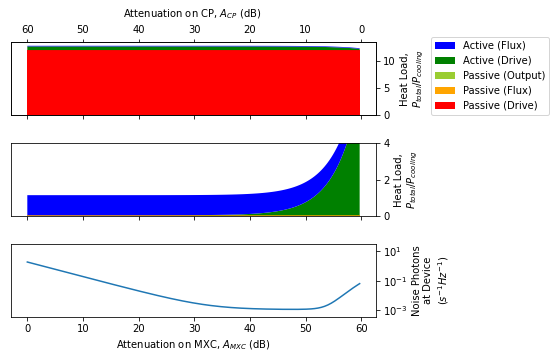

In [7]:
fig = plt.figure(figsize=(8, 6), tight_layout=True)

heights = [1, 1, 1, 1]
gs = fig.add_gridspec(4, 1, height_ratios=heights)

axs = [fig.add_subplot(gs[row, 0]) for row in range(1, 4)]

axs[0].stackplot(A, CP_data, colors=['red', 'orange', 'yellowgreen', 'green', 'blue'])
axs[1].stackplot(A, MXC_data, colors=['red', 'orange', 'yellowgreen', 'green', 'blue'])
axs[2].plot(A, n_data)

for ax in axs: ax.yaxis.tick_right()

axs[0].set_xticklabels([])
axs[1].set_xticklabels([])
axs[1].set_ylim(0, 4)
axs[2].set_yscale('log')
axs[2].set_ylim(10**-3.5, 10**1.5)
axs[2].set_yticks([1e1, 1e-1, 1e-3])

axs2 = axs[0].twiny()
axs2.set_xlim(axs[0].get_xlim())
axs2.set_xticks([i for i in range(0, 61, 10)])
axs2.set_xticklabels([60-i for i in range(0, 61, 10)])
fig.text(0.22, 0.8, r"Attenuation on CP, $A_{CP}$ (dB)")

l = axs[0].legend(['1', '2', '3', '4', '5'])
axs[0].legend(l.legendHandles[::-1], ['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'][::-1], loc=(1.15, 0.01))
axs[2].yaxis.set_label_position('right')
axs[2].set_ylabel('Noise Photons\nat Device\n' + r'($s^{-1}Hz^{-1}$)')
axs[0].yaxis.set_label_position('right')
axs[0].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 
axs[1].yaxis.set_label_position('right')
axs[1].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 
axs[2].set_xlabel(r"Attenuation on MXC, $A_{MXC}$ (dB)")

# plt.savefig('MXCandCP.png')

plt.show()


In [ ]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8, 3))

axs[0].stackplot(A, CP_data, colors=['red', 'orange', 'yellowgreen', 'green', 'blue'])
axs[1].stackplot(A, MXC_data, colors=['red', 'orange', 'yellowgreen', 'green', 'blue'])

axs[1].set_ylim(0, 4)

axs[-1].set_xlabel(r"Attenuation on MXC, $A_{MXC}$ (dB)")

# axs[-1].legend(['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'], loc=(1.05, 0.65))
fig.set_tight_layout(True)
plt.show()


In [ ]:
fig, axs = plt.subplots(figsize=(8, 3))

axs.plot(A, n_data)

axs.set_yscale('log')
axs.set_ylim(1e-4, 1e1)

axs.set_ylabel(r'Noise Photons at Device ($s^{-1}Hz^{-1}$)')
axs.set_xlabel(r"Attenuation on MXC, $A_{MXC}$ (dB)")

# axs[-1].legend(['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'], loc=(1.05, 0.65))
fig.set_tight_layout(True)
plt.show()

In [ ]:
a = pd.Series([1, 2, 3, 4], index=['a', 'b', 'c', 'd'])
b = pd.Series([5, 6, 7, 8], index=['a', 'b', 'c', 'd'])
pd.DataFrame([a, b])['a']

## 60dB Split between MXC and 4K

In [2]:
A = np.linspace(0, 60, 401, endpoint=True)
configs = [[0, 60-a, 0, 0, a] for a in A]

In [3]:
def config2therm(config):
    therm = [[not (a < 0.001) for a in config[:-1]]+[True]]*2 + [[True, True, True, True, True]]
    return therm

# therm_scheme_drive = [[False, True, False, False, True], #inner
#                   [False, True, False, False, True], #dielectric
#                   [True, True, True, True, True]]   #outer

# therm_scheme_flux = [[False, True, False, False, True], #inner
#                   [False, True, False, False, True], #dielectric
#                   [True, True, True, True, True]]   #outer

# therm_scheme_output = [[True, True, False, False, True], #inner
#                   [True, True, False, False, True], #dielectric
#                   [True, True, True, True, True]]   #outer

## 0dB attenuators
therm_scheme_drive = [[True]*5]*3

therm_scheme_flux = [[True]*5]*3

therm_scheme_output = [[True]*5]*3

In [4]:
FourK_loads = []
MXC_loads = []
temp_data = []

for conf in configs:

    therm_scheme_drive =[[True]*5]*3

    c_drive = '219-SS-SS'
    c_flux = '219-SS-SS'
    c_out_upper = '119-AgCuNi-CuNi'
    c_out_lower = '119-NbTi-NbTi'

    p_drive = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_drive]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
            therm_scheme=therm_scheme_drive,
            stage_temps=fridge_ours['temps'])

    p_flux = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_flux]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
            therm_scheme=therm_scheme_flux,
            stage_temps=fridge_ours['temps'])

    p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
            diameters=coax_co_params[c_out_lower]['d'],
            lengths=fridge_100q['lengths'],
            therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_out_upper]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out = p_out_upper[0:2].append(p_out_lower[2:])

    a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
            signal_p=1e-3*10**(-5/10), 
            signal_f=6, 
            att=conf,
            cable_att=coax_co_params[c_drive]['att_4'],
            lengths=fridge_ours['lengths'])

    a_dc = active_load_DC(i_in=20e-3, 
                    stage_labels=fridge_ours['labels'], 
                    att=[0, 20, 0, 0, 0], 
                    cable_rho=coax_co_params[c_flux]['rho'], 
                    lengths=fridge_ours['lengths'], 
                    diameters=coax_co_params[c_flux]['d'])

    c_p = np.array(fridge_ours['cool_p'])
    load_matrix = pd.DataFrame(
    [p_drive*14/c_p, p_flux*14/c_p, p_out*4/c_p, a_ac*14*0.33/c_p, a_dc*14*1/c_p], 
    index=['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)']
    )
    FourK_loads.append(load_matrix['4K'])
    MXC_loads.append(load_matrix['MXC'])

    total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

    total.iloc[0] = t_stages[0](total.iloc[0])
    total.iloc[1] = t_stages[1](total.iloc[1])
    total.iloc[2] = 1.227
    total.iloc[3] = t_stages[2](total.iloc[3])
    total.iloc[4] = t_stages[3](total.iloc[4])

    temp_data.append(total)

In [5]:
FourK_data = pd.DataFrame(FourK_loads).T.to_numpy()
MXC_data = pd.DataFrame(MXC_loads).T.to_numpy()

In [6]:
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )

n_data = []

for i in range(len(configs)):
    n_bar = n_BE(300, 6e9)
    for ii in range(5):
        att = configs[i][ii] + coax_co_params['219-CuNi-CuNi']['att_4'](6) * fridge_ours['lengths'][ii]
        n_bar = n_bar * 10**(-att/10) + (1-10**(-att/10)) * n_BE(temp_data[i][ii], 6e9)
    n_data.append(n_bar)

In [7]:
# noise contributions
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )

n_data = []

for i in range(len(configs)):
    n_temp = [n_BE(t, 6e9) for t in temp_data[i]]
    att = np.array(configs[i]) + coax_co_params['219-SS-SS']['att_4'](6) * np.array(fridge_ours['lengths'])
    for ii in range(5):
        n_temp[ii] = n_temp[ii] * (1-10**(-att[ii]/10)) * (10**(-np.sum(att[-1:ii:-1])/10))
    n_temp.insert(0, n_BE(300, 6e9)*10**(-np.sum(att)/10))
    n_data.append(n_temp)
#
n_data = np.array(n_data)

In [8]:
coax_co_params['219-CuNi-CuNi']['att_4'](6) * np.array(fridge_ours['lengths'])

array([1.30272, 1.86024, 1.656  , 0.828  , 1.22544])

In [24]:
MXC_loads[0].iloc[[0, 3]]

Passive (Drive)    0.102515
Active (Drive)     0.000005
Name: MXC, dtype: float64

In [26]:
heat = np.array([np.sum(s.iloc[[0, 3]]) for s in MXC_loads])
const = (heat>0.99) * (heat<1.01)
A[np.where(const)]

array([47.4])

In [22]:
noi = np.array(n_data)
const = (noi>0.95e-3) * (noi<1.05e-3)
A[np.where(const)]

array([38.55, 38.7 , 38.85, 39.  , 50.55])

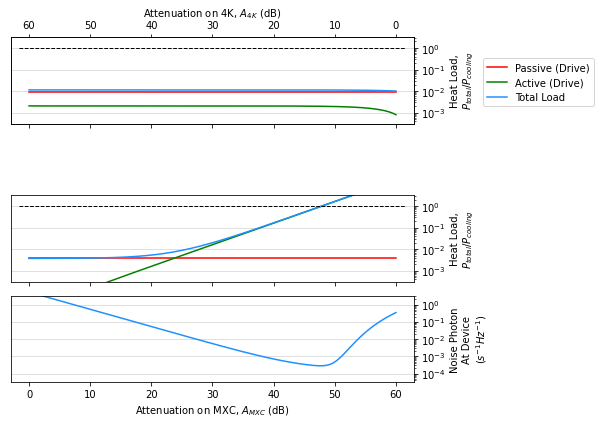

In [11]:
fig = plt.figure(figsize=(10, 6), tight_layout=True)
dgrm_width = 0.25

heights = [1, 0.5, 1, 1]
widths = [dgrm_width, 1]
gs = fig.add_gridspec(4, 2, height_ratios=heights, width_ratios=widths)

axs = [fig.add_subplot(gs[row-1, 1]) for row in [1, 3, 4]]

#4K
axs[0].plot(A, FourK_data[0, :], color='red') #passive
axs[0].plot(A, FourK_data[3, :], color='green')   #active
axs[0].plot(A, np.sum(FourK_data[[0, 3], :], axis=0), color='dodgerblue')    #total
# axs[0].fill_between(A, np.sum(CP_loads, axis=1), color='dodgerblue')    #total
# axs[0].fill_between(A, CP_loads[:, 0], color='red') #passive
# axs[0].fill_between(A, CP_loads[:, 1], color='green')   #active
    
#MXC
axs[1].plot(A, MXC_data[0, :], color='red') #passive
axs[1].plot(A, MXC_data[3, :], color='green')   #active
axs[1].plot(A, np.sum(MXC_data[[0, 3], :], axis=0), color='dodgerblue')    #total
# axs[1].fill_between(A, np.sum(MXC_loads, axis=1), color='dodgerblue')    #total
# axs[1].fill_between(A, MXC_loads[:, 0], color='red') #passive
# axs[1].fill_between(A, MXC_loads[:, 1], color='green')   #active
    
#noise
# axs[2].plot(A, n_data)
cmap = mpl.cm.get_cmap('plasma')
# axs[2].plot(A, n_data[:, 0], color=cmap(0.85))
# axs[2].plot(A, n_data[:, 2], color=cmap(0.5))
# axs[2].plot(A, n_data[:, 5], color=cmap(0.15))
axs[2].plot(A, np.sum(n_data, axis=1), color='dodgerblue')

for ax in axs: 
    ax.yaxis.tick_right()
    ax.set_yscale('log')

for i in range(2):
    axs[i].set_ylim(10**-3.5, 10**0.5)
    axs[i].set_yticks([1e-3, 1e-2, 1e-1, 1e0])
    axs[i].set_xticklabels([])

axs[2].set_ylim(10**-4.5, 10**0.5)
# axs[2].set_xticks([i for i in range(0, xl[s]+1, 5)])
axs[2].set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])

for ax in axs:
    locmin = mpl.ticker.LogLocator(base=10.0,subs=[0.1*(i+1) for i in range(9)],numticks=12)
    ax.yaxis.set_minor_locator(locmin)

axs2 = axs[0].twiny()
axs2.set_xlim(axs[0].get_xlim())
axs2.set_xticks([0, 10, 20, 30, 40, 50, 60])
axs2.set_xticklabels([60, 50, 40, 30, 20, 10, 0])
axs2.set_xlabel(r"Attenuation on 4K, $A_{4K}$ (dB)")

axs[2].set_xlabel(r"Attenuation on MXC, $A_{MXC}$ (dB)")
axs[0].axhline(1, 0.02, 0.98, lw=1, ls='--', c='k')
axs[1].axhline(1, 0.02, 0.98, lw=1, ls='--', c='k')

# # l = axs[0].legend(['1', '2', '3', '4'])
l = axs[0].legend(['Passive (Drive)', 'Active (Drive)', 'Total Load'], loc=(1.17, 0.2))
# l = axs[2].legend(labels=['RT Contribution', '4K Contribution', 'MXC Contribution', 'Total Noise at Device'], loc=(1.2, 0.14))
# # # axs[0].legend(l.legendHandles[::-1], ['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'][::-1], loc=(1.2, 0.01))
axs[2].yaxis.set_label_position('right')
axs[2].set_ylabel('Noise Photon\nAt Device\n' + r'($s^{-1}Hz^{-1}$)')
axs[0].yaxis.set_label_position('right')
axs[0].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 
axs[1].yaxis.set_label_position('right')
axs[1].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 

for ax in axs:
    ax.grid(True, which='major', axis='y', alpha=0.5)

# plt.savefig('AIPCongressMXCand4K.png', dpi=400, transparent=True)
# plt.savefig("0dB-4KMXC.png", dpi=400, transparent=True)

plt.show()

In [10]:
np.min(np.sum(n_data, axis=1))

0.00028255766363821503

In [ ]:
fig = plt.figure(figsize=(8, 6), tight_layout=True)
dgrm_width = 0.25

heights = [0.25, 1, 0.25, 1, 1]
widths = [dgrm_width, 1]
gs = fig.add_gridspec(5, 2, height_ratios=heights, width_ratios=widths)

axs = [fig.add_subplot(gs[row, 1]) for row in [1, 3, 4]]

axs[0].stackplot(A, FourK_data, colors=['red', 'orange', 'yellowgreen', 'green', 'blue'])
axs[1].stackplot(A, MXC_data, colors=['red', 'orange', 'yellowgreen', 'green', 'blue'])
axs[2].plot(A, n_data)

for ax in axs: ax.yaxis.tick_right()

axs[0].set_xticklabels([])
axs[1].set_xticklabels([])
axs[1].set_ylim(0, 4)
axs[2].set_yscale('log')
axs[2].set_ylim(10**-3.5, 10**1.5)
axs[2].set_yticks([1e1, 1e-1, 1e-3])

axs2 = axs[0].twiny()
axs2.set_xlim(axs[0].get_xlim())
axs2.set_xticks([i for i in range(0, 61, 10)])
axs2.set_xticklabels([60-i for i in range(0, 61, 10)])
fig.text(0.3, 0.92, r"Attenuation on 4K, $A_{4K}$ (dB)")

l = axs[0].legend(['1', '2', '3', '4', '5'])
axs[0].legend(l.legendHandles[::-1], ['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'][::-1], loc=(1.2, 0.01))
axs[2].yaxis.set_label_position('right')
axs[2].set_ylabel('Noise Photons\nat Device\n' + r'($s^{-1}Hz^{-1}$)')
axs[0].yaxis.set_label_position('right')
axs[0].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$')
axs[1].yaxis.set_label_position('right')
axs[1].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$')
axs[2].set_xlabel(r"Attenuation on MXC, $A_{MXC}$ (dB)")
axs[0].axhline(1, 0.02, 0.98, lw=1, ls='--', c='r')
axs[1].axhline(1, 0.02, 0.98, lw=1, ls='--', c='r')

plt.show()

In [ ]:
##### Plotting the dgrm
widths = [dgrm_width, 1]
gs2 = fig.add_gridspec(1, 2, width_ratios=widths)
dgrm = fig.add_subplot(gs2[0, 0])

#plotting the stage and cable lines
theight = dgrm.figbox.y1 - dgrm.figbox.y0
cheights = [((ax.figbox.y1 + ax.figbox.y0) / 2 - dgrm.figbox.y0) / theight for ax in axs]
room = (dgrm.figbox.y1 - axs[0].figbox.y1) / theight
cheights.insert(0, 1-room/2)
room = (axs[0].figbox.y0 - axs[1].figbox.y1) / theight
bot = (axs[1].figbox.y1 - axs[-1].figbox.y0) / theight
for i in range(2): cheights.insert(2, bot + room*(i+1)/3)

for i in range(1): dgrm.plot([0.5, 0.5], [1/6, 0.965], lw=1, c='k')
for i in range(5): dgrm.plot([0, 1], [cheights[i], cheights[i]], lw=3, c='gold')

#Plotting the device rectangle
w, h = 0.6, 0.05
dev = mpl.patches.Rectangle((0.5-w/2, cheights[-1]-(h/2)), w, h, facecolor='blue', edgecolor='black', lw=2)
dgrm.add_patch(dev)
dgrm.annotate('Devices', (0.5, cheights[-1]), c='w', ha='center', va='center')
l = 0.1
h = dev._y1-dev._y0
for i in range(3): dgrm.plot([dev._x0-l, dev._x0], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=1, c='k')
for i in range(3): dgrm.plot([dev._x1, dev._x1+l], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=1, c='k')
for i in range(3): dgrm.plot([dev._x0-l/3, dev._x0], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=2, c='k')
for i in range(3): dgrm.plot([dev._x1, dev._x1+l/3], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=2, c='k')

#setting limits and ticks
dgrm.set_xlim(0, 1)
dgrm.set_ylim(0, 1)
dgrm.set_xticks([])
dgrm.set_yticks(cheights[:-1])
dgrm.set_yticklabels(fridge_ours['labels'])

# removing axes borders
dgrm.spines['right'].set_visible(False)
dgrm.spines['left'].set_visible(False)
dgrm.spines['top'].set_visible(False)
dgrm.spines['bottom'].set_visible(False)

# Setting Configuration labels
# dgrm.set_title('Configuration')
# for i in range(5): dgrm.annotate('C'+str(i+1), ((1+2*i)/10, 0.975), c='k', ha='center', va='center')

# Plotting Attenuator Rectangles
w, h = 0.2, 0.18
atten = mpl.patches.Rectangle((0.5-w/2, cheights[1]-h/2), w, h, facecolor='w', edgecolor='k', lw=1.5, zorder=10)
dgrm.add_patch(atten)
dgrm.annotate(r'$(60-A_{MXC})$ dB', (0.5, cheights[1]), rotation=90, fontsize=8, ha='center', va='center', zorder=11)
w, h = 0.2, 0.11
atten = mpl.patches.Rectangle((0.5-w/2, cheights[4]-h/2), w, h, facecolor='w', edgecolor='k', lw=1.5, zorder=10)
dgrm.add_patch(atten)
dgrm.annotate(r'$A_{MXC}$ dB', (0.5, cheights[4]), rotation=90, fontsize=8, ha='center', va='center', zorder=11)

plt.savefig('MXCand4K.png', dpi=500)

plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 6), tight_layout=True)

heights = [0.25, 1, 0.1, 1, 1]
gs = fig.add_gridspec(5, 1, height_ratios=heights)

axs = [fig.add_subplot(gs[row, 0]) for row in [1, 3, 4]]

axs[0].stackplot(A, FourK_data, colors=['red', 'orange', 'yellowgreen', 'green', 'blue'])
axs[1].stackplot(A, MXC_data, colors=['red', 'orange', 'yellowgreen', 'green', 'blue'])
axs[2].plot(A, n_data)

for ax in axs: ax.yaxis.tick_right()

axs[0].set_xticklabels([])
axs[1].set_xticklabels([])
axs[1].set_ylim(0, 4)
axs[2].set_yscale('log')
axs[2].set_ylim(10**-3.5, 10**1.5)
axs[2].set_yticks([1e1, 1e-1, 1e-3])

axs2 = axs[0].twiny()
axs2.set_xlim(axs[0].get_xlim())
axs2.set_xticks([i for i in range(0, 61, 10)])
axs2.set_xticklabels([60-i for i in range(0, 61, 10)])
fig.text(0.22, 0.92, r"Attenuation on CP, $A_{CP}$ (dB)")

l = axs[0].legend(['1', '2', '3', '4', '5'])
axs[0].legend(l.legendHandles[::-1], ['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'][::-1], loc=(1.16, 0.01))
axs[2].yaxis.set_label_position('right')
axs[2].set_ylabel('Noise Photons\nat Device\n' + r'($s^{-1}Hz^{-1}$)')
axs[0].yaxis.set_label_position('right')
axs[0].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$')
axs[1].yaxis.set_label_position('right')
axs[1].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$')
axs[2].set_xlabel(r"Attenuation on MXC, $A_{MXC}$ (dB)")

plt.savefig('MXCand4K.png')

plt.show()


In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 3))

axs[0].stackplot(A, FourK_data, colors=['red', 'orange', 'yellowgreen', 'green', 'blue'])
axs[1].stackplot(A, MXC_data, colors=['red', 'orange', 'yellowgreen', 'green', 'blue'])

axs[1].set_ylim(0, 4)

axs[-1].set_xlabel(r"Attenuation on MXC, $A_{MXC}$ (dB)")

# axs[-1].legend(['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'], loc=(1.05, 0.65))
fig.set_tight_layout(True)
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(8, 3))

axs.plot(A, n_data)

axs.set_yscale('log')
axs.set_ylim(1e-4, 1e1)

axs.set_ylabel(r'Noise Photons at Device ($s^{-1}Hz^{-1}$)')
axs.set_xlabel(r"Attenuation on MXC, $A_{MXC}$ (dB)")

# axs[-1].legend(['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'], loc=(1.05, 0.65))
fig.set_tight_layout(True)
plt.show()

## 60 dB across MXC, CP and 4K

In [2]:
n = 200
A_MXC = np.linspace(0, 60, n+1, endpoint=True)
A_CP = np.linspace(0, 60, n+1, endpoint=True)

configs = [[[0, 60-(i+ii), 0, ii, i] for ii  in A_CP] for i in A_MXC]

In [3]:
def config2therm(config):
    therm = [[not (a < 0.001) for a in config[:-1]]+[True]]*2 + [[True, True, True, True, True]]
    return therm

therm_scheme_drive = [[False, True, False, True, True], #inner
                  [False, True, False, True, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_flux = [[False, True, False, False, True], #inner
                  [False, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_output = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [4]:
FourK_loads = []
CP_loads = []
MXC_loads = []
temp_data = []

for i in configs:
    temp_4K = []
    temp_CP = []
    temp_MXC = []
    temp_temp = []
    for conf in i:

        if conf[1] <= 60/n*0.9:
            temp_4K.append(np.nan)
            temp_CP.append(np.nan)
            temp_MXC.append(np.nan)
            temp_temp.append(np.nan)
            continue

        therm_scheme_drive = config2therm(conf)

        c_drive = '219-SS-SS'
        c_flux = '219-SS-SS'
        c_out_upper = '119-AgCuNi-CuNi'
        c_out_lower = '119-NbTi-NbTi'

        p_drive = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_drive]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
                therm_scheme=therm_scheme_drive,
                stage_temps=fridge_ours['temps'])

        p_flux = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_flux]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
                therm_scheme=therm_scheme_flux,
                stage_temps=fridge_ours['temps'])

        p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
                diameters=coax_co_params[c_out_lower]['d'],
                lengths=fridge_100q['lengths'],
                therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
                therm_scheme=therm_scheme_output,
                stage_temps=fridge_ours['temps'])

        p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_out_upper]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
                therm_scheme=therm_scheme_output,
                stage_temps=fridge_ours['temps'])

        p_out = p_out_upper[0:2].append(p_out_lower[2:])

        a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
                signal_p=1e-3*10**(-5/10), 
                signal_f=6, 
                att=conf,
                cable_att=coax_co_params[c_drive]['att_4'],
                lengths=fridge_ours['lengths'])

        a_dc = active_load_DC(i_in=20e-3, 
                        stage_labels=fridge_ours['labels'], 
                        att=[0, 20, 0, 0, 0], 
                        cable_rho=coax_co_params[c_flux]['rho'], 
                        lengths=fridge_ours['lengths'], 
                        diameters=coax_co_params[c_flux]['d'])

        c_p = np.array(fridge_ours['cool_p'])
        # total = p_drive*14/c_p + p_flux*14/c_p + p_out*4/c_p + a_ac*14*0.33/c_p + a_dc*14*1/c_p
        total = p_drive*14/c_p + a_ac*14*0.33/c_p
        
        temp_4K.append(total['4K'])
        temp_CP.append(total['CP'])
        temp_MXC.append(total['MXC'])

        total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

        total.iloc[0] = t_stages[0](total.iloc[0])
        total.iloc[1] = t_stages[1](total.iloc[1])
        total.iloc[2] = 1.227
        total.iloc[3] = t_stages[2](total.iloc[3])
        total.iloc[4] = t_stages[3](total.iloc[4])

        temp_temp.append(total.to_list())

    FourK_loads.append(temp_4K)
    CP_loads.append(temp_CP)
    MXC_loads.append(temp_MXC)
    temp_data.append(temp_temp)
        

In [5]:
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )

n_data = []

for i in range(len(configs)):
    temp = []
    for ii in range(len(configs[0])):
        if not isinstance(temp_data[i][ii], list):
            temp.append(np.nan)
            continue
        n_bar = n_BE(300, 6e9)
        for iii in range(5):
            att = configs[i][ii][iii] + + coax_co_params['219-SS-SS']['att_4'](6) * fridge_ours['lengths'][iii]
            n_bar = n_bar * 10**(-att/10) + (1-10**(-att/10)) * n_BE(temp_data[i][ii][iii], 6e9)
        temp.append(n_bar)
    n_data.append(temp)

In [11]:
fig = plt.figure(figsize=(12, 8.5), tight_layout=True)
dgrm_width = 0.3

widths = [dgrm_width, 1, 1]
gs = fig.add_gridspec(2, 3, width_ratios=widths)

axs = []
axs.append(fig.add_subplot(gs[0, 1]))
axs.append(fig.add_subplot(gs[0, 2]))
axs.append(fig.add_subplot(gs[1, 1]))
axs.append(fig.add_subplot(gs[1, 2]))

X, Y = np.meshgrid(A_MXC, A_CP)

dat = [FourK_loads, CP_loads, MXC_loads]
titles = ['4K', 'CP', 'MXC']
lims = [(3.5e-2, 3.9e-2), (1e-2, 1), (1e-3, 1e1)]
colours = [('k', 'k', 'k'), ('k', 'w', 'w'), ('k', 'w', 'w'), ('k', 'w', 'w')]

for i in range(4):
    axs[i].plot([0, 60], [60+60/n, 0+60/n], lw=3.5, c='w')
    axs[i].plot([0, 60], [60, 0], lw=0.5, c='k')

    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)

    axs[i].plot([0, 40], [40, 0], lw=0.5, c='k')
    axs[i].plot([0, 20], [20, 0], lw=0.5, c='k')

    axs[i].set_xlim(0, 60)
    axs[i].set_ylim(0, 60)
    axs[i].set_xlabel("CP Attenuation (dB)")
    axs[i].set_ylabel("MXC Attenuation (dB)")

for i in range(3):

    # c = axs[i].pcolormesh(X, Y, np.array(dat[i]), cmap='plasma', vmin=lims[i][0], vmax=lims[i][1])
    
    d_temp = np.array(dat[i])[np.array(dat[i])>0]
    c = axs[i].pcolormesh(X, Y, np.array(dat[i]), norm=LogNorm(vmin=d_temp.min(), vmax=d_temp.max()), vmin=lims[i][0], vmax=lims[i][1], cmap='plasma')

    cb = fig.colorbar(c, ax=axs[i])
    axs[i].set_title('Heat Load on ' + titles[i])
    cb.set_label(r'Heat Load, $P_{total}/P_{cooling}$')
    # axs[i].annotate(r'$A_{4K}=$0dB', (8, 54), size=8, c=colours[i][0])
    # axs[i].annotate(r'$A_{4K}=$20dB', (8, 34), size=8, c=colours[i][1])
    # axs[i].annotate(r'$A_{4K}=$40dB', (8, 14), size=8, c=colours[i][2])

    if i > 0:
        axs[i].contour(X, Y, np.array(dat[i]), [1e-3, 1e-2, 1e-1, 1e0], colors='w', linewidths=0.75)
        axs[i].contour(X, Y, np.array(dat[i]), np.array([[ii*10**i for ii in [2, 5]] for i in [-3, -2, -1, 0]]).flatten(), colors='w', linewidths=0.2)

axs[0].annotate(r'$A_{4K}=$0dB', (8, 54), size=8, c='k')
axs[0].annotate(r'$A_{4K}=$20dB', (8, 34), size=8, c='k')
axs[0].annotate(r'$A_{4K}=$40dB', (8, 14), size=8, c='k')

axs[1].annotate('1e-1', (30, 20), size=8, c='w', va='center', ha='center')
# axs[1].annotate('1e-1', (30, 20), size=8, c='w', va='center', ha='center')

axs[2].annotate('1e-0', (6, 49), size=8, c='w', va='center', ha='center')
axs[2].annotate('5e-1', (8, 45), size=8, c='w', va='center', ha='center')
axs[2].annotate('2e-1', (10, 41), size=8, c='w', va='center', ha='center')
axs[2].annotate('1e-1', (14, 38.75), size=8, c='w', va='center', ha='center')
axs[2].annotate('5e-2', (18, 34), size=8, c='w', va='center', ha='center')
axs[2].annotate('2e-2', (20.5, 30), size=8, c='w', va='center', ha='center')
axs[2].annotate('1e-2', (25, 26.75), size=8, c='w', va='center', ha='center')
# axs[2].annotate('2e-3', (25, 25), size=8, c='w', va='center', ha='center')


##########################################################

np_n = np.array(n_data)[np.array(n_data)>0]

c = axs[-1].pcolormesh(X, Y, np.array(n_data), norm=LogNorm(vmin=np_n.min(), vmax=np_n.max()))
cb = plt.colorbar(c, ax=axs[-1])
axs[-1].contour(X, Y, np.array(n_data), [1e-4, 1e-3, 1e-2, 1e-1, 1e0], colors='w', linewidths=0.75)
axs[-1].contour(X, Y, np.array(n_data), [2e-4, 5e-4, 2e-3, 5e-3, 2e-2, 5e-2, 2e-1, 5e-1], colors='w', linewidths=0.2)

# axs[-1].annotate('1e-4', (23, 30.5), size=8, c='w', va='center', ha='center')
axs[-1].annotate('2e-4', (18, 38), size=8, c='w', va='center', ha='center')
axs[-1].annotate('5e-4', (29, 22), size=8, c='w', va='center', ha='center')
axs[-1].annotate('1e-3', (31.3, 18), size=8, c='w', va='center', ha='center')
axs[-1].annotate('2e-3', (36, 13), size=8, c='w', va='center', ha='center')
axs[-1].annotate('5e-3', (42, 10), size=8, c='w', va='center', ha='center')
axs[-1].annotate('1e-2', (40, 6.4), size=8, c='w', va='center', ha='center')
axs[-1].annotate('2e-2', (45, 2), size=8, c='w', va='center', ha='center')
# axs[-1].annotate('5e-2', (29, 22), size=8, c='w', va='center', ha='center')

# t = np.array(MXC_loads)

# thresholds = [2, 1.5, 1.25, 1.16]
# limits = [0.005, 0.005, 0.005, 0.0001]
# d = []
# for i in range(len(thresholds)):
#     upper, lower = thresholds[i]+limits[i], thresholds[i]-limits[i]
#     d_temp = ((t<upper) * (t>lower) * 1).astype('float')
#     d.append(d_temp)
# d = sum(d)

# d[d!=1] = np.nan
# axs[-1].pcolormesh(X, Y, d, cmap='Spectral')

# axs[-1].annotate(r'MXC, $P_{total}/P_{cooling}=2$', (11, 50), size=8, c='r')
# axs[-1].annotate(r'MXC, $P_{total}/P_{cooling}=1.5$', (14, 47), size=8, c='r')
# axs[-1].annotate(r'MXC, $P_{total}/P_{cooling}=1.25$', (20, 41), size=8, c='r')
# axs[-1].annotate(r'MXC, $P_{total}/P_{cooling}=1.16$', (35, 26), size=8, c='r')

axs[-1].set_title("Noise Photons at Device")
cb.set_label(r'Noise Photons $(s^{-1}Hz^{-1})$')

plt.tight_layout(True)

# plt.savefig('.png', dpi=400)
plt.show()

C:\Users\Adrien\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater
C:\Users\Adrien\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in greater
C:\Users\Adrien\anaconda3\lib\site-packages\matplotlib\colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


In [6]:
fig = plt.figure(figsize=(12*6/7, 8.5*4/5), tight_layout=True)
dgrm_width = 0.3

widths = [dgrm_width, 1, 1]
gs = fig.add_gridspec(2, 3, width_ratios=widths)

axs = []
axs.append(fig.add_subplot(gs[0, 1]))
axs.append(fig.add_subplot(gs[0, 2]))
axs.append(fig.add_subplot(gs[1, 1]))
axs.append(fig.add_subplot(gs[1, 2]))

X, Y = np.meshgrid(A_MXC, A_CP)

dat = [FourK_loads, CP_loads, MXC_loads]
titles = ['4K', 'CP', 'MXC']
lims = [(3.5e-2, 3.9e-2), (1e-2, 1), (1e-3, 1e1)]
colours = [('k', 'k', 'k'), ('k', 'w', 'w'), ('k', 'w', 'w'), ('k', 'w', 'w')]

for i in range(4):
    axs[i].plot([0, 60], [60+60/n, 0+60/n], lw=3.5, c='w')
    axs[i].plot([0, 60], [60, 0], lw=0.5, c='k')

    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)

    axs[i].plot([0, 40], [40, 0], lw=0.5, c='k')
    axs[i].plot([0, 20], [20, 0], lw=0.5, c='k')

    axs[i].set_xlim(0, 60)
    axs[i].set_ylim(0, 60)
    axs[i].set_xlabel("CP Attenuation (dB)")
    axs[i].set_ylabel("MXC Attenuation (dB)")

for i in range(3):

    # c = axs[i].pcolormesh(X, Y, np.array(dat[i]), cmap='plasma', vmin=lims[i][0], vmax=lims[i][1])
    
    d_temp = np.array(dat[i])[np.array(dat[i])>0]
    c = axs[i].pcolormesh(X, Y, np.array(dat[i]), norm=LogNorm(vmin=d_temp.min(), vmax=d_temp.max()), vmin=lims[i][0], vmax=lims[i][1], cmap='plasma')

    cb = fig.colorbar(c, ax=axs[i])
    axs[i].set_title('Heat Load on ' + titles[i])
    cb.set_label(r'Heat Load, $P_{total}/P_{cooling}$')
    # axs[i].annotate(r'$A_{4K}=$0dB', (8, 54), size=8, c=colours[i][0])
    # axs[i].annotate(r'$A_{4K}=$20dB', (8, 34), size=8, c=colours[i][1])
    # axs[i].annotate(r'$A_{4K}=$40dB', (8, 14), size=8, c=colours[i][2])

    if i > 0:
        axs[i].contour(X, Y, np.array(dat[i]), [1e-3, 1e-2, 1e-1, 1e0], colors='w', linewidths=0.75)
        axs[i].contour(X, Y, np.array(dat[i]), np.array([[ii*10**i for ii in [2, 5]] for i in [-3, -2, -1, 0]]).flatten(), colors='w', linewidths=0.2)

axs[0].annotate(r'$A_{4K}=$0dB', (8, 54), size=8, c='k')
axs[0].annotate(r'$A_{4K}=$20dB', (8, 34), size=8, c='k')
axs[0].annotate(r'$A_{4K}=$40dB', (8, 14), size=8, c='k')

axs[1].annotate('1e-1', (30, 20), size=8, c='w', va='center', ha='center')
# axs[1].annotate('1e-1', (30, 20), size=8, c='w', va='center', ha='center')

axs[2].annotate('1e-0', (6, 49), size=8, c='w', va='center', ha='center')
axs[2].annotate('5e-1', (8, 45), size=8, c='w', va='center', ha='center')
axs[2].annotate('2e-1', (10, 41), size=8, c='w', va='center', ha='center')
axs[2].annotate('1e-1', (14, 38.75), size=8, c='w', va='center', ha='center')
axs[2].annotate('5e-2', (18, 34), size=8, c='w', va='center', ha='center')
axs[2].annotate('2e-2', (20.5, 30), size=8, c='w', va='center', ha='center')
axs[2].annotate('1e-2', (25, 26.75), size=8, c='w', va='center', ha='center')
# axs[2].annotate('2e-3', (25, 25), size=8, c='w', va='center', ha='center')


##########################################################

np_n = np.array(n_data)[np.array(n_data)>0]

c = axs[-1].pcolormesh(X, Y, np.array(n_data), norm=LogNorm(vmin=np_n.min(), vmax=np_n.max()))
cb = plt.colorbar(c, ax=axs[-1])
axs[-1].contour(X, Y, np.array(n_data), [1e-4, 1e-3, 1e-2, 1e-1, 1e0], colors='w', linewidths=0.75)
axs[-1].contour(X, Y, np.array(n_data), [2e-4, 5e-4, 2e-3, 5e-3, 2e-2, 5e-2, 2e-1, 5e-1], colors='w', linewidths=0.2)

# axs[-1].annotate('1e-4', (23, 30.5), size=8, c='w', va='center', ha='center')
axs[-1].annotate('2e-4', (18, 38), size=8, c='w', va='center', ha='center')
axs[-1].annotate('5e-4', (29, 22), size=8, c='w', va='center', ha='center')
axs[-1].annotate('1e-3', (31.3, 18), size=8, c='w', va='center', ha='center')
axs[-1].annotate('2e-3', (36, 13), size=8, c='w', va='center', ha='center')
axs[-1].annotate('5e-3', (42, 10), size=8, c='w', va='center', ha='center')
axs[-1].annotate('1e-2', (40, 6.4), size=8, c='w', va='center', ha='center')
axs[-1].annotate('2e-2', (45, 2), size=8, c='w', va='center', ha='center')
# axs[-1].annotate('5e-2', (29, 22), size=8, c='w', va='center', ha='center')

# t = np.array(MXC_loads)

# thresholds = [2, 1.5, 1.25, 1.16]
# limits = [0.005, 0.005, 0.005, 0.0001]
# d = []
# for i in range(len(thresholds)):
#     upper, lower = thresholds[i]+limits[i], thresholds[i]-limits[i]
#     d_temp = ((t<upper) * (t>lower) * 1).astype('float')
#     d.append(d_temp)
# d = sum(d)

# d[d!=1] = np.nan
# axs[-1].pcolormesh(X, Y, d, cmap='Spectral')

# axs[-1].annotate(r'MXC, $P_{total}/P_{cooling}=2$', (11, 50), size=8, c='r')
# axs[-1].annotate(r'MXC, $P_{total}/P_{cooling}=1.5$', (14, 47), size=8, c='r')
# axs[-1].annotate(r'MXC, $P_{total}/P_{cooling}=1.25$', (20, 41), size=8, c='r')
# axs[-1].annotate(r'MXC, $P_{total}/P_{cooling}=1.16$', (35, 26), size=8, c='r')

axs[-1].set_title("Noise Photons at Device")
cb.set_label(r'Noise Photons $(s^{-1}Hz^{-1})$')

plt.tight_layout(True)

plt.savefig('AIPCongressDriveNoise2.png', dpi=400)
plt.show()

In [11]:
np.array([[ii*10**i for ii in [2, 5]] for i in [-2, -1, 0]]).flatten()

array([0.02, 0.05, 0.2 , 0.5 , 2.  , 5.  ])

In [ ]:
fig = plt.figure(figsize=(12, 8.5), tight_layout=True)
dgrm_width = 0.3

widths = [dgrm_width, 1, 1]
gs = fig.add_gridspec(2, 3, width_ratios=widths)

axs = []
axs.append(fig.add_subplot(gs[0, 1]))
axs.append(fig.add_subplot(gs[0, 2]))
axs.append(fig.add_subplot(gs[1, 1]))
axs.append(fig.add_subplot(gs[1, 2]))

X, Y = np.meshgrid(A_MXC, A_CP)

dat = [FourK_loads, CP_loads, MXC_loads]
titles = ['4K', 'CP', 'MXC']
lims = [(0.595, 0.59), (0, 0.8), (0, 6)]
colours = [('k', 'k', 'k'), ('k', 'w', 'w'), ('k', 'w', 'w'), ('k', 'w', 'w')]

for i in range(4):
    axs[i].plot([0, 60], [60+60/n, 0+60/n], lw=3.5, c='w')
    axs[i].plot([0, 60], [60, 0], lw=0.5, c='k')

    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)

    axs[i].plot([0, 40], [40, 0], lw=0.5, c='k')
    axs[i].plot([0, 20], [20, 0], lw=0.5, c='k')

    axs[i].annotate(r'$A_{4K}=$0dB', (8, 54), size=8, c=colours[i][0])
    axs[i].annotate(r'$A_{4K}=$20dB', (8, 34), size=8, c=colours[i][1])
    axs[i].annotate(r'$A_{4K}=$40dB', (8, 14), size=8, c=colours[i][2])

    axs[i].set_xlim(0, 60)
    axs[i].set_ylim(0, 60)
    axs[i].set_xlabel("CP Attenuation (dB)")
    axs[i].set_ylabel("MXC Attenuation (dB)")

for i in range(3):


    c = axs[i].pcolormesh(X, Y, np.array(dat[i]), cmap='plasma', vmin=lims[i][0], vmax=lims[i][1])
    cb = fig.colorbar(c, ax=axs[i])
    axs[i].set_title('Heat Load on ' + titles[i])
    cb.set_label(r'Heat Load, $P_{total}/P_{cooling}$')

##########################################################

np_n = np.array(n_data)[np.array(n_data)>0]

c = axs[-1].pcolormesh(X, Y, np.array(n_data), norm=LogNorm(vmin=np_n.min(), vmax=np_n.max()), vmin=1e-3)
cb = plt.colorbar(c, ax=axs[-1])

t = np.array(MXC_loads)

thresholds = [2, 1.5, 1.25, 1.16]
limits = [0.005, 0.005, 0.005, 0.0001]
d = []
for i in range(len(thresholds)):
    upper, lower = thresholds[i]+limits[i], thresholds[i]-limits[i]
    d_temp = ((t<upper) * (t>lower) * 1).astype('float')
    d.append(d_temp)
d = sum(d)

d[d!=1] = np.nan
axs[-1].pcolormesh(X, Y, d, cmap='Spectral')

axs[-1].annotate(r'MXC, $P_{total}/P_{cooling}=2$', (11, 50), size=8, c='r')
axs[-1].annotate(r'MXC, $P_{total}/P_{cooling}=1.5$', (14, 47), size=8, c='r')
axs[-1].annotate(r'MXC, $P_{total}/P_{cooling}=1.25$', (20, 41), size=8, c='r')
axs[-1].annotate(r'MXC, $P_{total}/P_{cooling}=1.16$', (35, 26), size=8, c='r')

axs[-1].set_title("Noise Photons at Device")
cb.set_label(r'Noise Photons $(s^{-1}Hz^{-1})$')

plt.tight_layout(True)

############################

widths = [dgrm_width, 1, 1]
gs2 = fig.add_gridspec(1, 3, width_ratios=widths)
dgrm = fig.add_subplot(gs2[0, 0])

#plotting the stage and cable lines
# theight = dgrm.figbox.y1 - dgrm.figbox.y0
cheights = [1 - (2*i+1)/12 for i in range(6)]

dgrm.plot([0.5, 0.5], [1/6, 0.965], lw=1, c='k')
for i in range(5): dgrm.plot([0, 1], [cheights[i], cheights[i]], lw=3, c='gold')

#Plotting the device rectangle
w, h = 0.6, 0.05
dev = mpl.patches.Rectangle((0.5-w/2, cheights[-1]-(h/2)), w, h, facecolor='blue', edgecolor='black', lw=2)
dgrm.add_patch(dev)
dgrm.annotate('Devices', (0.5, cheights[-1]), c='w', ha='center', va='center')
l = 0.1
h = dev._y1-dev._y0
for i in range(3): dgrm.plot([dev._x0-l, dev._x0], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=1, c='k')
for i in range(3): dgrm.plot([dev._x1, dev._x1+l], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=1, c='k')
for i in range(3): dgrm.plot([dev._x0-l/3, dev._x0], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=2, c='k')
for i in range(3): dgrm.plot([dev._x1, dev._x1+l/3], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=2, c='k')

#setting limits and ticks
dgrm.set_xlim(0, 1)
dgrm.set_ylim(0, 1)
dgrm.set_xticks([])
dgrm.set_yticks(cheights[:-1])
dgrm.set_yticklabels(fridge_ours['labels'])

# removing axes borders
dgrm.spines['right'].set_visible(False)
dgrm.spines['left'].set_visible(False)
dgrm.spines['top'].set_visible(False)
dgrm.spines['bottom'].set_visible(False)

# Setting Configuration labels
# dgrm.set_title('Configuration')
# for i in range(5): dgrm.annotate('C'+str(i+1), ((1+2*i)/10, 0.975), c='k', ha='center', va='center')

# Plotting Attenuator Rectangles
w, h = 0.38, 0.11
atten = mpl.patches.Rectangle((0.5-w/2, cheights[1]-h/2), w, h, facecolor='w', edgecolor='k', lw=1.5, zorder=10)
dgrm.add_patch(atten)
dgrm.annotate(r'$(60-A_{MXC}$'+'\n'+r'$-A_{CP})$ dB', (0.5, cheights[1]), rotation=90, fontsize=8, ha='center', va='center', zorder=11)
w, h = 0.2, 0.08
atten = mpl.patches.Rectangle((0.5-w/2, cheights[3]-h/2), w, h, facecolor='w', edgecolor='k', lw=1.5, zorder=10)
dgrm.add_patch(atten)
dgrm.annotate(r'$A_{CP}$ dB', (0.5, cheights[3]), rotation=90, fontsize=8, ha='center', va='center', zorder=11)
w, h = 0.2, 0.08
atten = mpl.patches.Rectangle((0.5-w/2, cheights[4]-h/2), w, h, facecolor='w', edgecolor='k', lw=1.5, zorder=10)
dgrm.add_patch(atten)
dgrm.annotate(r'$A_{MXC}$ dB', (0.5, cheights[4]), rotation=90, fontsize=8, ha='center', va='center', zorder=11)

plt.savefig('MXCandCPand4K.png', dpi=500)

plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(9.2, 8.1))
axs = axs.flatten()

X, Y = np.meshgrid(A_MXC, A_CP)

dat = [FourK_loads, CP_loads, MXC_loads]
titles = ['4K', 'CP', 'MXC']
lims = [(0.595, 0.59), (0, 0.8), (0, 6)]
colours = [('k', 'k', 'k'), ('k', 'w', 'w'), ('k', 'w', 'w'), ('k', 'w', 'w')]

for i in range(4):
    axs[i].plot([0, 60], [60+60/n, 0+60/n], lw=3.5, c='w')
    axs[i].plot([0, 60], [60, 0], lw=0.5, c='k')

    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)

    axs[i].plot([0, 40], [40, 0], lw=0.5, c='k')
    axs[i].plot([0, 20], [20, 0], lw=0.5, c='k')

    axs[i].annotate(r'$A_{4K}=$0dB', (8, 54), size=8, c=colours[i][0])
    axs[i].annotate(r'$A_{4K}=$20dB', (8, 34), size=8, c=colours[i][1])
    axs[i].annotate(r'$A_{4K}=$40dB', (8, 14), size=8, c=colours[i][2])

    axs[i].set_xlim(0, 60)
    axs[i].set_ylim(0, 60)
    axs[i].set_xlabel("CP Attenuation (dB)")
    axs[i].set_ylabel("MXC Attenuation (dB)")

for i in range(3):


    c = axs[i].pcolormesh(X, Y, np.array(dat[i]), cmap='plasma', vmin=lims[i][0], vmax=lims[i][1])
    cb = fig.colorbar(c, ax=axs[i])
    axs[i].set_title('Heat Load on ' + titles[i])
    cb.set_label(r'Heat Load, $P_{total}/P_{cooling}$')

##########################################################

np_n = np.array(n_data)[np.array(n_data)>0]

c = axs[-1].pcolormesh(X, Y, np.array(n_data), norm=LogNorm(vmin=np_n.min(), vmax=np_n.max()), vmin=1e-3)
cb = plt.colorbar(c, ax=axs[-1])

t = np.array(MXC_loads)

thresholds = [2, 1.5, 1.25, 1.16]
limits = [0.005, 0.005, 0.005, 0.0001]
d = []
for i in range(len(thresholds)):
    upper, lower = thresholds[i]+limits[i], thresholds[i]-limits[i]
    d_temp = ((t<upper) * (t>lower) * 1).astype('float')
    d.append(d_temp)
d = sum(d)

d[d!=1] = np.nan
axs[-1].pcolormesh(X, Y, d, cmap='Spectral')

axs[-1].annotate(r'MXC, $P_{total}/P_{cooling}=2$', (11, 50), size=8, c='r')
axs[-1].annotate(r'MXC, $P_{total}/P_{cooling}=1.5$', (14, 47), size=8, c='r')
axs[-1].annotate(r'MXC, $P_{total}/P_{cooling}=1.25$', (20, 41), size=8, c='r')
axs[-1].annotate(r'MXC, $P_{total}/P_{cooling}=1.16$', (35, 26), size=8, c='r')

axs[-1].set_title("Noise Photons at Device")
cb.set_label(r'Noise Photons $(s^{-1}Hz^{-1})$')

plt.tight_layout(True)

plt.savefig('MXCandCPand4K.png')
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(6, 5))

X, Y = np.meshgrid(A_MXC, A_CP)

# c = axs.pcolormesh(X, Y, np.array(FourK_loads), vmin=0, vmax=1)
c = axs.pcolormesh(X, Y, np.array(FourK_loads))
cb = fig.colorbar(c, ax=axs)
# axs.plot([0, 60], [60+60/n, 0+60/n], lw=3.5, c='w')
# axs.plot([0, 60], [60, 0], lw=0.5, c='k')

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

axs.plot([0, 40], [40, 0], lw=0.5, c='k')
axs.plot([0, 20], [20, 0], lw=0.5, c='k')

axs.annotate(r'$A_{4K}=$0dB', (10, 52), size=8)
axs.annotate(r'$A_{4K}=$20dB', (10, 32), size=8)
axs.annotate(r'$A_{4K}=$40dB', (10, 12), size=8)

axs.set_title("4K")
axs.set_xlim(0, 60)
axs.set_ylim(0, 60)
axs.set_xlabel("CP Attenuation (dB)")
axs.set_ylabel("MXC Attenuation (dB)")
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(6, 5))

X, Y = np.meshgrid(A_MXC, A_CP)
np_n = np.array(n_data)[np.array(n_data)>0]

# c = axs.pcolormesh(X, Y, np.array(n_data))
c = axs.pcolormesh(X, Y, np.array(n_data), norm=LogNorm(vmin=np_n.min(), vmax=np_n.max()), vmin=1e-3)
cb = plt.colorbar(c, ax=axs)
axs.plot([0, 60], [60+60/n, 0+60/n], lw=3.5, c='w')
axs.plot([0, 60], [60, 0], lw=0.5, c='k')

t = np.array(MXC_loads)

thresholds = [2, 1.5, 1.25, 1.16]
limits = [0.005, 0.005, 0.005, 0.0001]
d = []
for i in range(len(thresholds)):
    upper, lower = thresholds[i]+limits[i], thresholds[i]-limits[i]
    d_temp = ((t<upper) * (t>lower) * 1).astype('float')
    d.append(d_temp)
d = sum(d)

d[d!=1] = np.nan
axs.pcolormesh(X, Y, d, cmap='Spectral')

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

axs.plot([0, 40], [40, 0], lw=0.5, c='k')
axs.plot([0, 20], [20, 0], lw=0.5, c='k')

axs.annotate(r'$A_{4K}=$0dB', (5, 57), size=8)
axs.annotate(r'$A_{4K}=$20dB', (10, 32), size=8, c='w')
axs.annotate(r'$A_{4K}=$40dB', (10, 12), size=8)

axs.annotate(r'MXC, $P_{total}/P_{cooling}=2$', (11, 50), size=8, c='r')
axs.annotate(r'MXC, $P_{total}/P_{cooling}=1.5$', (14, 47), size=8, c='r')
axs.annotate(r'MXC, $P_{total}/P_{cooling}=1.25$', (20, 41), size=8, c='r')
axs.annotate(r'MXC, $P_{total}/P_{cooling}=1.16$', (35, 26), size=8, c='r')

axs.set_title("Noise")
axs.set_xlim(0, 60)
axs.set_ylim(0, 60)
axs.set_xlabel("CP Attenuation (dB)")
axs.set_ylabel("MXC Attenuation (dB)")
cb.set_label(r'Noise Photons, n $(s^{-1}Hz^{-1})$')
fig.set_tight_layout(True)
plt.show()

## Splitting 10dB between 50K and 4K

In [ ]:
A = np.linspace(0, 10, 200, endpoint=False)
configs = [[10-a, a, 0, 10, 40] for a in A]

In [ ]:
def config2therm(config):
    therm = [[not (a < 0.001) for a in config[:-1]]+[True]]*2 + [[True, True, True, True, True]]
    return therm

def t_maker(point1, point2):

    def t_stage(power):
        m = (point1[1] - point2[1]) / (point1[0] - point2[0])
        return m * (power - point1[0]) + point1[1]
    
    return t_stage

#point for interpolation of the temperature (excluding the still plate)
points = [
    ((5, 41.9), (10, 46)),
    ((0, 3.16), (0.35, 3.7)),
    ((240e-6, 0.139), (300e-6, 0.148)),
    ((0, 0.007), (20e-6, 0.019))
]

t_stages = [t_maker(p[0], p[1]) for p in points]

therm_scheme_flux = [[False, True, False, False, True], #inner
                  [False, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_output = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [ ]:
FourK_loads = []
FifK_loads = []
temp_data = []

for conf in configs:

    therm_scheme_drive = config2therm(conf)

    c_drive = '119-CuNi-CuNi'
    c_flux = '119-CuNi-CuNi'
    c_out_upper = '119-AgCuNi-CuNi'
    c_out_lower = '119-NbTi-NbTi'

    p_drive = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_drive]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
            therm_scheme=therm_scheme_drive,
            stage_temps=fridge_ours['temps'])

    p_flux = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_flux]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
            therm_scheme=therm_scheme_flux,
            stage_temps=fridge_ours['temps'])

    p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
            diameters=coax_co_params[c_out_lower]['d'],
            lengths=fridge_100q['lengths'],
            therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_out_upper]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out = p_out_upper[0:2].append(p_out_lower[2:])

    a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
            signal_p=1e-3*10**(-5/10), 
            signal_f=6, 
            att=conf,
            cable_att=coax_co_params[c_drive]['att_4'],
            lengths=fridge_ours['lengths'])

    a_dc = active_load_DC(i_in=20e-3, 
                    stage_labels=fridge_ours['labels'], 
                    att=[0, 20, 0, 0, 0], 
                    cable_rho=coax_co_params[c_flux]['rho'], 
                    lengths=fridge_ours['lengths'], 
                    diameters=coax_co_params[c_flux]['d'])

    c_p = np.array(fridge_ours['cool_p'])
    load_matrix = pd.DataFrame(
    [p_drive*14/c_p, p_flux*14/c_p, p_out*4/c_p, a_ac*14*0.33/c_p, a_dc*14*1/c_p], 
    index=['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)']
    )
    FourK_loads.append(load_matrix['4K'])
    FifK_loads.append(load_matrix['50K'])

    total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

    total.iloc[0] = t_stages[0](total.iloc[0])
    total.iloc[1] = t_stages[1](total.iloc[1])
    total.iloc[2] = 1.227
    total.iloc[3] = t_stages[2](total.iloc[3])
    total.iloc[4] = t_stages[3](total.iloc[4])

    temp_data.append(total)

In [ ]:
FourK_data = pd.DataFrame(FourK_loads).T.to_numpy()
FifK_data = pd.DataFrame(FifK_loads).T.to_numpy()

In [ ]:
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )

n_data = []

for i in range(len(configs)):
    n_bar = n_BE(300, 6e9)
    for ii in range(5):
        n_bar = n_bar * 10**(-configs[i][ii]/10) + (1-10**(-configs[i][ii]/10)) * n_BE(temp_data[i][ii], 6e9)
    n_data.append(n_bar)


In [ ]:
fig = plt.figure(figsize=(8, 6), tight_layout=True)
dgrm_width = 0.25

heights = [0.01, 1, 1, 1, 1]
widths = [dgrm_width, 1]
gs = fig.add_gridspec(5, 2, height_ratios=heights, width_ratios=widths)

axs = [fig.add_subplot(gs[row, 1]) for row in [1, 2, 4]]

axs[0].stackplot(A, FifK_data, colors=['red', 'orange', 'yellowgreen', 'green', 'blue'])
axs[1].stackplot(A, FourK_data, colors=['red', 'orange', 'yellowgreen', 'green', 'blue'])
axs[2].plot(A, n_data)

for ax in axs: ax.yaxis.tick_right()

axs[0].set_xticklabels([])
axs[1].set_xticklabels([])
# axs[1].set_ylim(0, 4)
axs[2].set_yscale('log')
axs[2].set_ylim(10**-3.5, 10**1.5)
axs[2].set_yticks([1e1, 1e-1, 1e-3])

axs2 = axs[0].twiny()
axs2.set_xlim(axs[0].get_xlim())
axs2.set_xticks([i for i in range(0, 11, 2)])
axs2.set_xticklabels([10-i for i in range(0, 11, 2)])
fig.text(0.3, 0.965, r"Attenuation on 50K, $A_{50K}$ (dB)")

l = axs[0].legend(['1', '2', '3', '4', '5'])
axs[0].legend(l.legendHandles[::-1], ['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'][::-1], loc=(1.2, 0.01))
axs[2].yaxis.set_label_position('right')
axs[2].set_ylabel('Noise Photons\nat Device\n' + r'($s^{-1}Hz^{-1}$)')
axs[0].yaxis.set_label_position('right')
axs[0].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 
axs[1].yaxis.set_label_position('right')
axs[1].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 
axs[2].set_xlabel(r"Attenuation on 4K, $A_{4K}$ (dB)")
axs[0].axhline(1, 0.02, 0.98, lw=1, ls='--', c='r')
axs[1].axhline(1, 0.02, 0.98, lw=1, ls='--', c='r')

# plt.savefig('4Kand50K.png')

plt.show()

In [ ]:
##### Plotting the dgrm
widths = [dgrm_width, 1]
gs2 = fig.add_gridspec(1, 2, width_ratios=widths)
dgrm = fig.add_subplot(gs2[0, 0])

#plotting the stage and cable lines
theight = dgrm.figbox.y1 - dgrm.figbox.y0
cheights = [((ax.figbox.y1 + ax.figbox.y0) / 2 - dgrm.figbox.y0) / theight for ax in axs]
room = (axs[1].figbox.y0 - axs[2].figbox.y1) / theight
bot = (axs[2].figbox.y1 - dgrm.figbox.y0) / theight
for i in range(3): cheights.insert(2, bot + room*(i+1)/4)

for i in range(1): dgrm.plot([0.5, 0.5], [1/6, 0.965], lw=1, c='k')
for i in range(5): dgrm.plot([0, 1], [cheights[i], cheights[i]], lw=3, c='gold')

#Plotting the device rectangle
w, h = 0.6, 0.05
dev = mpl.patches.Rectangle((0.5-w/2, cheights[-1]-(h/2)), w, h, facecolor='blue', edgecolor='black', lw=2)
dgrm.add_patch(dev)
dgrm.annotate('Devices', (0.5, cheights[-1]), c='w', ha='center', va='center')
l = 0.1
h = dev._y1-dev._y0
for i in range(3): dgrm.plot([dev._x0-l, dev._x0], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=1, c='k')
for i in range(3): dgrm.plot([dev._x1, dev._x1+l], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=1, c='k')
for i in range(3): dgrm.plot([dev._x0-l/3, dev._x0], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=2, c='k')
for i in range(3): dgrm.plot([dev._x1, dev._x1+l/3], [dev._y0+h*(i+1)/4, dev._y0+h*(i+1)/4], lw=2, c='k')

#setting limits and ticks
dgrm.set_xlim(0, 1)
dgrm.set_ylim(0, 1)
dgrm.set_xticks([])
dgrm.set_yticks(cheights[:-1])
dgrm.set_yticklabels(fridge_ours['labels'])

# removing axes borders
dgrm.spines['right'].set_visible(False)
dgrm.spines['left'].set_visible(False)
dgrm.spines['top'].set_visible(False)
dgrm.spines['bottom'].set_visible(False)

# Setting Configuration labels
# dgrm.set_title('Configuration')
# for i in range(5): dgrm.annotate('C'+str(i+1), ((1+2*i)/10, 0.975), c='k', ha='center', va='center')

# Plotting Attenuator Rectangles
w, h = 0.2, 0.18
atten = mpl.patches.Rectangle((0.5-w/2, cheights[0]-h/2), w, h, facecolor='w', edgecolor='k', lw=1.5, zorder=10)
dgrm.add_patch(atten)
dgrm.annotate(r'$(10-A_{4K})$ dB', (0.5, cheights[0]), rotation=90, fontsize=8, ha='center', va='center', zorder=11)
w, h = 0.2, 0.11
atten = mpl.patches.Rectangle((0.5-w/2, cheights[1]-h/2), w, h, facecolor='w', edgecolor='k', lw=1.5, zorder=10)
dgrm.add_patch(atten)
dgrm.annotate(r'$A_{4K}$ dB', (0.5, cheights[1]), rotation=90, fontsize=8, ha='center', va='center', zorder=11)
w, h = 0.2, 0.07
atten = mpl.patches.Rectangle((0.5-w/2, cheights[3]-h/2), w, h, facecolor='w', edgecolor='k', lw=1.5, zorder=10)
dgrm.add_patch(atten)
dgrm.annotate(r'10dB', (0.5, cheights[3]), rotation=90, fontsize=8, ha='center', va='center', zorder=11)
w, h = 0.2, 0.07
atten = mpl.patches.Rectangle((0.5-w/2, cheights[4]-h/2), w, h, facecolor='w', edgecolor='k', lw=1.5, zorder=10)
dgrm.add_patch(atten)
dgrm.annotate(r'40dB', (0.5, cheights[4]), rotation=90, fontsize=8, ha='center', va='center', zorder=11)

plt.savefig('4Kand50K.png', dpi=500)

plt.show()

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 3))

axs[0].stackplot(A, FifK_data, colors=['red', 'orange', 'yellowgreen', 'green', 'blue'])
axs[1].stackplot(A, FourK_data, colors=['red', 'orange', 'yellowgreen', 'green', 'blue'])

# axs[1].set_ylim(0, 4)

axs[-1].set_xlabel(r"Attenuation on 4K, $A_{4K}$ (dB)")

# axs[-1].legend(['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'], loc=(1.05, 0.65))
fig.set_tight_layout(True)
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(8, 3))

axs.plot(A, n_data)

axs.set_yscale('log')
axs.set_ylim(1e-4, 1e1)

axs.set_ylabel(r'Noise Photons at Device ($s^{-1}Hz^{-1}$)')
axs.set_xlabel(r"Attenuation on 4K, $A_{4K}$ (dB)")

# axs[-1].legend(['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'], loc=(1.05, 0.65))
fig.set_tight_layout(True)
plt.show()

## Splitting different amounts across 4K and 50K

In [2]:
A10 = np.linspace(0, 10, 201, endpoint=True)
configs10 = [[10-a, a, 0, 0, 0] for a in A10]

A15 = np.linspace(0, 15, 201, endpoint=True)
configs15 = [[15-a, a, 0, 0, 0] for a in A15]

A20 = np.linspace(0, 20, 201, endpoint=True)
configs20 = [[20-a, a, 0, 0, 0] for a in A20]

A = [A10, A15, A20]
configs = [configs10, configs15, configs20]

def config2therm(config):
    therm = [[not (a < 0.001) for a in config[:-1]]+[True]]*2 + [[True, True, True, True, True]]
    return therm

therm_scheme_drive = [[True, True, False, True, True], #inner
                  [False, True, False, True, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_flux = [[False, True, False, False, True], #inner
                  [False, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_output = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [3]:
FourK_loads = []
FifK_loads = []
temp_data = []

for s in configs:
    frk_s = []
    ffk_s = []
    temp_s = []
    for conf in s:

        c_drive = '219-SS-SS'
        c_flux = '219-SS-SS'
        c_out_upper = '119-AgCuNi-CuNi'
        c_out_lower = '119-NbTi-NbTi'

        therm_scheme_drive = config2therm(conf)

        p_drive = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_drive]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
                therm_scheme=therm_scheme_drive,
                stage_temps=fridge_ours['temps'])

        p_flux = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_flux]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
                therm_scheme=therm_scheme_flux,
                stage_temps=fridge_ours['temps'])

        p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
                diameters=coax_co_params[c_out_lower]['d'],
                lengths=fridge_100q['lengths'],
                therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
                therm_scheme=therm_scheme_output,
                stage_temps=fridge_ours['temps'])

        p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_out_upper]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
                therm_scheme=therm_scheme_output,
                stage_temps=fridge_ours['temps'])

        p_out = p_out_upper[0:2].append(p_out_lower[2:])

        a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
                signal_p=1e-3*10**(-5/10), 
                signal_f=6, 
                att=conf,
                cable_att=coax_co_params[c_drive]['att_4'],
                lengths=fridge_ours['lengths'])

        a_dc = active_load_DC(i_in=20e-3, 
                        stage_labels=fridge_ours['labels'], 
                        att=[0, 20, 0, 0, 0], 
                        cable_rho=coax_co_params[c_flux]['rho'], 
                        lengths=fridge_ours['lengths'], 
                        diameters=coax_co_params[c_flux]['d'])

        c_p = np.array(fridge_ours['cool_p'])
        load_matrix = pd.DataFrame(
        [p_drive*14/c_p, a_ac*14*0.33/c_p], 
        index=['Passive (Drive)', 'Active (Drive)']
        )
        frk_s.append(load_matrix['4K'].to_numpy())
        ffk_s.append(load_matrix['50K'].to_numpy())

        total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

        total.iloc[0] = t_stages[0](total.iloc[0])
        total.iloc[1] = t_stages[1](total.iloc[1])
        total.iloc[2] = 1.227
        total.iloc[3] = t_stages[2](total.iloc[3])
        total.iloc[4] = t_stages[3](total.iloc[4])

        temp_s.append(total)

    FourK_loads.append(np.array(frk_s))
    FifK_loads.append(np.array(ffk_s))
    temp_data.append(temp_s)

In [4]:
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )

n_data = []

for s in range(len(configs)):
    n_holder = []
    for i in range(len(configs[s])):
        n_bar = n_BE(300, 6e9)
        conf = configs[s][i][:2] + [50 - 5*s]
        conf[0] = conf[0] + coax_co_params['119-CuNi-CuNi']['att_4'](6) * fridge_ours['lengths'][0]
        conf[1] = conf[1] + coax_co_params['119-CuNi-CuNi']['att_4'](6) * fridge_ours['lengths'][1]
        conf[2] = conf[2] + np.sum([coax_co_params['119-CuNi-CuNi']['att_4'](fridge_ours['lengths'][i]) for i in range(2, 5)])
        temps = temp_data[s][i][:2].to_list() + [0.0001]
        for ii in range(3):
            n_bar = n_bar * 10**(-conf[ii]/10) + (1-10**(-conf[ii]/10)) * n_BE(temps[ii], 6e9)
        n_holder.append(n_bar)
    n_data.append(n_holder)

<ipython-input-4-53bed266fc69>:3: RuntimeWarning: overflow encountered in exp
  n_BE = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )


In [5]:
# noise contributions
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )

n_data = []

for s in range(len(configs)):
    n_holder = []
    for i in range(len(configs[s])):
        n_temp = [n_BE(t, 6e9) for t in temp_data[s][i]]
        att = np.array(configs[s][i]) + coax_co_params['119-CuNi-CuNi']['att_4'](6) * np.array(fridge_ours['lengths'])
        att[-1] = att[-1] + 60 - np.sum(configs[s][i])
        for ii in range(5):
            n_temp[ii] = n_temp[ii] * (1-10**(-att[ii]/10)) * (10**(-np.sum(att[-1:ii:-1])/10))
        n_temp.insert(0, n_BE(300, 6e9)*10**(-np.sum(att)/10))
        n_holder.append(n_temp)
    n_data.append(n_holder)
#
n_data = np.array(n_data)

In [5]:
n_data[0]

array([[6.16785083e-05, 1.26569035e-04, 1.40248970e-05, 8.02744169e-06,
        7.30382300e-08, 1.22335371e-01],
       [6.16785083e-05, 1.25030153e-04, 1.41685338e-05, 8.02744169e-06,
        7.30382300e-08, 3.66200244e-06],
       [6.16785083e-05, 1.23508886e-04, 1.43066776e-05, 8.02744169e-06,
        7.30382300e-08, 3.66200244e-06],
       ...,
       [6.16785083e-05, 5.88944870e-06, 2.49985372e-05, 8.02744169e-06,
        7.30382300e-08, 3.66200244e-06],
       [6.16785083e-05, 5.73197792e-06, 2.50129942e-05, 8.02744169e-06,
        7.30382300e-08, 3.66200244e-06],
       [6.16785083e-05, 5.57248056e-06, 2.51951627e-05, 8.02744169e-06,
        7.30382300e-08, 3.66200244e-06]])

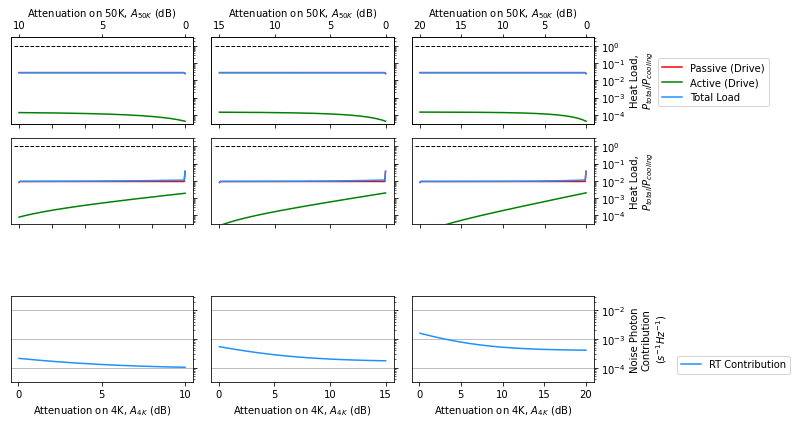

In [10]:
fig = plt.figure(figsize=(12, 6), tight_layout=True)
dgrm_width = 0.25

heights = [1, 1, 0.5, 1]
widths = [dgrm_width, 1, 1, 1]
gs = fig.add_gridspec(4, 4, height_ratios=heights, width_ratios=widths)

xl = [10, 15, 20]

for s in range(3):
    axs = [fig.add_subplot(gs[row, s+1]) for row in [0, 1, 3]]

    #50K=
    axs[0].plot(A[s], FifK_loads[s][:, 0], c='red') #passive
    axs[0].plot(A[s], FifK_loads[s][:, 1], c='green')   #active
    axs[0].plot(A[s], np.sum(FifK_loads[s], axis=1), c='dodgerblue')    #total
    # axs[0].fill_between(A[s], np.sum(FifK_loads[s], axis=1), color='dodgerblue')    #total
    # axs[0].fill_between(A[s], FifK_loads[s][:, 0], color='red') #passive
    # axs[0].fill_between(A[s], FifK_loads[s][:, 1], color='green')   #active
    
    #4K
    axs[1].plot(A[s], FourK_loads[s][:, 0], c='red') #passive
    axs[1].plot(A[s], FourK_loads[s][:, 1], c='green')   #active
    axs[1].plot(A[s], np.sum(FourK_loads[s], axis=1), c='dodgerblue')    #total
    # axs[1].fill_between(A[s], np.sum(FourK_loads[s], axis=1), color='dodgerblue')    #total
    # axs[1].fill_between(A[s], FourK_loads[s][:, 0], color='red') #passive
    # axs[1].fill_between(A[s], FourK_loads[s][:, 1], color='green')   #active
    
    #noise
    # axs[2].plot(A[s], n_data[s])
    cmap = mpl.cm.get_cmap('terrain')
    # axs[2].plot(A[s], n_data[s][:, 0], c='#FFD433')
    # axs[2].plot(A[s], n_data[s][:, 1], c='#FF5733')
    # axs[2].plot(A[s], n_data[s][:, 2], c='#900C3F')
    # axs[2].plot(A[s], n_data[s][:, 5], c='#B833FF')
    axs[2].plot(A[s][1:], np.sum(n_data[s], axis=1)[1:], c='dodgerblue')


    for ax in axs: 
        ax.yaxis.tick_right()
        ax.set_yscale('log')

    for i in range(2):
        axs[i].set_ylim(10**-4.5, 10**0.5)
        axs[i].set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
        if s < 2: axs[i].set_yticklabels([])
        axs[i].set_xticklabels([])

    axs[2].set_ylim(10**-4.5, 10**-1.5)
    axs[2].set_xticks([i for i in range(0, xl[s]+1, 5)])
    axs[2].set_yticks([1e-4, 1e-3, 1e-2])
    if s < 2: axs[2].set_yticklabels([])

    for ax in axs:
        locmin = mpl.ticker.LogLocator(base=10.0,subs=[0.1*(i+1) for i in range(9)],numticks=12)
        ax.yaxis.set_minor_locator(locmin)

    axs2 = axs[0].twiny()
    axs2.set_xlim(axs[0].get_xlim())
    axs2.set_xticks([i for i in range(0, xl[s]+1, 5)])
    axs2.set_xticklabels([str(xl[s] - i) for i in range(0, xl[s]+1, 5)])
    axs2.set_xlabel(r"Attenuation on 50K, $A_{50K}$ (dB)")
    # fig.text(0.3, 0.965, r"Attenuation on 50K, $A_{50K}$ (dB)")
    axs[2].set_xlabel(r"Attenuation on 4K, $A_{4K}$ (dB)")
    axs[0].axhline(1, 0.02, 0.98, lw=1, ls='--', c='k')
    axs[1].axhline(1, 0.02, 0.98, lw=1, ls='--', c='k')

    axs[2].grid(True, which='major', axis='y')

axs[0].set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
axs[1].set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
axs[2].set_yticks([1e-4, 1e-3, 1e-2])

l = axs[0].legend(['Passive (Drive)', 'Active (Drive)', 'Total Load'], loc=(1.35, 0.2))
l = axs[2].legend(['RT Contribution', '50K Contribution', '4K Contribution', 'Total Noise at Device'], loc=(1.45, 0.1))
axs[2].yaxis.set_label_position('right')
axs[2].set_ylabel('Noise Photon\nContribution\n' + r'($s^{-1}Hz^{-1}$)')
axs[0].yaxis.set_label_position('right')
axs[0].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 
axs[1].yaxis.set_label_position('right')
axs[1].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 

# plt.savefig('21.10.19/4Kand50K.png', dpi=400)
plt.savefig('AIPCongress4Kand50K.png', dpi=400, transparent=True)

plt.show()

## How much attenuation is needed to reduce noise photons from each stage down to 10^-3/5

In [2]:
t = fridge_ours['temps'].copy()
l = fridge_ours['labels'].copy()

t.insert(0, 300)
l.insert(0, 'RT')

target = 1e-3/4
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )

n_data = [n_BE(t_i, 6e9) for t_i in t]

A = [-10*np.log10(target/n) for n in n_data]
A.insert(0, np.nan)
A.pop(-1)

c_att = [coax_co_params['219-SS-SS']['att_4'](6)*l for l in fridge_ours['lengths']]
c_att.insert(0, np.nan)

data = {
    'temp': t,
    'n_bar emitted': n_data,
    'n_bar target': [target]*6,
    'req. att. at or below stage': A,
    'att. from cable': c_att,
    'remaining att.': np.array(A) - np.array(c_att)
}

table = pd.DataFrame(data, index=l)
table

,temp,n_bar emitted,n_bar target,req. att. at or below stage,att. from cable,remaining att.
RT,300.000,1.041607e+03,0.00025,NaN,NaN,NaN
50K,46.000,1.592902e+02,0.00025,66.197639,1.50568,64.691959
4K,3.940,1.319242e+01,0.00025,58.042492,2.15006,55.892432
Still,1.227,3.781751e+00,0.00025,47.223846,1.91400,45.309846
CP,0.150,1.719564e-01,0.00025,41.797529,0.95700,40.840529
MXC,0.020,5.607914e-07,0.00025,28.374782,1.41636,26.958422


In [27]:
fig, axs = plt.subplots(figsize=(6, 5))

h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )

t_range = np.linspace(0.070, 0.150, 250)
n_data = n_BE(t_range, 6e9)

target = 1e-3/4
A = -10*np.log10(target/n_data)

axs.plot(t_range*1000, A)

axs2 = axs.twinx()
axs2.plot(t_range*1000, n_data)
axs2.set_yscale('log')
# axs.set_yscale('linear')
lim = (1e-2, 10**-0.5)
axs.set_ylim(-10*np.log10(target/lim[0]),-10*np.log10(target/lim[1]))
axs2.set_ylim(lim)
# axs.set_yticks([i for i in range()])

axs.set_title(r'Required Att. on MXC to bring CP noise down to $\bar{n}=\frac{10^{-3}}{4}$')
axs.set_xlabel('CP temperature (mK)')
axs.set_ylabel('Required Att. on MXC (dB)')
axs2.set_ylabel('Noise Photons Produced at CP')

plt.tight_layout(True)

plt.savefig('21.10.13/MXCAtt for CPtemp.png')

plt.show()

## CP and MXC split with fixed Upper attenuation

In [2]:
A = np.linspace(0, 50, 401, endpoint=True)
configs = [[0, 10, 0, 50-a, a] for a in A]

def config2therm(config):
    therm = [[not (a < 0.001) for a in config[:-1]]+[True]]*2 + [[True, True, True, True, True]]
    return therm

# therm_scheme_drive = [[False, True, False, True, True], #inner
#                   [False, True, False, True, True], #dielectric
#                   [True, True, True, True, True]]   #outer

# therm_scheme_flux = [[False, True, False, False, True], #inner
#                   [False, True, False, False, True], #dielectric
#                   [True, True, True, True, True]]   #outer

# therm_scheme_output = [[True, True, False, False, True], #inner
#                   [True, True, False, False, True], #dielectric
#                   [True, True, True, True, True]]   #outer

# 0dB
therm_scheme_drive = [[True]*5]*3

therm_scheme_flux = [[True]*5]*3

therm_scheme_output = [[True]*5]*3

In [18]:
CP_loads = []
MXC_loads = []
temp_data = []

for conf in configs:

    c_drive = '219-SS-SS'
    c_flux = '219-SS-SS'
    c_out_upper = '119-AgCuNi-CuNi'
    c_out_lower = '119-NbTi-NbTi'

    therm_scheme_drive = config2therm(conf)

    #0dB
#     therm_scheme_drive = [[True]*5]*3

    p_drive = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_drive]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
            therm_scheme=therm_scheme_drive,
            stage_temps=fridge_ours['temps'])

    p_flux = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_flux]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
            therm_scheme=therm_scheme_flux,
            stage_temps=fridge_ours['temps'])

    p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
            diameters=coax_co_params[c_out_lower]['d'],
            lengths=fridge_100q['lengths'],
            therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_out_upper]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out = p_out_upper[0:2].append(p_out_lower[2:])

    a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
            signal_p=1e-3*10**(-5/10), 
            signal_f=6, 
            att=conf,
            cable_att=coax_co_params[c_drive]['att_4'],
            lengths=fridge_ours['lengths'])

    a_dc = active_load_DC(i_in=20e-3, 
                    stage_labels=fridge_ours['labels'], 
                    att=[0, 20, 0, 0, 0], 
                    cable_rho=coax_co_params[c_flux]['rho'], 
                    lengths=fridge_ours['lengths'], 
                    diameters=coax_co_params[c_flux]['d'])

    c_p = np.array(fridge_ours['cool_p'])
    load_matrix = pd.DataFrame(
    [p_drive*14/c_p, a_ac*14*0.33/c_p], 
    index=['Passive (Drive)', 'Active (Drive)']
    )
    CP_loads.append(load_matrix['CP'].to_list())
    MXC_loads.append(load_matrix['MXC'].to_list())

    total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

    total.iloc[0] = t_stages[0](total.iloc[0])
    total.iloc[1] = t_stages[1](total.iloc[1])
    total.iloc[2] = 1.227
    total.iloc[3] = t_stages[2](total.iloc[3])
    total.iloc[4] = t_stages[3](total.iloc[4])

    temp_data.append(total)

CP_loads = np.array(CP_loads)
MXC_loads = np.array(MXC_loads)

C:\Users\13277342_admin\AppData\Local\Temp\ipykernel_12560\575050823.py:45: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_out = p_out_upper[0:2].append(p_out_lower[2:])
C:\Users\13277342_admin\AppData\Local\Temp\ipykernel_12560\575050823.py:45: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_out = p_out_upper[0:2].append(p_out_lower[2:])
C:\Users\13277342_admin\AppData\Local\Temp\ipykernel_12560\575050823.py:45: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_out = p_out_upper[0:2].append(p_out_lower[2:])
C:\Users\13277342_admin\AppData\Local\Temp\ipykernel_12560\575050823.py:45: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_out

In [19]:
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )

n_data = []

for i in range(len(configs)):
    n_bar = n_BE(300, 6e9)
    for ii in range(5):
        att = configs[i][ii] + coax_co_params['219-SS-SS']['att_4'](6)*fridge_ours['lengths'][ii]
        n_bar = n_bar * 10**(-att/10) + (1-10**(-att/10)) * n_BE(temp_data[i][ii], 6e9)
    n_data.append(n_bar)

In [9]:
cond = (A == 40)
np.array(n_data)[np.where(cond)]

array([0.00023015])

In [20]:
# noise contributions
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )

n_data = []

for i in range(len(configs)):
    n_temp = [n_BE(t, 6e9) for t in temp_data[i]]
    att = np.array(configs[i]) + coax_co_params['219-SS-SS']['att_4'](6) * np.array(fridge_ours['lengths'])
    for ii in range(5):
        n_temp[ii] = n_temp[ii] * (1-10**(-att[ii]/10)) * (10**(-np.sum(att[-1:ii:-1])/10))
    n_temp.insert(0, n_BE(300, 6e9)*10**(-np.sum(att)/10))
    n_data.append(n_temp)
#
n_data = np.array(n_data)

In [12]:
n_data

array([[1.67260681e-04, 8.83443165e-06, 4.25160393e-05, 7.80411307e-06,
        3.98987897e-02, 6.51814813e-09],
       [1.67260681e-04, 8.83443165e-06, 4.25160393e-05, 7.80411307e-06,
        3.87667676e-02, 6.99779689e-09],
       [1.67260681e-04, 8.83443165e-06, 4.25160393e-05, 7.80411307e-06,
        3.76668632e-02, 7.46384526e-09],
       ...,
       [1.67260681e-04, 8.83443165e-06, 4.25160393e-05, 7.80411307e-06,
        8.08782762e-08, 2.55399192e-04],
       [1.67260681e-04, 8.83443165e-06, 4.25160393e-05, 7.80411307e-06,
        7.08919003e-08, 2.89670303e-04],
       [1.67260681e-04, 8.83443165e-06, 4.25160393e-05, 7.80411307e-06,
        5.97904325e-08, 4.24526649e-04]])

In [7]:
cond = (A == 40)
np.sum(n_data, axis=1)[np.where(cond)]

array([0.00023015])

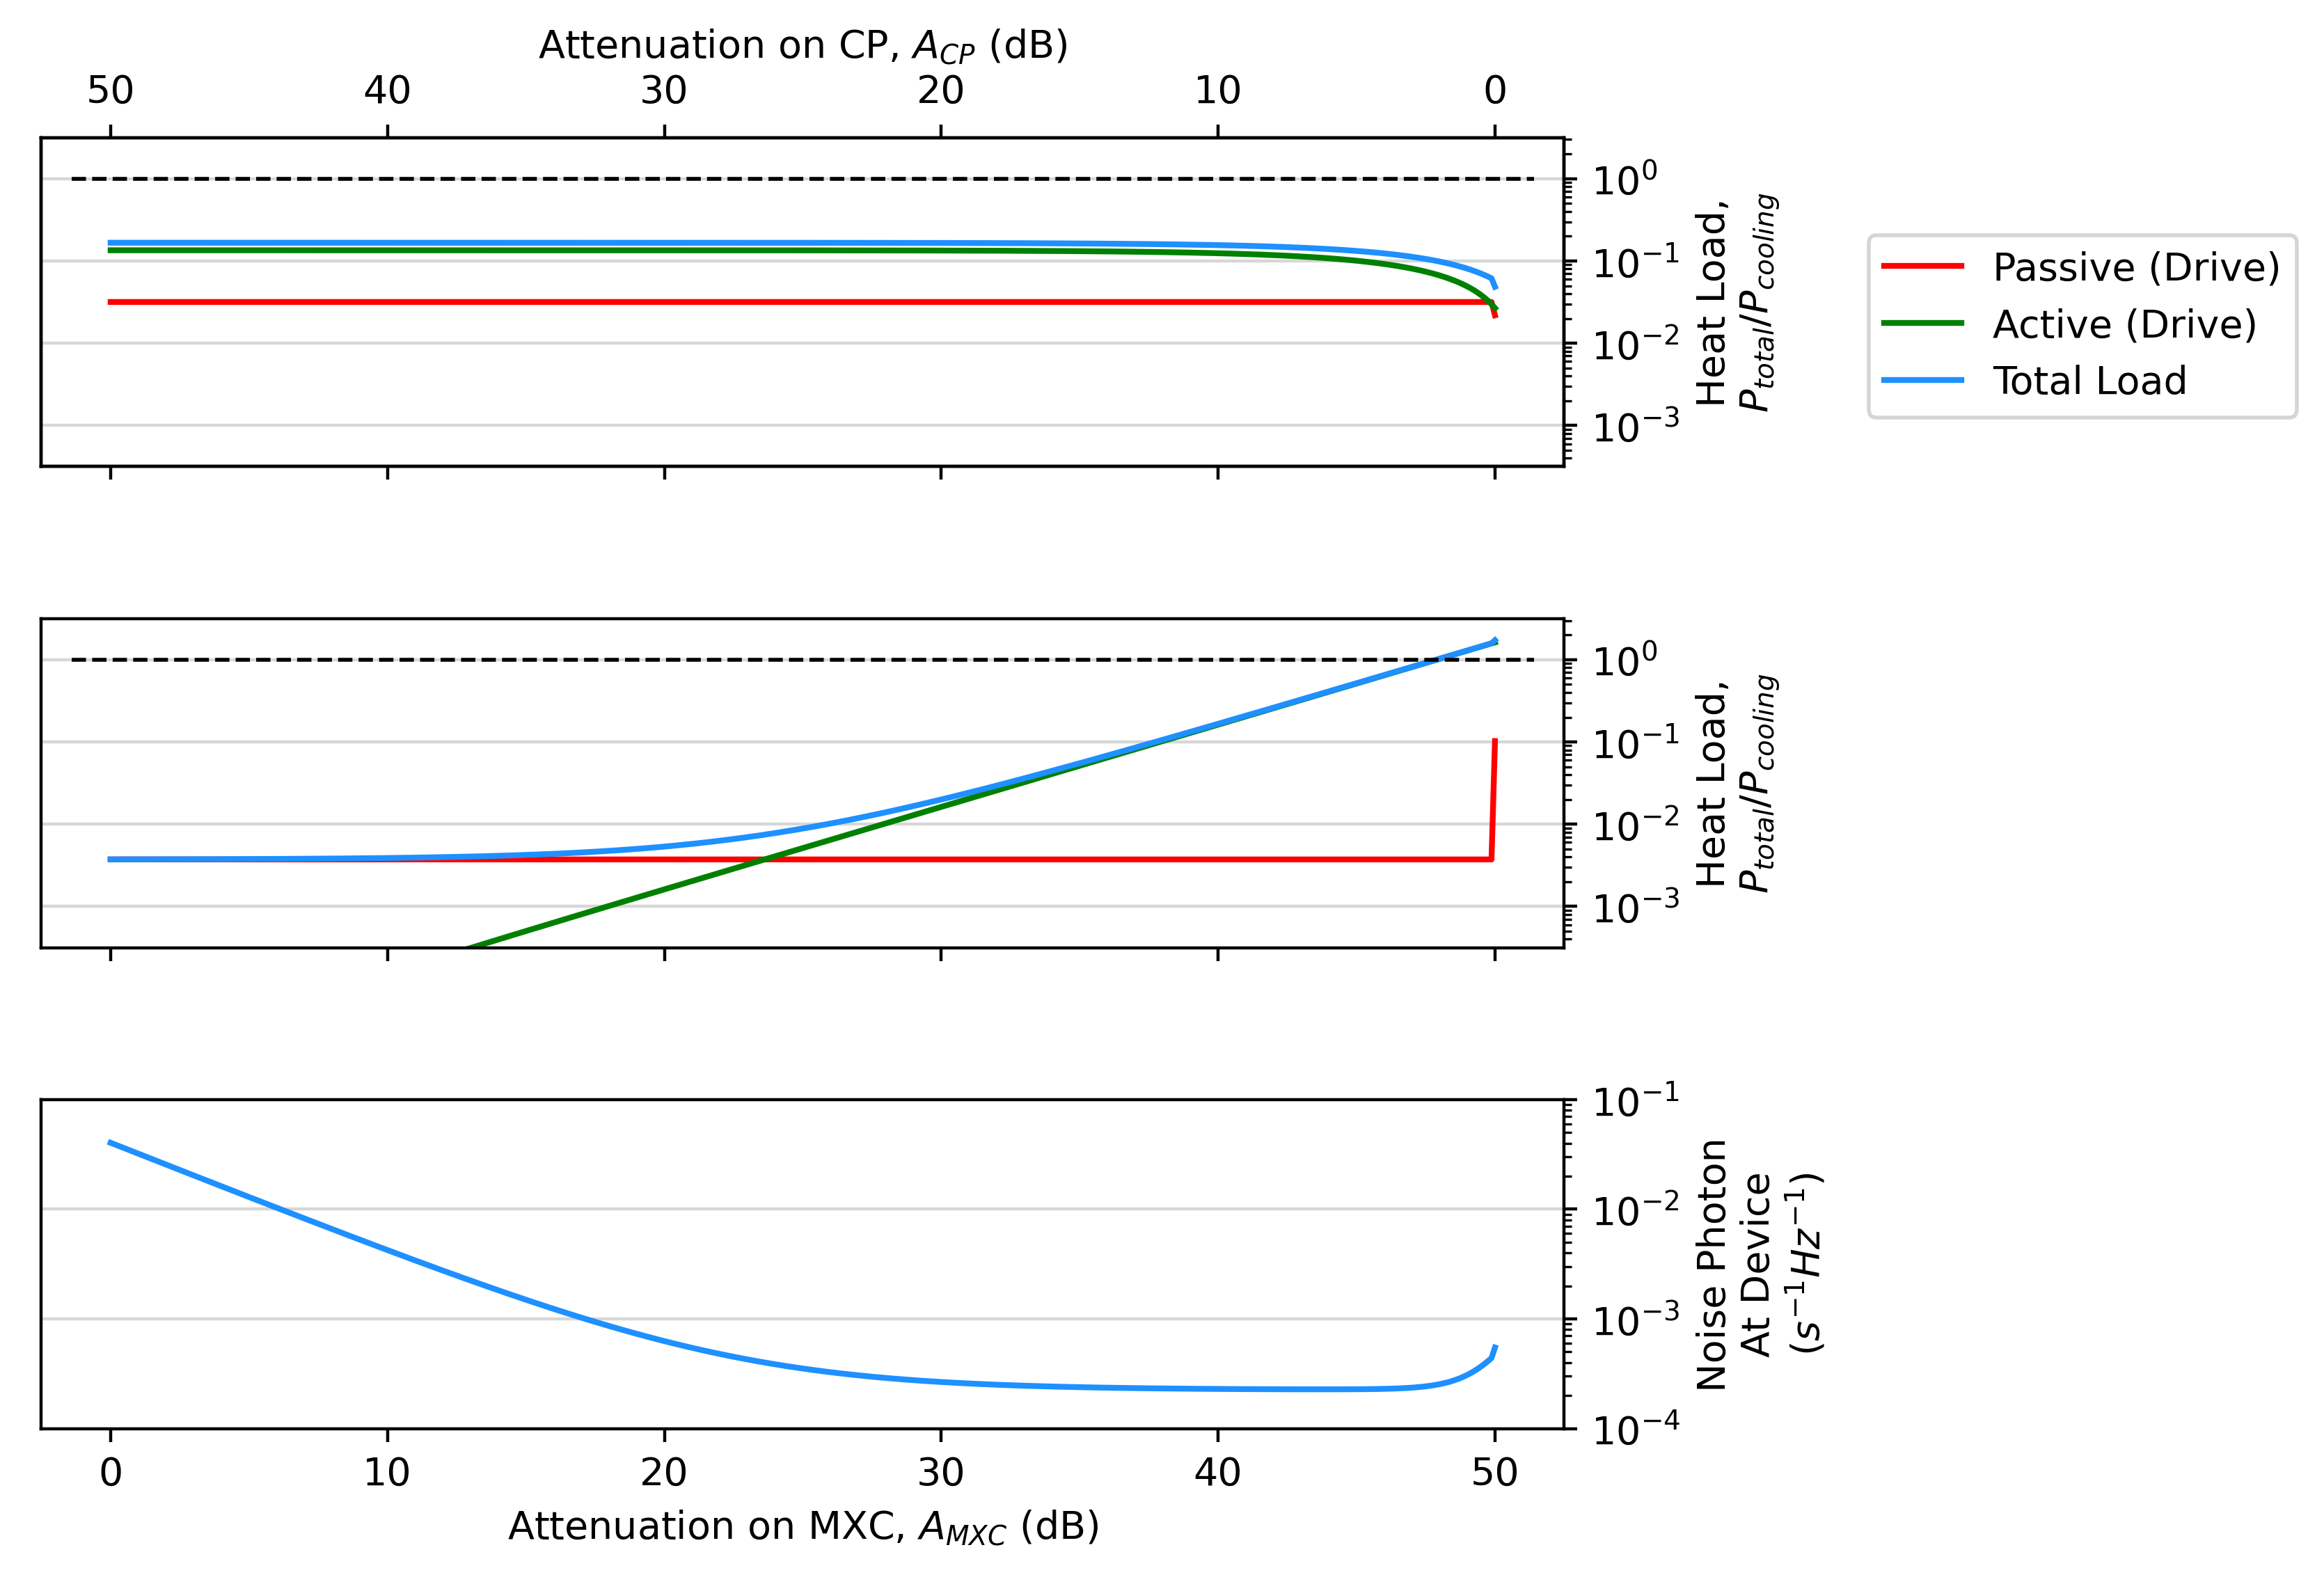

In [21]:
fig = plt.figure(figsize=(10, 6.5), tight_layout=True)
dgrm_width = 0.25

heights = [0.5, 1, 1, 1]
widths = [dgrm_width, 1]
gs = fig.add_gridspec(4, 2, height_ratios=heights, width_ratios=widths)

axs = [fig.add_subplot(gs[row, 1]) for row in [1, 2, 3]]

#CP
axs[0].plot(A, CP_loads[:, 0], color='red') #passive
axs[0].plot(A, CP_loads[:, 1], color='green')   #active
axs[0].plot(A, np.sum(CP_loads, axis=1), color='dodgerblue')    #total
# axs[0].fill_between(A, np.sum(CP_loads, axis=1), color='dodgerblue')    #total
# axs[0].fill_between(A, CP_loads[:, 0], color='red') #passive
# axs[0].fill_between(A, CP_loads[:, 1], color='green')   #active
    
#MXC
axs[1].plot(A, MXC_loads[:, 0], color='red') #passive
axs[1].plot(A, MXC_loads[:, 1], color='green')   #active
axs[1].plot(A, np.sum(MXC_loads, axis=1), color='dodgerblue')    #total
# axs[1].fill_between(A, np.sum(MXC_loads, axis=1), color='dodgerblue')    #total
# axs[1].fill_between(A, MXC_loads[:, 0], color='red') #passive
# axs[1].fill_between(A, MXC_loads[:, 1], color='green')   #active
    
#noise
# axs[2].plot(A, n_data)
cmap = mpl.cm.get_cmap('plasma')
# axs[2].plot(A, n_data[:, 0], color='gold')
# axs[2].plot(A, n_data[:, 2], color='tomato')
# axs[2].plot(A, n_data[:, 4], color='blueviolet')
# axs[2].plot(A, n_data[:, 5], color='darkblue')
axs[2].plot(A, np.sum(n_data, axis=1), color='dodgerblue')

for ax in axs: 
    ax.yaxis.tick_right()
    ax.set_yscale('log')

for i in range(2):
    axs[i].set_ylim(10**-3.5, 10**0.5)
    axs[i].set_yticks([1e-3, 1e-2, 1e-1, 1e0])
    axs[i].set_xticklabels([])

axs[2].set_ylim(10**-4, 10**-1)
# axs[2].set_xticks([i for i in range(0, xl[s]+1, 5)])
axs[2].set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])

for ax in axs:
    locmin = mpl.ticker.LogLocator(base=10.0,subs=[0.1*(i+1) for i in range(9)],numticks=12)
    ax.yaxis.set_minor_locator(locmin)

axs2 = axs[0].twiny()
axs2.set_xlim(axs[0].get_xlim())
axs2.set_xticks([0, 10, 20, 30, 40, 50])
axs2.set_xticklabels([50, 40, 30, 20, 10, 0])
axs2.set_xlabel(r"Attenuation on CP, $A_{CP}$ (dB)")

axs[2].set_xlabel(r"Attenuation on MXC, $A_{MXC}$ (dB)")
axs[0].axhline(1, 0.02, 0.98, lw=1, ls='--', c='k')
axs[1].axhline(1, 0.02, 0.98, lw=1, ls='--', c='k')

# l = axs[0].legend(['1', '2', '3', '4'])
l = axs[0].legend(['Passive (Drive)', 'Active (Drive)', 'Total Load'], loc=(1.2, 0.15))
# l = axs[2].legend(['RT Contribution', '4K Contribution', 'CP Contribution', 'MXC Contribution', 'Total Noise at Device'], loc=(1.2, 0.05))
# # axs[0].legend(l.legendHandles[::-1], ['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'][::-1], loc=(1.2, 0.01))
axs[2].yaxis.set_label_position('right')
axs[2].set_ylabel('Noise Photon\nAt Device\n' + r'($s^{-1}Hz^{-1}$)')
axs[0].yaxis.set_label_position('right')
axs[0].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 
axs[1].yaxis.set_label_position('right')
axs[1].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 

for i in range(3):
    axs[i].grid(True, which='major', axis='y', alpha=0.5)
axs[2].set_ylim(10**-4, 10**-1)

# plt.savefig('21.10.13/MXCandCP.png', dpi=400)
# plt.savefig('AIPCongressMXCandCP.png', dpi=400, transparent=True)

plt.show()

## Flux Line Squares - CP and 4K attenuation on Flux Lines

In [2]:
n = 100
A_CP = np.linspace(30/n, 30, n)
A_4K = np.linspace(30/n, 30, n)

configs = [[[0, b, 0, a, 0] for a in A_CP] for b in A_4K]

therm_scheme_drive = [[False, True, False, True, True], #inner
                  [False, True, False, True, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_flux = [[False, True, False, False, True], #inner
                  [False, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_output = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [3]:
FourK_loads = []
CP_loads = []
temp_data = []

for i in configs:
    temp_4K = []
    temp_CP = []
    temp_temp = []
    for conf in i:

        # if conf[1] <= 60/n*0.95:
        #     temp_4K.append(np.nan)
        #     temp_CP.append(np.nan)
        #     temp_MXC.append(np.nan)
        #     temp_temp.append(np.nan)
        #     continue

        c_drive = '119-CuNi-CuNi'
        c_flux = '119-CuNi-CuNi'
        c_out_upper = '119-AgCuNi-CuNi'
        c_out_lower = '119-NbTi-NbTi'

        p_drive = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_drive]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
                therm_scheme=therm_scheme_drive,
                stage_temps=fridge_ours['temps'])

        p_flux = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_flux]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
                therm_scheme=therm_scheme_flux,
                stage_temps=fridge_ours['temps'])

        p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
                diameters=coax_co_params[c_out_lower]['d'],
                lengths=fridge_100q['lengths'],
                therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
                therm_scheme=therm_scheme_output,
                stage_temps=fridge_ours['temps'])

        p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_out_upper]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
                therm_scheme=therm_scheme_output,
                stage_temps=fridge_ours['temps'])

        p_out = p_out_upper[0:2].append(p_out_lower[2:])

        a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
                signal_p=1e-3*10**(-5/10), 
                signal_f=6, 
                att=[0, 10, 0, 10, 40],
                cable_att=coax_co_params[c_drive]['att_4'],
                lengths=fridge_ours['lengths'])

        i_in = 2e-3*10**(np.sum(conf)/20)

        a_dc = active_load_DC(i_in=i_in, 
                        stage_labels=fridge_ours['labels'], 
                        att=conf, 
                        cable_rho=coax_co_params[c_flux]['rho'], 
                        lengths=fridge_ours['lengths'], 
                        diameters=coax_co_params[c_flux]['d'])
        
        c_p = np.array(fridge_ours['cool_p'])
        load = a_dc*14*1/c_p
        
        temp_4K.append(load['4K'])
        temp_CP.append(load['CP'])

        total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

        total.iloc[0] = t_stages[0](total.iloc[0])
        total.iloc[1] = t_stages[1](total.iloc[1])
        total.iloc[2] = 1.227
        total.iloc[3] = t_stages[2](total.iloc[3])
        total.iloc[4] = t_stages[3](total.iloc[4])

        temp_temp.append(total.to_list())

    FourK_loads.append(temp_4K)
    CP_loads.append(temp_CP)
    temp_data.append(temp_temp)

In [ ]:
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f: h * f / ( np.exp( h*f / (k_B*T) ) - 1 ) / 50

n_data = []

for i in range(len(configs)):
    temp = []
    for ii in range(len(configs[0])):
        n_bar = n_BE(300, 1e6)
        for iii in range(5):
            n_bar = n_bar * 10**(-configs[i][ii][iii]/10) + (1-10**(-configs[i][ii][iii]/10)) * n_BE(temp_data[i][ii][iii], 1e6)
        temp.append(n_bar)
    n_data.append(temp)

In [1]:
fig, axs = plt.subplots(1, 3, figsize =(12, 3.1))

X, Y = np.meshgrid(A_CP, A_4K)

data = [np.array(FourK_loads), np.array(CP_loads), np.array(n_data)]

c = axs[0].pcolormesh(X, Y, data[0], norm=LogNorm(vmin=data[0].min(), vmax=data[0].max()), cmap='plasma')
cb = fig.colorbar(c, ax=axs[0])
cb.set_label(r'Active Heat Load, $P/P_{cooling}$')

threshold = 0.05
upper, lower = 1 + threshold, 1 - threshold
d = ((data[0]<upper) * (data[0]>lower) * 1).astype('float')
d[d!=1] = np.nan
axs[0].pcolormesh(X, Y, d, cmap='Pastel1')

c = axs[1].pcolormesh(X, Y, data[1], norm=LogNorm(vmin=data[1].min(), vmax=data[1].max()), cmap='plasma')
cb = fig.colorbar(c, ax=axs[1])
cb.set_label(r'Active Heat Load, $P/P_{cooling}$')

threshold = 0.3
upper, lower = 1 + threshold, 1 - threshold
d = ((data[1]<upper) * (data[1]>lower) * 1).astype('float')
d[d!=1] = np.nan
axs[1].pcolormesh(X, Y, d, cmap='Pastel1')

c = axs[-1].pcolormesh(X, Y, data[-1], norm=LogNorm(vmin=data[-1].min(), vmax=data[-1].max()), cmap='viridis')
cb = fig.colorbar(c, ax=axs[-1])
cb.set_label(r'Noise Current, $I^2 (A^2Hz^{-1})$')

for ax in axs:
    ax.set_xlabel('CP Attenuation (dB)')
    ax.set_ylabel('4K Attenuation (dB)')
    ax.set_xticks([0, 5, 10, 15, 20, 25, 30])
    ax.set_yticks([0, 5, 10, 15, 20, 25, 30])

axs[0].set_title('4K Heat Load')
axs[1].set_title('CP Heat Load')
axs[2].set_title('Noise Current')

plt.tight_layout(True)

plt.savefig('21.10.13/Flux Squares.png', dpi=500)

plt.show()

NameError: name 'plt' is not defined

In [ ]:
fig = plt.figure(figsize=(12, 8.5), tight_layout=True)
dgrm_width = 0.3

widths = [dgrm_width, 1, 1]
gs = fig.add_gridspec(2, 3, width_ratios=widths)

axs = []
axs.append(fig.add_subplot(gs[0, 1]))
axs.append(fig.add_subplot(gs[0, 2]))
axs.append(fig.add_subplot(gs[1, 1]))
axs.append(fig.add_subplot(gs[1, 2]))

X, Y = np.meshgrid(A_MXC, A_CP)

dat = [FourK_loads, CP_loads, MXC_loads]
titles = ['4K', 'CP', 'MXC']
lims = [(0.595, 0.59), (0, 0.8), (0, 6)]
colours = [('k', 'k', 'k'), ('k', 'w', 'w'), ('k', 'w', 'w'), ('k', 'w', 'w')]

for i in range(4):
    axs[i].plot([0, 60], [60+60/n, 0+60/n], lw=3.5, c='w')
    axs[i].plot([0, 60], [60, 0], lw=0.5, c='k')

    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)

    axs[i].plot([0, 40], [40, 0], lw=0.5, c='k')
    axs[i].plot([0, 20], [20, 0], lw=0.5, c='k')

    axs[i].annotate(r'$A_{4K}=$0dB', (8, 54), size=8, c=colours[i][0])
    axs[i].annotate(r'$A_{4K}=$20dB', (8, 34), size=8, c=colours[i][1])
    axs[i].annotate(r'$A_{4K}=$40dB', (8, 14), size=8, c=colours[i][2])

    axs[i].set_xlim(0, 60)
    axs[i].set_ylim(0, 60)
    axs[i].set_xlabel("CP Attenuation (dB)")
    axs[i].set_ylabel("MXC Attenuation (dB)")

for i in range(3):


    c = axs[i].pcolormesh(X, Y, np.array(dat[i]), cmap='plasma', vmin=lims[i][0], vmax=lims[i][1])
    cb = fig.colorbar(c, ax=axs[i])
    axs[i].set_title('Heat Load on ' + titles[i])
    cb.set_label(r'Heat Load, $P_{total}/P_{cooling}$')

In [3]:
A = np.linspace(0, 1, 100, endpoint=False)
data = [
    active_load_DC(
    i_in=2e-3*10**(a/20), 
    stage_labels=fridge_ours['labels'], 
    att=[0, 0, 0, a, 0], 
    cable_rho=coax_co_params['119-CuNi-CuNi']['rho'], 
    lengths=fridge_ours['lengths'], 
    diameters=coax_co_params['119-CuNi-CuNi']['d']
    )['CP']*14 / 300e-6 for a in A
]
plt.figure(figsize=(4, 4))
plt.plot(A, data)
plt.xlabel('CP attenuation')
plt.ylabel(r'Active Flux Load $P/P_{cooling}$')
plt.hlines(1, 0, 0.39, 'r', 'dashed')
plt.vlines(0.39, 0, 1, 'r', 'dashed')
plt.tight_layout(True)

plt.savefig('21.10.13/CP Flux Att Threshold.png')
plt.show()

## T2 from flux noise

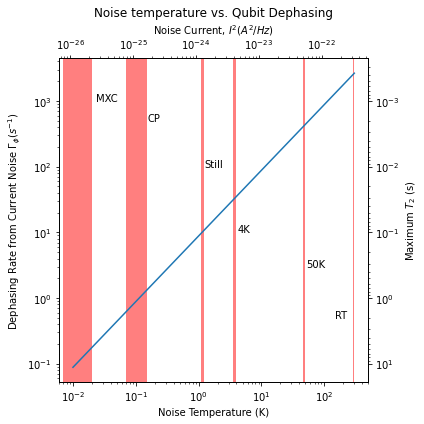

In [3]:
T = np.logspace(-2, np.log10(300), 200)

k_B = 1.381e-23
D_I = 4e12
S_eff = lambda t: 4 * k_B * t / 50
T2 = lambda s: 2 / (D_I**2 * s)

s_data = S_eff(T)
T2_data = T2(s_data)
gamma = 1 / T2_data

fig, axs = plt.subplots(figsize=(6, 6))
axs.plot(T, gamma)
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_yticks([1e-1, 1e0, 1e1, 1e2, 1e3])
axs.set_xlabel('Noise Temperature (K)')
axs.set_ylabel(r'Dephasing Rate from Current Noise $\Gamma_{\phi}  (s^{-1})$')

axs2 = axs.twinx()
axs3 = axs.twiny()

axs2.set_yscale('log')
axs2.set_ylim(1 / np.array(axs.get_ylim()))
axs2.set_yticks([1/i for i in axs.get_yticks()])
axs2.set_ylabel(r'Maximum $T_2$ (s)')

axs3.set_xscale('log')
axs3.set_xlim(S_eff(np.array(axs.get_xlim())))
# axs3.set_xticks([S_eff(i) for i in axs.get_xticks()])
axs3.set_xlabel(r'Noise Current, $I^2   (A^2/Hz)$')

temps = [(7e-3, 20e-3), (70e-3, 150e-3), (3.5, 4), (1.1, 1.227), (45, 50), (290, 300)]
h = axs.get_ylim()[1] - axs.get_ylim()[0]
hm = (axs.get_ylim()[1] + axs.get_ylim()[0])/2
for i in range(6):
    w = temps[i][1] - temps[i][0]
    wm = (temps[i][1] + temps[i][0]) / 2
    b = mpl.patches.Rectangle((wm-w/2, hm-h/2), w, h, facecolor='r', lw=2, alpha=0.5, zorder=-1)
    axs.add_patch(b)

axs.annotate('MXC', (0.023, 1e3))
axs.annotate('CP', (0.153, 0.5e3))
axs.annotate('Still', (1.25, 0.1e3))
axs.annotate('4K', (4.2, 0.1e2))
axs.annotate('50K', (52, 0.3e1))
axs.annotate('RT', (150, 0.5e0))

axs.set_title('Noise temperature vs. Qubit Dephasing')
plt.tight_layout()

plt.savefig('21.10.18/Flux Noise Temp.png', dpi=400, transparent=True)

plt.show()

## Flux Squares 2 - Can we put attenuators below the 4K plate?

In [2]:
n = 100
A_4K = np.linspace(0, 30, n+1)
A_lower = np.linspace(0, 10, n+1)

configs = [
    [[[0, a, b, 0, 0] for a in A_4K] for b in A_lower],
    [[[0, a, 0, b, 0] for a in A_4K] for b in A_lower],
    [[[0, a, 0, 0, b] for a in A_4K] for b in A_lower]
]

def config2therm(config):
    therm = [[not (a < 0.001) for a in config[:-1]]+[True]]*2 + [[True, True, True, True, True]]
    return therm

# therm_scheme_drive = [[False, True, False, True, True], #inner
#                   [False, True, False, True, True], #dielectric
#                   [True, True, True, True, True]]   #outer

# therm_scheme_output = [[True, True, False, False, True], #inner
#                   [True, True, False, False, True], #dielectric
#                   [True, True, True, True, True]]   #outer

## 0dB attenuators

therm_scheme_drive = [[True]*5]*3 #inner

therm_scheme_output = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [3]:
FourK_loads = [[], [], []]
lower_loads = [[], [], []]
temp_data = [[], [], []]

for ii in range(3):
    for i in configs[ii]:
        temp_4K = []
        temp_lower = []
        temp_temp = []
        for conf in i:

            c_drive = '219-SS-SS'
            c_flux = '219-CuNi-CuNi'
            c_out_upper = '119-AgCuNi-CuNi'
            c_out_lower = '119-NbTi-NbTi'

            # therm_scheme_flux = config2therm(conf)

            #0dB attenuators
            therm_scheme_flux = [[True]*5]*3

            p_drive = passive_load(stage_labels=fridge_ours['labels'], 
                    diameters=coax_co_params[c_drive]['d'],
                    lengths=fridge_ours['lengths'],
                    therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
                    therm_scheme=therm_scheme_drive,
                    stage_temps=fridge_ours['temps'])

            p_flux = passive_load(stage_labels=fridge_ours['labels'], 
                    diameters=coax_co_params[c_flux]['d'],
                    lengths=fridge_ours['lengths'],
                    therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
                    therm_scheme=therm_scheme_flux,
                    stage_temps=fridge_ours['temps'])

            p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
                    diameters=coax_co_params[c_out_lower]['d'],
                    lengths=fridge_100q['lengths'],
                    therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
                    therm_scheme=therm_scheme_output,
                    stage_temps=fridge_ours['temps'])

            p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
                    diameters=coax_co_params[c_out_upper]['d'],
                    lengths=fridge_ours['lengths'],
                    therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
                    therm_scheme=therm_scheme_output,
                    stage_temps=fridge_ours['temps'])

            p_out = p_out_upper[0:2].append(p_out_lower[2:])

            a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
                    signal_p=1e-3*10**(-5/10), 
                    signal_f=6, 
                    att=[0, 10, 0, 10, 40],
                    cable_att=coax_co_params[c_drive]['att_4'],
                    lengths=fridge_ours['lengths'])

            i_in = 2e-3*10**(np.sum(conf)/20)

            a_dc = active_load_DC(i_in=i_in, 
                            stage_labels=fridge_ours['labels'], 
                            att=conf, 
                            cable_rho=coax_co_params[c_flux]['rho'], 
                            lengths=fridge_ours['lengths'], 
                            diameters=coax_co_params[c_flux]['d'])
            
            c_p = np.array(fridge_ours['cool_p'])
            load_matrix = p_flux*14/c_p + a_dc*14*1/c_p

            cable_rho = coax_co_params[c_flux]['rho'] 
            lengths = fridge_ours['lengths']
            diameters = coax_co_params[c_flux]['d']
            A_inner = np.pi*(diameters[0]/2)**2

            R_CP =  (
                0.42
                * (cable_rho / 7.2e-7)
                * (lengths[-2]/0.17)
                * (np.pi*(0.511e-3/2)**2 / A_inner)
            )
            R_MXC =  (
                0.15
                * (cable_rho / 7.2e-7)
                * (lengths[-1]/0.14)
                * (np.pi*(0.511e-3/2)**2 / A_inner)
            )
    
            R_eff = [0, 0, 0, R_CP, R_MXC]
            I = [0.002]
            for t in range(5):
                I.append(I[t]*10**(conf[-t-1]/20))
            I = I[-1:0:-1]
            ohm_dc = np.array(I)**2 * np.array(R_eff)
            ohm_dc = pd.Series(ohm_dc, index=fridge_ours['labels'])

            load_matrix = pd.DataFrame(
            [p_flux*14/c_p, a_dc*14*1/c_p, (a_dc-ohm_dc)*14/c_p, ohm_dc*14/c_p], 
            index=['Passive (Flux)', 'Active (Flux)', 'Att. (Flux)', 'Ohmic (Flux)']
            )
            
            temp_4K.append((p_flux*14/c_p + a_dc*14*1/c_p)['4K'])
            temp_lower.append(load_matrix.iloc[:, ii+2])

            total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

            total.iloc[0] = t_stages[0](total.iloc[0])
            total.iloc[1] = t_stages[1](total.iloc[1])
            total.iloc[2] = 1.227
            total.iloc[3] = t_stages[2](total.iloc[3])
            total.iloc[4] = t_stages[3](total.iloc[4])

            temp_temp.append(total.to_list())

        FourK_loads[ii].append(temp_4K)
        lower_loads[ii].append(temp_lower)
        temp_data[ii].append(temp_temp)

In [9]:
lower_loads[2]

[[Passive (Flux)    0.005467
  Active (Flux)     0.348237
  Att. (Flux)       0.000000
  Ohmic (Flux)      0.348237
  Name: MXC, dtype: float64,
  Passive (Flux)    0.005467
  Active (Flux)     0.348237
  Att. (Flux)       0.000000
  Ohmic (Flux)      0.348237
  Name: MXC, dtype: float64,
  Passive (Flux)    0.005467
  Active (Flux)     0.348237
  Att. (Flux)       0.000000
  Ohmic (Flux)      0.348237
  Name: MXC, dtype: float64,
  Passive (Flux)    0.005467
  Active (Flux)     0.348237
  Att. (Flux)       0.000000
  Ohmic (Flux)      0.348237
  Name: MXC, dtype: float64,
  Passive (Flux)    5.466687e-03
  Active (Flux)     3.482366e-01
  Att. (Flux)       1.482308e-16
  Ohmic (Flux)      3.482366e-01
  Name: MXC, dtype: float64,
  Passive (Flux)    5.466687e-03
  Active (Flux)     3.482366e-01
  Att. (Flux)       1.482308e-16
  Ohmic (Flux)      3.482366e-01
  Name: MXC, dtype: float64,
  Passive (Flux)    5.466687e-03
  Active (Flux)     3.482366e-01
  Att. (Flux)       1.482308e-16

In [4]:
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f: 4*k_B*T/ 50

n_data = [[], [], []]
for c in range(3):
    for i in range(len(configs[c])):
        temp = []
        for ii in range(len(configs[c][0])):
            n_bar = n_BE(300, 1e5)
            for iii in range(5):
                n_bar = n_bar * 10**(-configs[c][i][ii][iii]/10) + (1-10**(-configs[c][i][ii][iii]/10)) * n_BE(temp_data[c][i][ii][iii], 1e5)
            temp.append(n_bar)
        n_data[c].append(temp)

ValueError: Passing parameters norm and vmin/vmax simultaneously is not supported. Please pass vmin/vmax directly to the norm when creating it.

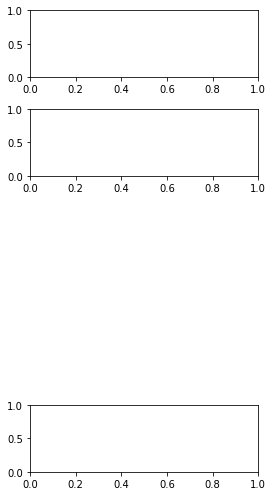

In [5]:
fig = plt.figure(figsize=(12, 7), tight_layout=True)
dgrm_width = 0.25

heights = [1, 1, 1, 1, 1]
widths = [dgrm_width, 1, 1, 1]
gs = fig.add_gridspec(5, 4, height_ratios=heights, width_ratios=widths)

X, Y = np.meshgrid(A_4K, A_lower)

data = [np.array(FourK_loads), lower_loads, np.array(n_data)]
cbs = []

for i in range(3):
    axs = [fig.add_subplot(gs[row, i+1]) for row in [0, i+1, 4]]

    c = axs[0].pcolormesh(X, Y, data[0][i], norm=LogNorm(vmin=data[0][i].min(), vmax=data[0][i].max()), vmin=1e-3, vmax=1e1, cmap='plasma')
    cb = fig.colorbar(c, ax=axs[0])
    if i == 2: cb.set_label('Active Heat\nLoad,' +  r'$P/P_{cooling}$')
    axs[0].set_xlabel('4K Att.')
    axs[0].set_ylabel(fridge_ours['labels'][i+2] + ' Att.')

    axs[1].plot(A_lower, data[1][i][:, 0])
    axs
    axs[1].set_yscale('log')
    axs[1].set_ylim([1e-1, 1e1])
    axs[1].set_yticks([1e-1, 1e0, 1e1])
    axs[1].set_xlabel(fridge_ours['labels'][i+2] + ' Attenuation, dB')

    c = axs[2].pcolormesh(X, Y, data[2][i], norm=LogNorm(vmin=data[2][i].min(), vmax=data[2][i].max()), vmin=1e-24, vmax=1e-22, cmap='viridis')
    cb = fig.colorbar(c, ax=axs[2])
    if i == 2: cb.set_label('Noise Current,\n'+r'$I^2 (A^2Hz^{-1})$')
    axs[2].set_xlabel('4K Att.')
    axs[2].set_ylabel(fridge_ours['labels'][i+2] + ' Att.')

# plt.savefig('21.10.18/FluxSquares2.png')

plt.show()

## Can you put att below 4K 2

In [14]:
n = 1000
A_lower = np.linspace(0, 10, n+1)

configs = [
    [[0, 20, a, 0, 0] for a in A_lower],
    [[0, 20, 0, a, 0] for a in A_lower],
    [[0, 20, 0, 0, a] for a in A_lower]
]

def config2therm(config):
    therm = [[not (a < 0.001) for a in config[:-1]]+[True]]*2 + [[True, True, True, True, True]]
    return therm

# therm_scheme_drive = [[False, True, False, True, True], #inner
#                   [False, True, False, True, True], #dielectric
#                   [True, True, True, True, True]]   #outer

# therm_scheme_output = [[True, True, False, False, True], #inner
#                   [True, True, False, False, True], #dielectric
#                   [True, True, True, True, True]]   #outer

#0dB
therm_scheme_drive = [[True]*5]*3

therm_scheme_output = [[True]*5]*3

In [49]:
lower_loads = [[], [], []]
temp_data = [[], [], []]

for ii in range(3):
    for conf in configs[ii]:

        c_drive = '219-SS-SS'
        c_flux = '219-CuNi-CuNi'
        c_out_upper = '119-AgCuNi-CuNi'
        c_out_lower = '119-NbTi-NbTi'

        therm_scheme_flux = config2therm(conf)

        #0dB
        # therm_scheme_flux = [[True]*5]*3

        p_drive = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_drive]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
                therm_scheme=therm_scheme_drive,
                stage_temps=fridge_ours['temps'])

        p_flux = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_flux]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
                therm_scheme=therm_scheme_flux,
                stage_temps=fridge_ours['temps'])

        p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
                diameters=coax_co_params[c_out_lower]['d'],
                lengths=fridge_100q['lengths'],
                therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
                therm_scheme=therm_scheme_output,
                stage_temps=fridge_ours['temps'])

        p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_out_upper]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
                therm_scheme=therm_scheme_output,
                stage_temps=fridge_ours['temps'])

        p_out = p_out_upper[0:2].append(p_out_lower[2:])

        a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
                signal_p=1e-3*10**(-5/10), 
                signal_f=6, 
                att=[0, 10, 0, 10, 40],
                cable_att=coax_co_params[c_drive]['att_4'],
                lengths=fridge_ours['lengths'])

        # i_in = 2e-3*10**(np.sum(conf)/20)

        #0dB
        i_in = 1e-3*10**(np.sum(conf)/20)

        a_dc = active_load_DC(i_in=i_in, 
                        stage_labels=fridge_ours['labels'], 
                        att=conf, 
                        cable_rho=coax_co_params[c_flux]['rho'], 
                        lengths=fridge_ours['lengths'], 
                        diameters=coax_co_params[c_flux]['d'])
        
        c_p = np.array(fridge_ours['cool_p'])
        load_matrix = p_flux*14/c_p + a_dc*14*1/c_p

        cable_rho = coax_co_params[c_flux]['rho'] 
        lengths = fridge_ours['lengths']
        diameters = coax_co_params[c_flux]['d']
        A_inner = np.pi*(diameters[0]/2)**2

        R_CP =  (
        0.42
        * (cable_rho / 7.2e-7)
        * (lengths[-2]/0.17)
        * (np.pi*(0.511e-3/2)**2 / A_inner)
        )
        R_MXC =  (
        0.15
        * (cable_rho / 7.2e-7)
        * (lengths[-1]/0.14)
        * (np.pi*(0.511e-3/2)**2 / A_inner)
        )

        R_eff = [0, 0, 0, R_CP, R_MXC]
        I = [0.002]
        for t in range(5):
            I.append(I[t]*10**(conf[-t-1]/20))
        I = I[-1:0:-1]
        ohm_dc = np.array(I)**2 * np.array(R_eff)
        ohm_dc = pd.Series(ohm_dc, index=fridge_ours['labels'])

        load_matrix = pd.DataFrame(
        [p_flux*14/c_p, (a_dc-ohm_dc)*14/c_p, ohm_dc*14/c_p], 
        index=['Passive (Flux)', 'Att. (Flux)', 'Ohmic (Flux)']
        )
        
        lower_loads[ii].append(load_matrix.iloc[:, ii+2])

        total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

        total.iloc[0] = t_stages[0](total.iloc[0])
        total.iloc[1] = t_stages[1](total.iloc[1])
        total.iloc[2] = 1.227
        total.iloc[3] = t_stages[2](total.iloc[3])
        total.iloc[4] = t_stages[3](total.iloc[4])

        temp_data[ii].append(total.to_list())

lower_loads = [pd.DataFrame(l).T.to_numpy() for l in lower_loads]

In [32]:
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f: 4*k_B*T / 50

n_data = [[], [], []]
for c in range(3):
    for i in range(len(configs[c])):
        n_bar = n_BE(300, 1e5)
        for ii in range(5):
            n_bar = n_bar * 10**(-configs[c][i][ii]/10) + (1-10**(-configs[c][i][ii]/10)) * n_BE(temp_data[c][i][ii], 1e5)
        n_data[c].append(n_bar)

In [33]:
# noise contributions
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f:  4*k_B*T / 50

n_data = [[], [], []]

for c in range(3):
    for i in range(len(configs[c])):
        n_temp = [n_BE(t, 1e5) for t in temp_data[c][i]]
        for ii in range(5):
            n_temp[ii] = n_temp[ii] * (1-10**(-configs[c][i][ii]/10)) * (10**(-np.sum(configs[c][i][-1:ii:-1])/10))
        n_temp.insert(0, n_BE(300, 1e5)*10**(-np.sum(configs[c][i])/10))
        n_data[c].append(n_temp)
#
n_data = np.array(n_data)

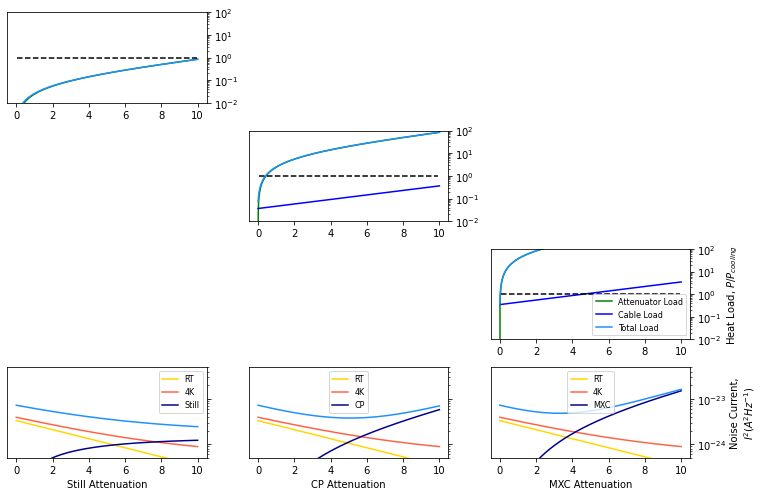

In [23]:
fig = plt.figure(figsize=(12, 7), tight_layout=True)
dgrm_width = 0.25

heights = [1, 1, 1, 1]
widths = [dgrm_width, 1, 1, 1]
gs = fig.add_gridspec(4, 4, height_ratios=heights, width_ratios=widths)

for i in range(3):
    axs = [fig.add_subplot(gs[row, i+1]) for row in [i, 3]]

    # axs[0].plot(A_lower, lower_loads[i][0, :], c='r')
    axs[0].plot(A_lower, lower_loads[i][1, :], c='green')
    axs[0].plot(A_lower, lower_loads[i][2, :], c='blue')
    axs[0].plot(A_lower, np.sum(lower_loads[i], axis=0), c='dodgerblue')
    axs[0].set_yscale('log')
    axs[0].set_ylim([1e-2, 1e2])
    axs[0].set_yticks([1e-2, 1e-1, 1e0, 1e1, 1e2])
    # axs[0].set_ylabel(fridge_ours['labels'][i+2] + ' Attenuation, dB')
    
    locmin = mpl.ticker.LogLocator(base=10.0,subs=[0.1*(i+1) for i in range(9)],numticks=12)
    axs[0].yaxis.set_minor_locator(locmin)

    axs[0].axhline(1, 0.05, 0.95, linestyle='dashed', color='k')

    axs[1].plot(A_lower, n_data[i][:, 0], c='gold')
    axs[1].plot(A_lower, n_data[i][:, 2], c='tomato')
    axs[1].plot(A_lower, n_data[i][:, i+3], c='darkblue')
    axs[1].plot(A_lower, np.sum(n_data[i], axis=1), c='dodgerblue')
    axs[1].set_yscale('log')
    axs[1].set_ylim([5e-25, 5e-23])
    axs[1].set_yticks([1e-24, 1e-23])
    axs[1].set_yticklabels([], minor=True)
    axs[1].legend(['RT', '4K', fridge_ours['labels'][i+2]], fontsize=8)
    if i == 2: 
        axs[0].set_ylabel(r'Heat Load, $P/P_{cooling}$')
        axs[0].legend(['Attenuator Load', 'Cable Load', 'Total Load'], fontsize=8)
        axs[1].set_ylabel('Noise Current,\n'+r'$I^2 (A^2Hz^{-1})$')
    else:
        axs[1].set_yticklabels([])
    # axs[2].set_xlabel('4K Att.')
    axs[1].set_xlabel(fridge_ours['labels'][i+2] + ' Attenuation')

    for ax in axs: 
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')


# plt.savefig('21.11.03/FluxSquares2.png')

plt.show()

In [55]:
np.sum(lower_loads[1], axis=0)[140:200]

array([0.94654106, 0.95399477, 0.96146566, 0.96895377, 0.97645915,
       0.98398182, 0.99152184, 0.99907924, 1.00665406, 1.01424635,
       1.02185613, 1.02948346, 1.03712837, 1.0447909 , 1.0524711 ,
       1.060169  , 1.06788465, 1.07561808, 1.08336935, 1.09113848,
       1.09892552, 1.10673051, 1.11455349, 1.12239451, 1.1302536 ,
       1.13813081, 1.14602618, 1.15393975, 1.16187156, 1.16982166,
       1.17779008, 1.18577687, 1.19378208, 1.20180573, 1.20984789,
       1.21790858, 1.22598786, 1.23408576, 1.24220232, 1.2503376 ,
       1.25849163, 1.26666446, 1.27485613, 1.28306668, 1.29129617,
       1.29954462, 1.30781208, 1.31609861, 1.32440423, 1.33272901,
       1.34107297, 1.34943617, 1.35781865, 1.36622045, 1.37464162,
       1.3830822 , 1.39154224, 1.40002178, 1.40852087, 1.41703955])

## Flux Line 4K and 50K split

In [2]:
n = 100+2
A_4K = np.linspace(0, 20, n)
A_50K = np.linspace(0, 20, n)

configs = [[[b, a, 0, 0, 0] for a in A_4K] for b in A_50K]

def config2therm(config):
    therm = [[not (a < 0.001) for a in config]]*2 + [[True, True, True, True, True]]
    return therm

therm_scheme_drive = [[False, True, False, True, True], #inner
                  [False, True, False, True, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_flux = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_output = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [3]:
FourK_loads = []
FifK_loads = []
temp_data = []

for i in configs:
    temp_4K = []
    temp_50K = []
    temp_temp = []
    for conf in i:

        # if conf[1] <= 60/n*0.95:
        #     temp_4K.append(np.nan)
        #     temp_CP.append(np.nan)
        #     temp_MXC.append(np.nan)
        #     temp_temp.append(np.nan)
        #     continue

        therm_scheme_flux = config2therm(conf)

        c_drive = '219-SS-SS'
        c_flux = '219-CuNi-CuNi'
        c_out_upper = '119-AgCuNi-CuNi'
        c_out_lower = '119-NbTi-NbTi'

        p_drive = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_drive]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
                therm_scheme=therm_scheme_drive,
                stage_temps=fridge_ours['temps'])

        p_flux = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_flux]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
                therm_scheme=therm_scheme_flux,
                stage_temps=fridge_ours['temps'])

        p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
                diameters=coax_co_params[c_out_lower]['d'],
                lengths=fridge_100q['lengths'],
                therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
                therm_scheme=therm_scheme_output,
                stage_temps=fridge_ours['temps'])

        p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_out_upper]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
                therm_scheme=therm_scheme_output,
                stage_temps=fridge_ours['temps'])

        p_out = p_out_upper[0:2].append(p_out_lower[2:])

        a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
                signal_p=1e-3*10**(-5/10), 
                signal_f=6, 
                att=[0, 10, 0, 10, 40],
                cable_att=coax_co_params[c_drive]['att_4'],
                lengths=fridge_ours['lengths'])

        i_in = 2e-3*10**(np.sum(conf)/20)

        a_dc = active_load_DC(i_in=i_in, 
                        stage_labels=fridge_ours['labels'], 
                        att=conf, 
                        cable_rho=coax_co_params[c_flux]['rho'], 
                        lengths=fridge_ours['lengths'], 
                        diameters=coax_co_params[c_flux]['d'])
        
        c_p = np.array(fridge_ours['cool_p'])
        load = p_flux*14/c_p + a_dc*14*1/c_p
        
        temp_4K.append(load['4K'])
        temp_50K.append(load['50K'])

        total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

        total.iloc[0] = t_stages[0](total.iloc[0])
        total.iloc[1] = t_stages[1](total.iloc[1])
        total.iloc[2] = 1.227
        total.iloc[3] = t_stages[2](total.iloc[3])
        total.iloc[4] = t_stages[3](total.iloc[4])

        temp_temp.append(total.to_list())

    FourK_loads.append(temp_4K)
    FifK_loads.append(temp_50K)
    temp_data.append(temp_temp)

In [ ]:
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T: 4 * k_B * T / 50

n_data = []

for i in range(len(configs)):
    temp = []
    for ii in range(len(configs[0])):
        n_bar = n_BE(300)
        for iii in range(5):
            n_bar = n_bar * 10**(-configs[i][ii][iii]/10) + (1-10**(-configs[i][ii][iii]/10)) * n_BE(temp_data[i][ii][iii])
        temp.append(n_bar)
    n_data.append(temp)

In [5]:
A = np.linspace(0, 20, 201, endpoint=True)
configs = [[20-a, a, 0, 0, 0] for a in A]
FourK_loads2 = []
FifK_loads2 = []
temp_data = []

for conf in configs:

    therm_scheme_flux = config2therm(conf)

    c_flux = '119-CuNi-CuNi'

    p_flux = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_flux]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
                therm_scheme=therm_scheme_flux,
                stage_temps=fridge_ours['temps'])

    a_dc = active_load_DC(i_in=20e-3, 
                        stage_labels=fridge_ours['labels'], 
                        att=conf, 
                        cable_rho=coax_co_params[c_flux]['rho'], 
                        lengths=fridge_ours['lengths'], 
                        diameters=coax_co_params[c_flux]['d'])

    c_p = np.array(fridge_ours['cool_p'])
    load = p_flux*14/c_p + a_dc*14*1/c_p

    FourK_loads2.append(load['4K'])
    FifK_loads2.append(load['50K'])

In [ ]:
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T: 4 * k_B * T / 50

temp_data = [t_stages[0](1e-1), t_stages[1](1e-1), 1.227, t_stages[2](1e-1), t_stages[3](1e-1)]
n_data2 = []

for i in range(len(configs)):
    n_bar = n_BE(300)
    for ii in range(5):
        n_bar = n_bar * 10**(-configs[i][ii]/10) + (1-10**(-configs[i][ii]/10)) * n_BE(temp_data[ii])
    n_data2.append(n_bar)

In [7]:
fig, axs = plt.subplots(1, 3, figsize =(12, 3.1))

X, Y = np.meshgrid(A_50K, A_4K)

data = [np.array(FifK_loads), np.array(FourK_loads), np.array(n_data)]

c = axs[0].pcolormesh(X, Y, data[0], norm=LogNorm(vmin=data[0].min(), vmax=data[0].max()), cmap='plasma')
cb = fig.colorbar(c, ax=axs[0])
# cb.set_label(r'Active Heat Load, $P/P_{cooling}$')
axs[0].contour(X, Y, data[0], [1e-1, 1e-0], colors='w', linewidths=0.75)
axs[0].contour(X, Y, data[0], [2e-2, 5e-2, 2e-1, 5e-1, 2], colors='w', linewidths=0.2)
axs[0].annotate(r'$10^{0}$', (17, 17), size=7.5, c='w', va='center', ha='center')
axs[0].annotate(r'$10^{-1}$', (15, 8.5), size=7.5, c='w', va='center', ha='center')

# c = axs[1].pcolormesh(X, Y, data[1], norm=LogNorm(vmin=data[1].min(), vmax=data[1].max()), cmap='plasma')
# cb = fig.colorbar(c, ax=axs[1])
# cb.set_label(r'Active Heat Load, $P/P_{cooling}$')
axs[1].plot(A, FourK_loads2, c='gold')
axs[1].plot(A, FifK_loads2, c='orange')
axs[1].set_yscale('log')
# axs[1].set_ylim(axs[1].get_ylim()[0], 8e-1)
axs[1].set_ylabel(r'Active Heat Load, $P/P_{cooling}$')
axs[1].grid(True, 'major', 'y')
axs2 = axs[1].twinx()
axs2.plot(A, n_data2, 'darkblue')
axs2.set_yscale('log')
axs2.set_ylim([4e-24, 5e-23])
axs2.set_yticks([1e-23])
axs2.set_yticklabels([], minor=True)
axs2.set_ylabel(r'Noise Current, $I^2 (A^2Hz^{-1})$')
axs3 = axs[1].twiny()
axs3.set_xlim([axs[1].get_xlim()[1], axs[1].get_xlim()[0]])
axs3.set_xticks([0, 5, 10, 15, 20])
axs3.set_xlabel('50K Attenuation (dB)')

c = axs[-1].pcolormesh(X, Y, data[-1], norm=LogNorm(vmin=data[-1].min(), vmax=data[-1].max()), cmap='viridis')
cb = fig.colorbar(c, ax=axs[-1])
cb.set_label(r'Noise Current, $I^2 (A^2Hz^{-1})$')
axs[2].contour(X, Y, data[2], [1e-23, 1e-22], colors='w', linewidths=0.75)
axs[2].contour(X, Y, data[2], [i*1e-24 for i in [2, 5]] + [i*1e-23 for i in [2, 5]] + [i*1e-22 for i in [2, 5]], colors='w', linewidths=0.2)
# axs[2].contour(X, Y, data[2], [1.2e-24, 1.5e-24], colors='w', linewidths=0.2)

axs[2].annotate('1e-23', (12, 10), size=7.5, c='w', va='center', ha='center')
axs[-1].annotate('2e-23', (9, 7), size=7.5, c='w', va='center', ha='center')
axs[-1].annotate('5e-24', (16.7, 14), size=7.5, c='w', va='center', ha='center')
# axs[-1].annotate(r'$2$', (13.25, 8.15), size=7.5, c='w', va='center', ha='center')
# axs[-1].annotate(r'$5$', (11, 4), size=7.5, c='w', va='center', ha='center')

axs[0].plot((0, 20), (20, 0), c='k', lw=0.5)
axs[2].plot((0, 20), (20, 0), c='k', lw=0.5)

for ax in axs:
    ax.set_xlabel('4K Attenuation (dB)')
    ax.set_xticks([0, 5, 10, 15, 20])

for i in [0, 2]:
    axs[i].set_yticks([0, 5, 10, 15, 20])
    axs[i].set_ylabel('50K Attenuation (dB)')

axs[0].set_title('50K Heat Load')
# axs[1].set_title('Heat Loads and Noise at\n20dB Total Attenuation')
axs[2].set_title('Noise Current')
axs[1].legend(['4K Heat Load', '50K Heat Load'], loc=(0.15, 0.75))
axs2.legend(['Noise Current'], loc='lower right')

plt.tight_layout(True)

# plt.savefig('21.10.19/Flux Squares 4K and 50K.png', dpi=500)

plt.show()

In [6]:
fig, axs = plt.subplots(figsize =(4, 16/5))

X, Y = np.meshgrid(A_50K, A_4K)

data = [np.array(FifK_loads), np.array(FourK_loads), np.array(n_data)]

# c = axs[0].pcolormesh(X, Y, data[0], norm=LogNorm(vmin=data[0].min(), vmax=data[0].max()), cmap='plasma')
# cb = fig.colorbar(c, ax=axs[0])
# # cb.set_label(r'Active Heat Load, $P/P_{cooling}$')
# axs[0].contour(X, Y, data[0], [1e-1, 1e-0], colors='w', linewidths=0.75)
# axs[0].contour(X, Y, data[0], [2e-2, 5e-2, 2e-1, 5e-1, 2], colors='w', linewidths=0.2)
# axs[0].annotate(r'$10^{0}$', (17, 17), size=7.5, c='w', va='center', ha='center')
# axs[0].annotate(r'$10^{-1}$', (15, 8.5), size=7.5, c='w', va='center', ha='center')

# # c = axs[1].pcolormesh(X, Y, data[1], norm=LogNorm(vmin=data[1].min(), vmax=data[1].max()), cmap='plasma')
# # cb = fig.colorbar(c, ax=axs[1])
# # cb.set_label(r'Active Heat Load, $P/P_{cooling}$')
# axs[1].plot(A, FourK_loads2, c='gold')
# axs[1].plot(A, FifK_loads2, c='orange')
# axs[1].set_yscale('log')
# # axs[1].set_ylim(axs[1].get_ylim()[0], 8e-1)
# axs[1].set_ylabel(r'Active Heat Load, $P/P_{cooling}$')
# axs[1].grid(True, 'major', 'y')
# axs2 = axs[1].twinx()
# axs2.plot(A, n_data2, 'darkblue')
# axs2.set_yscale('log')
# axs2.set_ylim([4e-24, 5e-23])
# axs2.set_yticks([1e-23])
# axs2.set_yticklabels([], minor=True)
# axs2.set_ylabel(r'Noise Current, $I^2 (A^2Hz^{-1})$')
# axs3 = axs[1].twiny()
# axs3.set_xlim([axs[1].get_xlim()[1], axs[1].get_xlim()[0]])
# axs3.set_xticks([0, 5, 10, 15, 20])
# axs3.set_xlabel('50K Attenuation (dB)')

c = axs.pcolormesh(X, Y, data[-1], norm=LogNorm(vmin=data[-1].min(), vmax=data[-1].max()), cmap='viridis')
cb = fig.colorbar(c, ax=axs)
cb.set_label(r'Noise Current, $I^2 (A^2Hz^{-1})$')
axs.contour(X, Y, data[2], [1e-23, 1e-22], colors='w', linewidths=0.75)
axs.contour(X, Y, data[2], [i*1e-24 for i in [2, 5]] + [i*1e-23 for i in [2, 5]] + [i*1e-22 for i in [2, 5]], colors='w', linewidths=0.2)
# axs[2].contour(X, Y, data[2], [1.2e-24, 1.5e-24], colors='w', linewidths=0.2)

axs.annotate('1e-23', (12, 10), size=7.5, c='w', va='center', ha='center')
axs.annotate('2e-23', (9, 7), size=7.5, c='w', va='center', ha='center')
axs.annotate('5e-24', (16.7, 14), size=7.5, c='w', va='center', ha='center')
# axs[-1].annotate(r'$2$', (13.25, 8.15), size=7.5, c='w', va='center', ha='center')
# axs[-1].annotate(r'$5$', (11, 4), size=7.5, c='w', va='center', ha='center')

# axs[0].plot((0, 20), (20, 0), c='k', lw=0.5)
# axs.plot((0, 20), (20, 0), c='k', lw=0.5)

axs.set_xlabel('4K Attenuation (dB)')
axs.set_xticks([0, 5, 10, 15, 20])

axs.set_yticks([0, 5, 10, 15, 20])
axs.set_ylabel('50K Attenuation (dB)')

# axs[0].set_title('50K Heat Load')
# axs[1].set_title('Heat Loads and Noise at\n20dB Total Attenuation')
axs.set_title('Noise Current')
# axs[1].legend(['4K Heat Load', '50K Heat Load'], loc=(0.15, 0.75))
# axs2.legend(['Noise Current'], loc='lower right')

plt.tight_layout(True)

plt.savefig('AIPCongressFluxNoise3.png', dpi=500)

plt.show()

In [37]:
n_data2

[6.629181325233264e-23,
 6.629180454296705e-23,
 6.629179603185083e-23,
 6.629178771447125e-23,
 6.629177958641836e-23]

## Jack of All Trades Comparison

In [2]:
def config2therm(config):
    therm = [[not (a < 0.001) for a in config[:-1]]+[True]]*2 + [[True, True, True, True, True]]
    return therm

therm_scheme_flux = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_output = [[False, True, False, False, True], #inner
                  [False, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [3]:
# configs = [
#     [[6, 14, 0, 6, 40], [6, 14, 0, 0, 0]],
#     [[6, 14, 0, 10, 36], [6, 14, 0, 0, 0]],
#     [[6, 14, 0, 16, 30], [6, 14, 0, 0, 0]],
#     [[6, 14, 0, 20, 26], [6, 14, 0, 0, 0]],
#     [[6, 10, 0, 10, 40], [6, 10, 0, 0, 0]],
#     [[6, 10, 0, 20, 30], [6, 10, 0, 0, 0]]
# ]

configs = [
    [[6, 14, 0, 0, 40], [6, 14, 0, 0, 0]],
    [[6, 14, 0, 10, 30], [6, 14, 0, 0, 0]],
    [[6, 14, 0, 6, 34], [6, 14, 0, 0, 0]],
    [[6, 14, 0, 20, 20], [6, 14, 0, 0, 0]],
    [[6, 10, 0, 4, 40], [6, 10, 0, 0, 0]],
    [[6, 10, 0, 10, 34], [6, 10, 0, 0, 0]],
    [[0, 20, 0, 0, 40], [0, 20, 0, 0, 0]],
    [[0, 20, 0, 10, 30], [0, 20, 0, 0, 0]]
]

load_matrices = []
temp_data = []

for conf in configs:

    c_drive = '219-CuNi-CuNi'
    c_flux = '219-CuNi-CuNi'
    c_out_upper = '119-AgCuNi-CuNi'
    c_out_lower = '119-NbTi-NbTi'

    therm_scheme_drive = config2therm(conf[0])
    therm_scheme_flux = config2therm(conf[1])

    p_drive = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_drive]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
            therm_scheme=therm_scheme_drive,
            stage_temps=fridge_ours['temps'])

    p_flux = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_flux]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
            therm_scheme=therm_scheme_flux,
            stage_temps=fridge_ours['temps'])

    p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
            diameters=coax_co_params[c_out_lower]['d'],
            lengths=fridge_100q['lengths'],
            therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_out_upper]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out = p_out_upper[0:2].append(p_out_lower[2:])

    a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
            signal_p=1e-3*10**(-5/10), 
            signal_f=6, 
            att=conf[0],
            cable_att=coax_co_params[c_drive]['att_4'],
            lengths=fridge_ours['lengths'])

    i_in = 2e-3 * 10 **(np.sum(conf[1])/20)
    a_dc = active_load_DC(i_in=i_in, 
                    stage_labels=fridge_ours['labels'], 
                    att=conf[1], 
                    cable_rho=coax_co_params[c_flux]['rho'], 
                    lengths=fridge_ours['lengths'], 
                    diameters=coax_co_params[c_flux]['d'])

    c_p = np.array(fridge_ours['cool_p'])
    load_matrix = pd.DataFrame(
    [p_drive*14/c_p, p_flux*14/c_p, p_out*4/c_p, a_ac*14*0.33/c_p, a_dc*14*1/c_p], 
    index=['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)']
    )
    load_matrices.append(load_matrix)
    
    total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

    total.iloc[0] = t_stages[0](total.iloc[0])
    total.iloc[1] = t_stages[1](total.iloc[1])
    total.iloc[2] = 1.227
    total.iloc[3] = t_stages[2](total.iloc[3])
    total.iloc[4] = t_stages[3](total.iloc[4])

    temp_data.append(total)

In [4]:
configs_2 = [[0, 10, 0, 20, 30], [6, 14, 0, 0, 0]]

c_drive = '219-SS-SS'
c_flux = '219-CuNi-CuNi'
c_out_upper = '119-AgCuNi-CuNi'
c_out_lower = '119-NbTi-NbTi'

therm_scheme_drive = config2therm(configs_2[0])
therm_scheme_flux = config2therm(configs_2[1])

p_drive = passive_load(stage_labels=fridge_ours['labels'], 
        diameters=coax_co_params[c_drive]['d'],
        lengths=fridge_ours['lengths'],
        therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
        therm_scheme=therm_scheme_drive,
        stage_temps=fridge_ours['temps'])

p_flux = passive_load(stage_labels=fridge_ours['labels'], 
        diameters=coax_co_params[c_flux]['d'],
        lengths=fridge_ours['lengths'],
        therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
        therm_scheme=therm_scheme_flux,
        stage_temps=fridge_ours['temps'])

p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
        diameters=coax_co_params[c_out_lower]['d'],
        lengths=fridge_100q['lengths'],
        therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
        therm_scheme=therm_scheme_output,
        stage_temps=fridge_ours['temps'])

p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
        diameters=coax_co_params[c_out_upper]['d'],
        lengths=fridge_ours['lengths'],
        therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
        therm_scheme=therm_scheme_output,
        stage_temps=fridge_ours['temps'])

p_out = p_out_upper[0:2].append(p_out_lower[2:])

a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
        signal_p=1e-3*10**(-5/10), 
        signal_f=6, 
        att=configs_2[0],
        cable_att=coax_co_params[c_drive]['att_4'],
        lengths=fridge_ours['lengths'])

i_in = 2e-3 * 10 **(np.sum(configs_2[1])/20)
a_dc = active_load_DC(i_in=i_in, 
                stage_labels=fridge_ours['labels'], 
                att=configs_2[1], 
                cable_rho=coax_co_params[c_flux]['rho'], 
                lengths=fridge_ours['lengths'], 
                diameters=coax_co_params[c_flux]['d'])

c_p = np.array(fridge_ours['cool_p'])
load_matrix = pd.DataFrame(
[p_drive*14/c_p, p_flux*14/c_p, p_out*4/c_p, a_ac*14*0.33/c_p, a_dc*14*1/c_p], 
index=['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)']
)
load_matrices.append(load_matrix)

total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

total.iloc[0] = t_stages[0](total.iloc[0])
total.iloc[1] = t_stages[1](total.iloc[1])
total.iloc[2] = 1.227
total.iloc[3] = t_stages[2](total.iloc[3])
total.iloc[4] = t_stages[3](total.iloc[4])

temp_data.append(total)

In [5]:
h = 6.626e-34
k_B = 1.381e-23
n_drive = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )
n_flux = lambda T: 4* k_B * T / 50

n_data_drive = []
n_data_flux = []

configs_3 = configs + [configs_2]

for i in range(len(configs_3)):
    n_bar = n_drive(300, 6e9)
    i_square = n_flux(300)
    for ii in range(5):
        att = configs_3[i][0][ii] + coax_co_params['219-CuNi-CuNi']['att_4'](6) * fridge_ours['lengths'][ii]
        n_bar = n_bar * 10**(-att/10) + (1-10**(-att/10)) * n_drive(temp_data[i][ii], 6e9)
        i_square = i_square * 10**(-configs_3[i][1][ii]/10) + (1-10**(-configs_3[i][1][ii]/10)) * n_flux(temp_data[i][ii])
    n_data_drive.append(n_bar)
    n_data_flux.append(i_square)

In [7]:
fig = plt.figure(figsize=(9.5, 10), tight_layout=True)
dgrm_width = 0.25

heights = [1, 1, 1, 1, 1, 1]
widths = [1, 1]
gs = fig.add_gridspec(6, 2, height_ratios=heights, width_ratios=widths)

axs = [fig.add_subplot(gs[row, 0]) for row in range(5)]

colour = ['red', 'orange', 'yellowgreen', 'green', 'blue']
#iterate cable type
for conf in range(9):
    #iterate stage
    for stage in range(5):
        #iterate load type
        axs[stage].bar(0.5+conf*1.75, load_matrices[conf].iloc[:, stage].sum(), width=1.25, color='dodgerblue', alpha=0.5)
        for load in range(5):
            val = load_matrices[conf].iloc[load, stage]
            axs[stage].bar(conf*1.75 + load*0.25, val, width=0.25, color=colour[load])

for ax in axs:
    ax.set_yscale('log')
    ax.set_ylim(2e-4, 4e0)
    ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0])
    # ax.set_yticklabels([])
    locmin = mpl.ticker.LogLocator(base=10.0,subs=[0.1*(i+1) for i in range(9)],numticks=12)
    ax.yaxis.set_minor_locator(locmin)
    ax.grid(True, 'major', 'y', alpha=0.5)
    ax.set_xticks([0.5+1.75*i for i in range(9)])
    ax.set_xticklabels([])
    ax.yaxis.tick_right()

axs2 = [fig.add_subplot(gs[row, 1]) for row in range(5)]

#iterate cable type
for conf in range(9):
    #iterate stage
    for stage in range(5):
        #iterate load type
        axs2[stage].bar(conf*1.75, load_matrices[conf].iloc[[0, 3], stage].sum(), width=5/12, color='lightcoral')
        axs2[stage].bar(5/12+conf*1.75, load_matrices[conf].iloc[2, stage], width=5/12, color='lightgreen')
        axs2[stage].bar(10/12+conf*1.75, load_matrices[conf].iloc[[1, 4], stage].sum(), width=5/12, color='mediumslateblue')


for ax in axs2:
    ax.set_yscale('log')
    ax.set_ylim(2e-4, 4e0)
    ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0])
    locmin = mpl.ticker.LogLocator(base=10.0,subs=[0.1*(i+1) for i in range(9)],numticks=12)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_label_position('right')
    ax.set_ylabel('Heat Load,\n' + r'$P/P_{cooling}$')
    ax.grid(True, 'major', 'y', alpha=0.5)
    ax.set_xticks([5/12+1.75*i for i in range(9)])
    ax.set_xticklabels([])
    ax.yaxis.tick_right()

axs3, axs4 = fig.add_subplot(gs[5, 0]), fig.add_subplot(gs[5, 1])

axs3.bar([1.75*i for i in range(9)], n_data_drive, width=1.25, edgecolor='k')
axs4.bar([1.75*i for i in range(9)], n_data_flux, width=1.25, edgecolor='k')

axs3.set_yscale('log')
axs3.yaxis.tick_right()
axs3.yaxis.set_label_position('right')
axs4.set_yscale('log')
axs4.yaxis.tick_right()
axs4.yaxis.set_label_position('right')

axs3.set_ylim(2e-4, 2e-3)
axs4.set_ylim(5e-24, 3e-23)
axs3.set_yticks([1e-3])
axs3.set_yticklabels([], minor=True)
axs4.set_yticks([1e-23])
axs4.set_yticklabels([], minor=True)

axs3.set_xticks([1.75*i for i in range(9)])
axs3.set_xticklabels(['C'+str(i+1) for i in range(8)] + ['Opt.'])
axs3.set_xlabel('Configuration')
axs4.set_xticks([1.75*i for i in range(9)])
axs4.set_xticklabels(['C'+str(i+1) for i in range(8)] + ['Opt.'])
axs3.set_xlabel('Configuration')
axs4.set_xlabel('Configuration')
axs3.set_ylabel('Noise Photons,\n' + r'$(s^{-1}Hz^{-1})$')
axs4.set_ylabel('Noise Current,\n' + r'$(A^2Hz^{-1})$')

axs[2].legend(['Total Heat Load', 'Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'], fontsize=8)
axs2[2].legend(['Drive Lines', 'Output Lines', 'Flux Lines'], fontsize=8)
# axs[-1].set_xlabel(r'Heat Load from Cable, $P/P_{cooling}$')
# l = axs[2].legend([str(i) for i in range(6)])
# axs[2].legend(l.legendHandles[::-1], ['Total Heat Load', 'Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'][::-1])
# axs2[-1].set_xlabel(r'Heat Load from Cable, $P/P_{cooling}$')
# l = axs2[2].legend([str(i) for i in range(2)], loc=(1.02, 0.13))
# axs2[2].legend(l.legendHandles[::-1], ['Drive Line Heat Load', 'Flux Line Heat Load'][::-1])

plt.savefig('21.10.27/Jack of All Trades.png')

plt.show()

## Comparing Optimised and Jack of all Trades

In [10]:
def config2therm(config):
    therm = [[not (a < 0.001) for a in config[:-1]]+[True]]*2 + [[True, True, True, True, True]]
    return therm

therm_scheme_output = [[False, True, False, False, True], #inner
                  [False, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

# #No therm at Still
# def config2therm(config):
#     therm = [[not (a < 0.001) for a in config[:-1]]+[True]]*2 + [[True, True, False, True, True]]
#     return therm

# therm_scheme_output = [[False, True, False, False, True], #inner
#                   [False, True, False, False, True], #dielectric
#                   [True, True, False, True, True]]   #outer

load_data = []
temp_data = []
n_data_drive = []
n_data_flux = []

In [11]:
config_drive = [0, 10, 0, 20, 30]
config_flux = [6, 14, 0, 0, 0]

#Non-lossless 0dB
loss = 0.5
config_drive = [a if a>0 else loss for a in config_drive]
config_flux = [a if a>0 else loss for a in config_flux]

c_drive = '219-SS-SS'
c_flux = '219-CuNi-CuNi'
c_out_upper = '119-AgCuNi-CuNi'
c_out_lower = '119-NbTi-NbTi'

therm_scheme_drive = config2therm(config_drive)
therm_scheme_flux = config2therm(config_flux)

#0dB
# therm_scheme_drive = [[True]*5]*3
# therm_scheme_flux = [[True]*5]*3

#0dB no therm at Still
therm_scheme_drive = [
        [True, True, False, True, True],
        [True, True, False, True, True],
        [True, True, False, True, True]
]
therm_scheme_flux = [
        [True, True, False, True, True],
        [True, True, False, True, True],
        [True, True, False, True, True]
]

p_drive = passive_load(stage_labels=fridge_ours['labels'], 
        diameters=coax_co_params[c_drive]['d'],
        lengths=fridge_ours['lengths'],
        therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
        therm_scheme=therm_scheme_drive,
        stage_temps=fridge_ours['temps'])

p_flux = passive_load(stage_labels=fridge_ours['labels'], 
        diameters=coax_co_params[c_flux]['d'],
        lengths=fridge_ours['lengths'],
        therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
        therm_scheme=therm_scheme_flux,
        stage_temps=fridge_ours['temps'])

p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
        diameters=coax_co_params[c_out_lower]['d'],
        lengths=fridge_100q['lengths'],
        therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
        therm_scheme=therm_scheme_output,
        stage_temps=fridge_ours['temps'])

p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
        diameters=coax_co_params[c_out_upper]['d'],
        lengths=fridge_ours['lengths'],
        therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
        therm_scheme=therm_scheme_output,
        stage_temps=fridge_ours['temps'])

p_out = p_out_upper[0:2].append(p_out_lower[2:])

a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
        signal_p=1e-3*10**(-75/10)*10**((sum(config_drive)+10)/20), 
        signal_f=6, 
        att=config_drive,
        cable_att=coax_co_params[c_drive]['att_4'],
        lengths=fridge_ours['lengths'])

a_dc = active_load_DC(i_in=2e-3*10**(sum(config_flux)/20), 
                stage_labels=fridge_ours['labels'], 
                att=config_flux, 
                cable_rho=coax_co_params[c_flux]['rho'], 
                lengths=fridge_ours['lengths'], 
                diameters=coax_co_params[c_flux]['d'])

c_p = np.array(fridge_ours['cool_p'])
load_data.append(pd.DataFrame(
    [p_drive*14/c_p, p_flux*14/c_p, p_out*4/c_p, a_ac*14*0.33/c_p, a_dc*14*1/c_p], 
    index=['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)']
)
)

total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

total.iloc[0] = t_stages[0](total.iloc[0])
total.iloc[1] = t_stages[1](total.iloc[1])
total.iloc[2] = 1.227
total.iloc[3] = t_stages[2](total.iloc[3])
total.iloc[4] = t_stages[3](total.iloc[4])

temp_data.append(total)

C:\Users\13277342_admin\AppData\Local\Temp\ipykernel_6472\742229937.py:61: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_out = p_out_upper[0:2].append(p_out_lower[2:])


In [ ]:
h = 6.626e-34
k_B = 1.381e-23
n_drive = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )
n_flux = lambda T: 4* k_B * T / 50

n_bar = n_drive(300, 6e9)
i_square = n_flux(300)
for i in range(5):
    att = config_drive[i] + coax_co_params[c_drive]['att_4'](6) * fridge_ours['lengths'][i]
    n_bar = n_bar * 10**(-att/10) + (1-10**(-att/10)) * n_drive(temp_data[0][i], 6e9)
    i_square = i_square * 10**(-config_flux[i]/10) + (1-10**(-config_flux[i]/10)) * n_flux(temp_data[0][i])
n_data_drive.append(n_bar)
n_data_flux.append(i_square)

In [12]:
config_drive = [6, 14, 0, 0, 40]
config_flux = [6, 14, 0, 0, 0]

#Non-lossless 0dB
loss = 0.5
config_drive = [a if a>0 else loss for a in config_drive]
config_flux = [a if a>0 else loss for a in config_flux]

c_drive = '219-CuNi-CuNi'
c_flux = '219-CuNi-CuNi'
c_out_upper = '119-AgCuNi-CuNi'
c_out_lower = '119-NbTi-NbTi'

therm_scheme_drive = config2therm(config_drive)
therm_scheme_flux = config2therm(config_flux)

#0dB
# therm_scheme_drive = [[True]*5]*3
# therm_scheme_flux = [[True]*5]*3

#0dB no therm at Still
therm_scheme_drive = [
        [True, True, False, True, True],
        [True, True, False, True, True],
        [True, True, False, True, True]
]
therm_scheme_flux = [
        [True, True, False, True, True],
        [True, True, False, True, True],
        [True, True, False, True, True]
]

p_drive = passive_load(stage_labels=fridge_ours['labels'], 
        diameters=coax_co_params[c_drive]['d'],
        lengths=fridge_ours['lengths'],
        therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
        therm_scheme=therm_scheme_drive,
        stage_temps=fridge_ours['temps'])

p_flux = passive_load(stage_labels=fridge_ours['labels'], 
        diameters=coax_co_params[c_flux]['d'],
        lengths=fridge_ours['lengths'],
        therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
        therm_scheme=therm_scheme_flux,
        stage_temps=fridge_ours['temps'])

p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
        diameters=coax_co_params[c_out_lower]['d'],
        lengths=fridge_100q['lengths'],
        therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
        therm_scheme=therm_scheme_output,
        stage_temps=fridge_ours['temps'])

p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
        diameters=coax_co_params[c_out_upper]['d'],
        lengths=fridge_ours['lengths'],
        therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
        therm_scheme=therm_scheme_output,
        stage_temps=fridge_ours['temps'])

p_out = p_out_upper[0:2].append(p_out_lower[2:])

a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
        signal_p=1e-3*10**(-75/10)*10**((sum(config_drive)+10)/20), 
        signal_f=6, 
        att=config_drive,
        cable_att=coax_co_params[c_drive]['att_4'],
        lengths=fridge_ours['lengths'])

a_dc = active_load_DC(i_in=2e-3*10**(sum(config_flux)/20), 
                stage_labels=fridge_ours['labels'], 
                att=config_flux, 
                cable_rho=coax_co_params[c_flux]['rho'], 
                lengths=fridge_ours['lengths'], 
                diameters=coax_co_params[c_flux]['d'])

c_p = np.array(fridge_ours['cool_p'])
load_data.append(pd.DataFrame(
    [p_drive*14/c_p, p_flux*14/c_p, p_out*4/c_p, a_ac*14*0.33/c_p, a_dc*14*1/c_p], 
    index=['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)']
)
)

total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

total.iloc[0] = t_stages[0](total.iloc[0])
total.iloc[1] = t_stages[1](total.iloc[1])
total.iloc[2] = 1.227
total.iloc[3] = t_stages[2](total.iloc[3])
total.iloc[4] = t_stages[3](total.iloc[4])

temp_data.append(total)

C:\Users\13277342_admin\AppData\Local\Temp\ipykernel_6472\4166871614.py:61: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_out = p_out_upper[0:2].append(p_out_lower[2:])


In [ ]:
h = 6.626e-34
k_B = 1.381e-23
n_drive = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )
n_flux = lambda T: 4* k_B * T / 50

n_bar = n_drive(300, 6e9)
i_square = n_flux(300)
for i in range(5):
    att = config_drive[i] + coax_co_params[c_drive]['att_4'](6) * fridge_ours['lengths'][i]
    n_bar = n_bar * 10**(-att/10) + (1-10**(-att/10)) * n_drive(temp_data[0][i], 6e9)
    i_square = i_square * 10**(-config_flux[i]/10) + (1-10**(-config_flux[i]/10)) * n_flux(temp_data[0][i])
n_data_drive.append(n_bar)
n_data_flux.append(i_square)

In [9]:
load_data[0]

,50K,4K,Still,CP,MXC
Passive (Drive),0.024717,0.035251,0.001035,0.031735,0.003731
Passive (Flux),0.040905,0.013686,0.001516,0.032040,0.150197
Passive (Output),0.016709,0.027363,0.000061,0.000946,0.007222
Active (Drive),0.000043,0.001940,0.000748,0.124231,0.162520
Active (Flux),0.020967,0.135066,0.000000,0.036171,0.348237


In [9]:
#post processing
fractions = [1/3, 1/2, 2/3]
for i in range(3): load_data.insert(1, (fractions[i])*load_data[0] + (1-fractions[i])*load_data[-1])

In [17]:
[l.iloc[:, -1].sum(axis=0) for l in load_data]

[0.5256280994273833,
 0.635374127196147,
 0.6902471410805289,
 0.7451201549649109,
 0.8548661827336745]

In [8]:
n_data_drive

[0.0002594155688312836, 0.0008590070355490656]

In [9]:
fig = plt.figure(figsize=(7, 10), tight_layout=True)
dgrm_width = 0.25

heights = [1, 1, 1, 1, 1, 1]
widths = [2.25, 1]
gs = fig.add_gridspec(6, 2, height_ratios=heights, width_ratios=widths)

axs1 = [fig.add_subplot(gs[row, 0]) for row in range(5)]

colour = ['red', 'orange', 'yellowgreen', 'green', 'blue']
# # iterate cable type
# for setup in range(3):
#     #iterate stage
#     for stage in range(5):
#         #iterate load type
#         axs1[stage].bar(0.5+setup*1.75, load_data[setup].iloc[:, stage].sum(), width=1.25, color='dodgerblue', alpha=0.5)
#         for load in range(5):
#             val = load_data[setup].iloc[load, stage]
#             axs1[stage].bar(setup*1.75 + load*0.25, val, width=0.25, color=colour[load])

# for ax in axs1:
#     ax.set_yscale('log')
#     ax.set_ylim(2e-4, 4e0)
#     ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0])
#     # ax.set_yticklabels([])
#     locmin = mpl.ticker.LogLocator(base=10.0,subs=[0.1*(i+1) for i in range(9)],numticks=12)
#     ax.yaxis.set_minor_locator(locmin)
#     ax.grid(True, 'major', 'y', alpha=0.5)
#     ax.set_xticks([0.5+1.75*i for i in range(3)])
#     ax.set_xticklabels([])
#     ax.yaxis.tick_right()

for setup in range(5):
    #iterate stage
    for stage in range(5):
        #iterate load type
        axs1[stage].bar(0.5+setup*1.75, load_data[setup].iloc[:, stage].sum(), width=1.25, color='dodgerblue', alpha=0.5)
        for load in range(5):
            val = load_data[setup].iloc[load, stage]
            axs1[stage].bar(setup*1.75 + load*0.25, val, width=0.25, color=colour[load])

for ax in axs1:
    ax.set_yscale('log')
    ax.set_ylim(2e-4, 4e0)
    ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0])
    # ax.set_yticklabels([])
    locmin = mpl.ticker.LogLocator(base=10.0,subs=[0.1*(i+1) for i in range(9)],numticks=12)
    ax.yaxis.set_minor_locator(locmin)
    ax.grid(True, 'major', 'y', alpha=0.5)
    ax.set_xticks([0.5+1.75*i for i in range(5)])
    ax.set_xticklabels([])
    ax.yaxis.tick_right()

axs2 = [fig.add_subplot(gs[row, 1]) for row in range(5)]

#iterate cable type
for setup in [0, -1]:
    offset = 0 if setup == 0 else 1
    #iterate stage
    for stage in range(5):
        axs2[stage].bar(offset*1.5, load_data[setup].iloc[[0, 3], stage].sum(), width=0.5, color='lightcoral')
        # axs2[stage].bar(5/12+offset*1.75, load_data[setup].iloc[2, stage], width=5/12, color='lightgreen')
        axs2[stage].bar(0.5+offset*1.5, load_data[setup].iloc[[1, 4], stage].sum(), width=0.5, color='mediumslateblue')

for ax in axs2:
    ax.set_yscale('log')
    ax.set_ylim(2e-4, 4e0)
    ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0])
    locmin = mpl.ticker.LogLocator(base=10.0,subs=[0.1*(i+1) for i in range(9)],numticks=12)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_label_position('right')
    ax.set_ylabel('Heat Load,\n' + r'$P/P_{cooling}$')
    ax.grid(True, 'major', 'y', alpha=0.5)
    ax.set_xticks([0.25+1.5*i for i in range(2)])
    ax.set_xticklabels([])
    ax.yaxis.tick_right()

axs3 = fig.add_subplot(gs[5, 1])

axs3.bar([0, 1.5], n_data_drive, width=0.5, color='lightcoral')
axs4 = axs3.twinx()
axs4.bar([0.5, 2], n_data_flux, width=0.5, color='mediumslateblue')

axs3.set_yscale('log')
axs4.set_yscale('log')

axs3.set_ylim(0.9e-4, 1.1e-3)
axs3.set_yticks([1e-4, 1e-3])
axs3.set_yticklabels([], minor=True)
axs3.set_xticks([0.25+1.5*i for i in range(2)])
axs3.set_xticklabels(['Opt.', 'Swch.'], rotation=90)
axs3.set_xlabel('Configuration')
axs3.set_ylabel(r'Noise Photons, $\bar{n}$'+'\n' + r'$(s^{-1}Hz^{-1})$')
axs4.set_ylabel(r'Noise Current, $I^2$'+'\n' + r'$(A^{2}Hz^{-1})$')

# fig.text(0.095, 0.2, 'Opt.', va='center', ha='center')
# fig.text(0.23, 0.2, r'$\frac{1}{2}$ Opt.' + '\n' + r'$\frac{1}{2}$ Prac.', va='center', ha='center')
# fig.text(0.375, 0.2, 'Prac.', va='center', ha='center')
# fig.text(0.23, 0.15, 'Configuration', va='center', ha='center')

fig.text(0.07, 0.2, 'Opt.', va='center', ha='center')
fig.text(0.16, 0.2, r'$\frac{2}{3}$ Opt.' + '\n' + r'$\frac{1}{3}$ Swch.', va='center', ha='center')
fig.text(0.25, 0.2, r'$\frac{1}{2}$ Opt.' + '\n' + r'$\frac{1}{2}$ Swch.', va='center', ha='center')
fig.text(0.34, 0.2, r'$\frac{1}{3}$ Opt.' + '\n' + r'$\frac{2}{3}$ Swch.', va='center', ha='center')
fig.text(0.43, 0.2, 'Swch.', va='center', ha='center')
fig.text(0.25, 0.15, 'Configuration', va='center', ha='center')

axs1[2].legend(['Total Heat Load', 'Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'], fontsize=8)
axs2[2].legend(['Drive Lines', 'Flux Lines'], fontsize=8)

plt.savefig('21.11.03/JackvsOpt.png')

plt.show()

In [9]:
load_data[1]

,50K,4K,Still,CP,MXC
Passive (Drive),0.030113,0.028062,0.001195,0.031837,0.052553
Passive (Flux),0.040905,0.013686,0.001516,0.032040,0.150197
Passive (Output),0.016709,0.027363,0.000061,0.000946,0.007222
Active (Drive),0.000068,0.001470,0.000524,0.090251,0.077166
Active (Flux),0.020967,0.135066,0.000000,0.036171,0.348237


In [ ]:
he = c_p*load_data[1].sum(axis=0)
tmps = []
tmps.append(t_stages[0](he.iloc[0]))
tmps.append(t_stages[1](he.iloc[1]))
tmps.append(1.230)
tmps.append(t_stages[2](he.iloc[3]))
tmps.append(t_stages[3](he.iloc[4]))

In [46]:
tmps

[38.69184553098975,
 3.255081342855183,
 1.23,
 0.09300460815398391,
 0.014624489526353767]

In [26]:
load_data

[                       50K        4K     Still        CP       MXC
 Passive (Drive)   0.027919  0.009341  0.001169  0.024703  0.003731
 Passive (Flux)    0.040905  0.013686  0.001713  0.036192  0.005467
 Passive (Output)  0.016709  0.027363  0.000061  0.000946  0.007222
 Active (Drive)    0.000043  0.001940  0.000748  0.133983  0.016241
 Active (Flux)     0.020967  0.135066  0.000000  0.036171  0.348237]

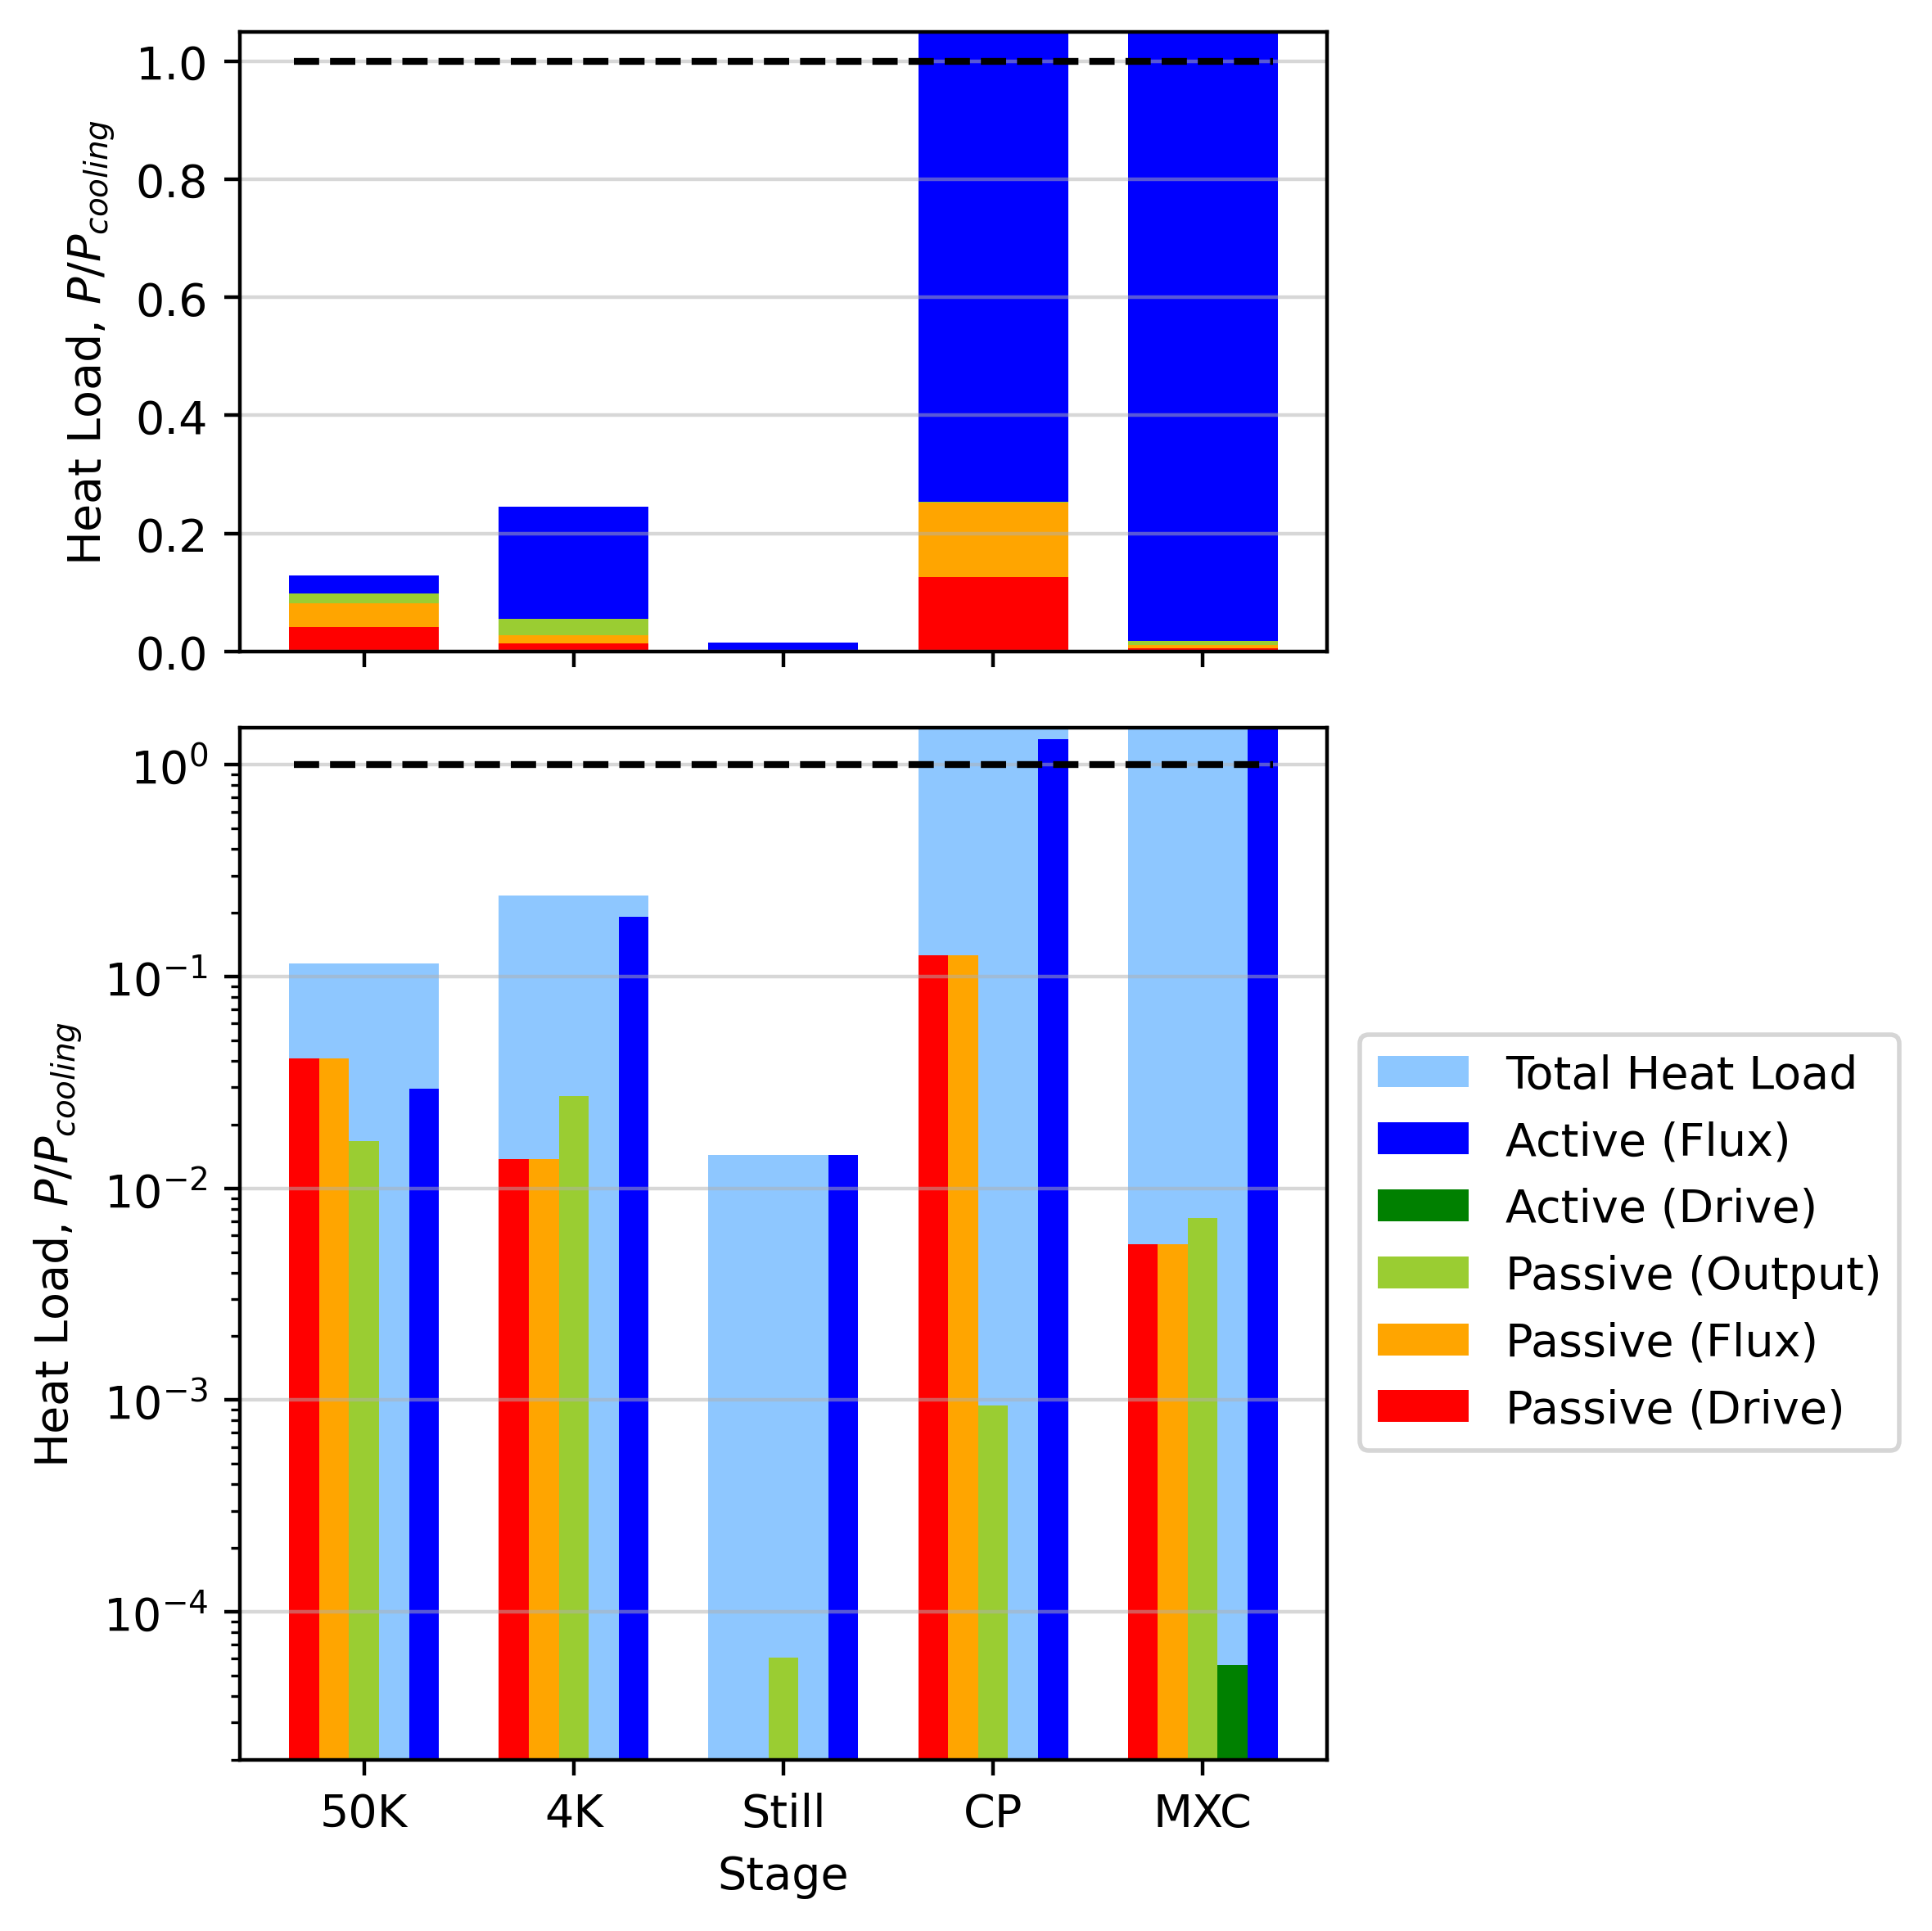

In [13]:
fig = plt.figure(figsize=(6, 6), tight_layout=True)

heights = [0.6, 1]
gs = fig.add_gridspec(2, 1, height_ratios=heights)

axs = [fig.add_subplot(gs[row, 0]) for row in range(2)]

# fig, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 4))

colour = ['red', 'orange', 'yellowgreen', 'green', 'blue']
tmps_str = ['', '3.26K', '1.23K', '93mK', '14.6mK']

for i in range(5):
    bot=0
    for ii in range(5):
        val = load_data[1].iloc[ii, i]
        axs[0].bar(i*1.75, val, width=1.25, bottom=bot, color=colour[ii])
        bot += val
    # axs[0].annotate(tmps_str[i], (i*1.75, bot+0.1), ha='center', va='center')

#stage
for i in range(5):
    axs[1].bar(0.5+i*1.75, load_data[0].iloc[:, i].sum(), width=1.25, color='dodgerblue', alpha=0.5)
    #load_type
    for ii in range(5):
        val = load_data[1].iloc[ii, i]
        axs[1].bar(i*1.75 + ii*0.25, val, width=0.25, color=colour[ii])

axs[1].set_yscale('log')
axs[0].set_ylim(0, 1.05)
axs[1].set_ylim(2e-5, 1.5)

axs[0].set_xticks([i*1.75 for i in range(5)])
axs[1].set_xticks([0.5+i*1.75 for i in range(5)])

axs[0].set_xticklabels([])
axs[1].set_xticklabels(fridge_ours['labels'])
axs[1].set_xlabel('Stage')
axs[0].set_ylabel('Heat Load, ' + r'$P/P_{cooling}$')
axs[1].set_ylabel('Heat Load, ' + r'$P/P_{cooling}$')
axs[0].grid(True, 'major', 'y', alpha=0.5)
axs[1].grid(True, 'major', 'y', alpha=0.5)

axs[0].axhline(1, 0.05, 0.95, linestyle='dashed', color='k')
axs[1].axhline(1, 0.05, 0.95, linestyle='dashed', color='k')

l=axs[1].legend([1, 2, 3, 4, 5, 6, 7])
axs[1].legend(handles=[l.legendHandles[i] for i in [1, 6, 5, 4, 3, 2]], labels=['Total Heat Load']+['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'][::-1], loc=(1.03, 0.3))

plt.tight_layout()

# plt.savefig('21.10.27/FinalHeatLoads.png', dpi=400)

plt.show()

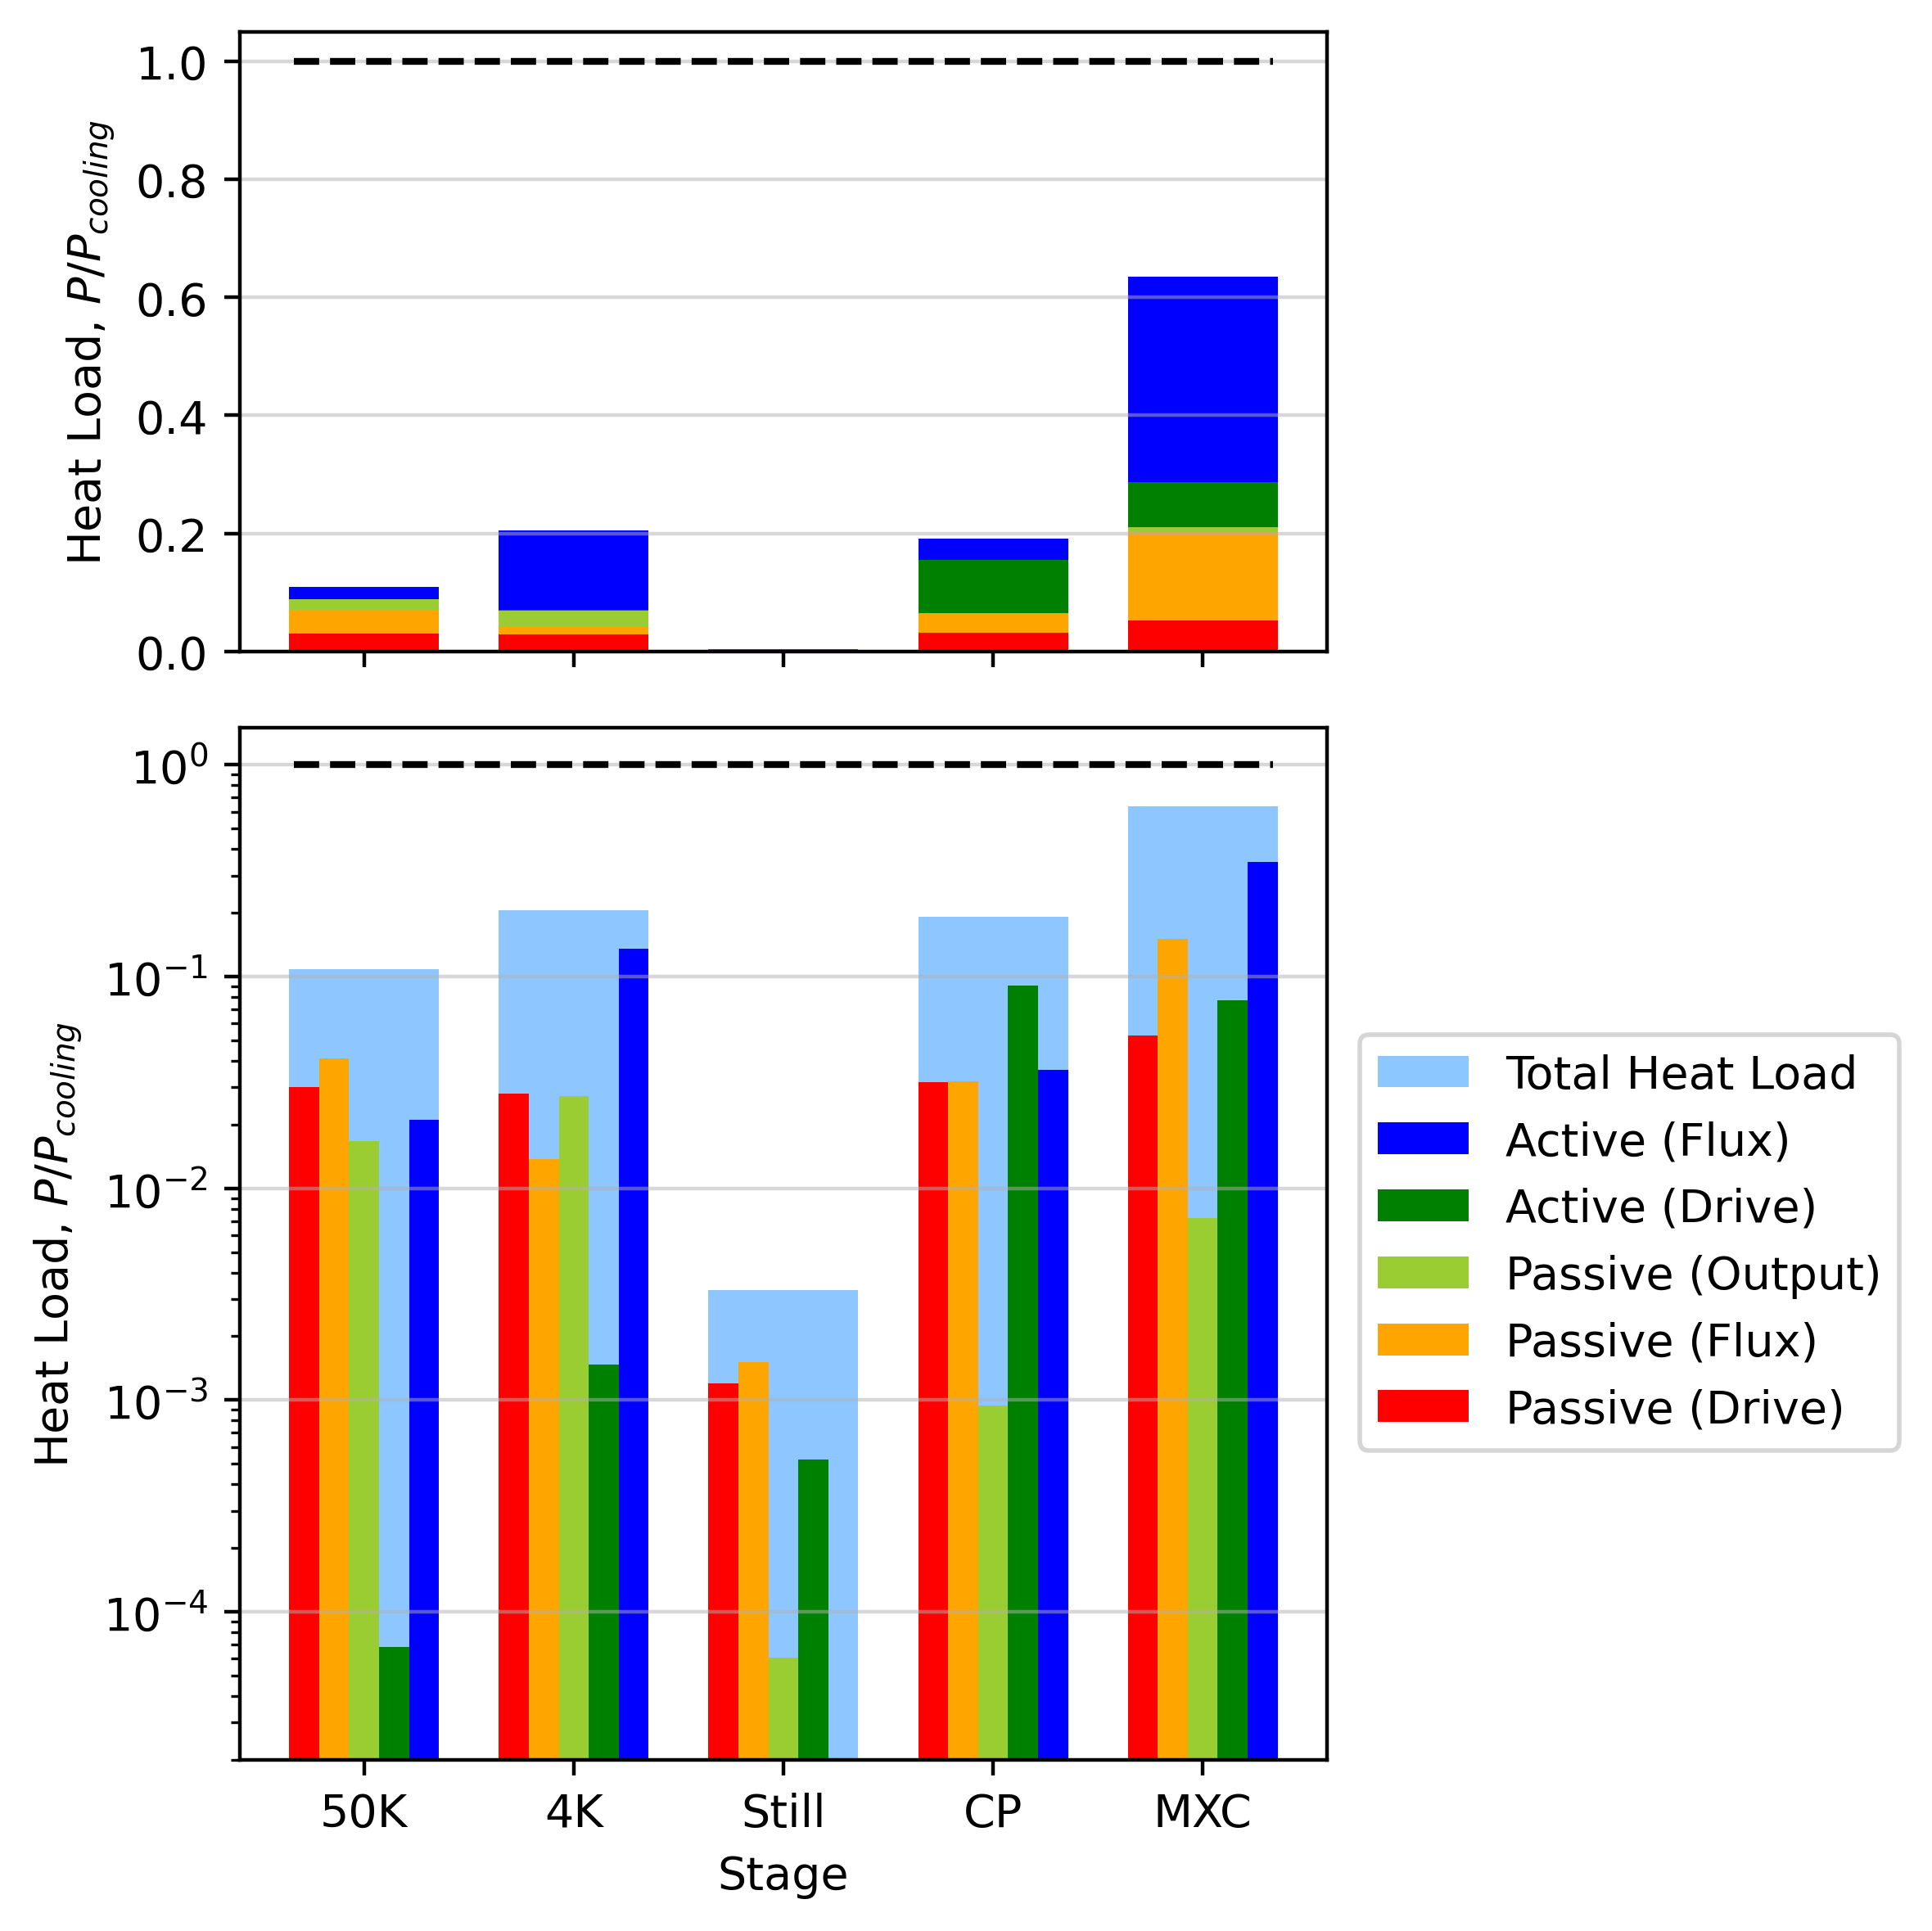

In [7]:
#0dB
fig = plt.figure(figsize=(6, 6), tight_layout=True)

heights = [0.6, 1]
gs = fig.add_gridspec(2, 1, height_ratios=heights)

axs = [fig.add_subplot(gs[row, 0]) for row in range(2)]

# fig, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 4))

colour = ['red', 'orange', 'yellowgreen', 'green', 'blue']
tmps_str = ['', '3.26K', '1.23K', '93mK', '14.6mK']

for i in range(5):
    bot=0
    for ii in range(5):
        val = load_data[1].iloc[ii, i]
        axs[0].bar(i*1.75, val, width=1.25, bottom=bot, color=colour[ii])
        bot += val
    # axs[0].annotate(tmps_str[i], (i*1.75, bot+0.1), ha='center', va='center')

#stage
for i in range(5):
    axs[1].bar(0.5+i*1.75, load_data[1].iloc[:, i].sum(), width=1.25, color='dodgerblue', alpha=0.5)
    #load_type
    for ii in range(5):
        val = load_data[1].iloc[ii, i]
        axs[1].bar(i*1.75 + ii*0.25, val, width=0.25, color=colour[ii])

axs[1].set_yscale('log')
axs[0].set_ylim(0, 1.05)
axs[1].set_ylim(2e-5, 1.5)

axs[0].set_xticks([i*1.75 for i in range(5)])
axs[1].set_xticks([0.5+i*1.75 for i in range(5)])

axs[0].set_xticklabels([])
axs[1].set_xticklabels(fridge_ours['labels'])
axs[1].set_xlabel('Stage')
axs[0].set_ylabel('Heat Load, ' + r'$P/P_{cooling}$')
axs[1].set_ylabel('Heat Load, ' + r'$P/P_{cooling}$')
axs[0].grid(True, 'major', 'y', alpha=0.5)
axs[1].grid(True, 'major', 'y', alpha=0.5)

axs[0].axhline(1, 0.05, 0.95, linestyle='dashed', color='k')
axs[1].axhline(1, 0.05, 0.95, linestyle='dashed', color='k')

l=axs[1].legend([1, 2, 3, 4, 5, 6, 7])
axs[1].legend(handles=[l.legendHandles[i] for i in [1, 6, 5, 4, 3, 2]], labels=['Total Heat Load']+['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'][::-1], loc=(1.03, 0.3))

plt.tight_layout()

# plt.savefig('21.10.27/FinalHeatLoads.png', dpi=400)

plt.show()

In [9]:
## AIP Congress
fig, axs = plt.subplots(figsize=(4, 3), tight_layout=True)

# heights = [0.6, 1]
# gs = fig.add_gridspec(2, 1, height_ratios=heights)

# axs = [fig.add_subplot(gs[row, 0]) for row in range(2)]

# fig, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 4))

colour = ['red', 'orange', 'yellowgreen', 'green', 'blue']
tmps_str = ['42.3K', '3.26K', '1.23K', '93mK', '14.6mK']

for i in range(5):
    bot=0
    for ii in range(5):
        val = load_data[1].iloc[ii, i]
        axs.bar(i*1.75, val, width=1.25, bottom=bot, color=colour[ii])
        bot += val
    axs.annotate(tmps_str[i], (i*1.75, bot+0.07), ha='center', va='center')

# #stage
# for i in range(5):
#     axs[1].bar(0.5+i*1.75, load_data[0].iloc[:, i].sum(), width=1.25, color='dodgerblue', alpha=0.5)
#     #load_type
#     for ii in range(5):
#         val = load_data[1].iloc[ii, i]
#         axs[1].bar(i*1.75 + ii*0.25, val, width=0.25, color=colour[ii])

# axs[1].set_yscale('log')
axs.set_ylim(0, 1.05)
# axs[1].set_ylim(2e-5, 1.5)

axs.set_xticks([i*1.75 for i in range(5)])
# axs[1].set_xticks([0.5+i*1.75 for i in range(5)])

axs.set_xticklabels([])
axs.set_xticklabels(fridge_ours['labels'])
axs.set_xlabel('Stage')
axs.set_ylabel('Heat Load, ' + r'$P/P_{cooling}$')
# axs[1].set_ylabel('Heat Load, ' + r'$P/P_{cooling}$')
axs.grid(True, 'major', 'y', alpha=0.5)
# axs[1].grid(True, 'major', 'y', alpha=0.5)

axs.axhline(1, 0.05, 0.95, linestyle='dashed', color='k')
# axs[1].axhline(1, 0.05, 0.95, linestyle='dashed', color='k')

l=axs.legend([1, 2, 3, 4, 5, 6])
axs.legend(handles=[l.legendHandles[i] for i in [5, 4, 3, 2, 1]], labels=['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'][::-1], loc=(0.03, 0.33))

plt.tight_layout(True)

plt.savefig('AIPCongressHeat.png', dpi=400)

plt.show()

In [48]:
load_data[1].sum(axis=0)

50K      0.108762
4K       0.205646
Still    0.003296
CP       0.191244
MXC      0.635374
dtype: float64

## MXC Heat Load vs. Temp and Noise

In [2]:
x_data = [0, 10, 20, 30]
y_data = [7, 14.4, 19.2, 23.1]
def f(y, a, b, c):
    return (y-c)**2/a**2 + b
def finv(x, a, b, c):
    return a*np.sqrt(x-b) + c
opts, scrap = curve_fit(f, y_data, x_data)

h = 6.626e-34
k_B = 1.381e-23
n_drive = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )

In [12]:
c_p = np.linspace(0, 100)
T = finv(c_p, *opts)
n_data = n_drive(T*10**-3, 6e9)

fig, axs = plt.subplots(figsize=(5, 5))

axs.plot(c_p, n_data, c='b')
axs2 = axs.twinx()
axs2.plot(c_p, T, c='r')
axs.set_yscale('log')

axstop = axs.twiny()
axstop.set_xlim(axs.get_xlim())
axs.set_xticks([20*i for i in range(6)])
axstop.set_xticks([20*i for i in range(6)])
axs.set_xticklabels([1*i for i in range(6)])
# axstop.set_xticklabels([20*i for i in range(6)])

axstop.set_xlabel(r'Heat Load on MXC ($\mu W$)')
axs.set_xlabel(r'Heat Load on MXC, $P/P_{cooling}$')
axs.set_ylabel('Noise Photons by Att. at MXC,\n'+r'$(s^{-1}Hz^{-1})$')
axs2.set_ylabel('Temperature (mK)')

axs2.arrow(30, 37, -4, 0, width=0.5, color='b')
axs2.arrow(20, 17, 4, 0, width=0.5, color='r')
axs.set_title('Temperature and Noise on MXC\nvs. Heat Load')

plt.tight_layout(True)
plt.savefig('21.10.27/MXC Temp plot.png', dpi=400)

plt.show()

In [6]:
c_p = np.linspace(0, 100)
T = finv(c_p, *opts)
n_data = n_drive(T*10**-3, 6e9)

fig, axs = plt.subplots(figsize=(5, 5))

axs.plot(c_p, T, c='b')
axs2 = axs.twinx()
axs2.plot(c_p, n_data, c='r')
axs2.set_yscale('log')

axstop = axs.twiny()
axstop.set_xlim(axs.get_xlim())
axs.set_xticks([20*i for i in range(6)])
axstop.set_xticks([20*i for i in range(6)])
axs.set_xticklabels([1*i for i in range(6)])
# axstop.set_xticklabels([20*i for i in range(6)])

axstop.set_xlabel(r'Heat Load on MXC ($\mu W$)')
axs.set_xlabel(r'Heat Load on MXC, $P/P_{cooling}$')
axs.set_ylabel('Temperature (mK)')
axs2.set_ylabel('Noise Photons by Att. at MXC,\n'+r'$(s^{-1}Hz^{-1})$')

axs.arrow(25, 32, 4, 0, width=0.5, color='r')
axs.arrow(20, 22, -4, 0, width=0.5, color='b')
axs.set_title('Temperature and Noise on MXC\nvs. Heat Load')

plt.tight_layout(True)
# plt.savefig('21.10.19/MXC Temp plot.png', dpi=400)

plt.show()

In [22]:
T*10**-6

array([7.00654883e-06, 8.97087609e-06, 1.06044208e-05, 1.20331834e-05,
       1.33190505e-05, 1.44978743e-05, 1.55926305e-05, 1.66190905e-05,
       1.75886359e-05, 1.85097995e-05, 1.93891739e-05, 2.02319778e-05,
       2.10424265e-05, 2.18239830e-05, 2.25795330e-05, 2.33115120e-05,
       2.40219973e-05, 2.47127780e-05, 2.53854080e-05, 2.60412469e-05,
       2.66814928e-05, 2.73072077e-05, 2.79193383e-05, 2.85187327e-05,
       2.91061541e-05, 2.96822928e-05, 3.02477748e-05, 3.08031706e-05,
       3.13490012e-05, 3.18857446e-05, 3.24138399e-05, 3.29336923e-05,
       3.34456761e-05, 3.39501381e-05, 3.44474004e-05, 3.49377627e-05,
       3.54215046e-05, 3.58988871e-05, 3.63701547e-05, 3.68355365e-05,
       3.72952477e-05, 3.77494905e-05, 3.81984558e-05, 3.86423231e-05,
       3.90812625e-05, 3.95154343e-05, 3.99449907e-05, 4.03700759e-05,
       4.07908266e-05, 4.12073727e-05])

## MXC Cooling Power vs Still Temperature

In [2]:
y_data = [0, 10, 20, 30]
x_data1 = [7, 16.6, 22.9, 27.7]
x_data2 = [7, 15, 20.3, 24.3]
x_data3 = [7, 14.4, 19.2, 23.1]

x_data = [x_data1, x_data2, x_data3]

StillT = [962, 1130, 1230] 

# def f(y, a, b, c):
#     return (y-c)**2/a**2 + b
# def finv(x, a, b, c):
#     return a*np.sqrt(x-b) + c

def f(x, a, b, c):
    return a*x**2+b*x+c

opts = [curve_fit(f, x, y_data)[0] for x in x_data]

P = [f(20, *o) for o in opts]


In [3]:
opts

[array([ 0.03750155,  0.14400645, -2.82438507]),
 array([ 0.0534168 ,  0.05633282, -2.98564477]),
 array([ 0.05847308,  0.10468985, -3.60405884])]

In [3]:
fig, axs = plt.subplots(figsize=(5, 5))

axs.scatter(StillT, P, c='r', marker='x')

axs.set_xlim(950, 1250)
axs.set_xlabel('Still Temperature (mK)')
axs.set_ylabel('MXC Cooling Power at 20mK, '+r'$P_{MXC}$ ($\mu$W)')
axs.set_title('MXC Cooling Power vs. Still Temperature')

plt.savefig('21.10.19/PMXCvsStill.png', dpi=400)

plt.show()

In [2]:
active_load_DC(i_in=20e-3, 
                stage_labels=fridge_ours['labels'], 
                att=[0, 20, 0, 0, 0], 
                cable_rho=coax_co_params['119-NbTi-NbTi']['rho'], 
                lengths=fridge_ours['lengths'], 
                diameters=coax_co_params['119-NbTi-NbTi']['d'])

50K      0.0000
4K       0.0198
Still    0.0000
CP       0.0000
MXC      0.0000
Name: Active Power (W), dtype: float64

## Flux Att Table

In [16]:
S_eff = lambda t: 4 * k_B * t / 50

T = [300] + [fridge_ours['temps'][0]]
I = [S_eff(t) for t in T]
target = S_eff(4)/2
att = [10*np.log10(i/target) for i in I]

pd.DataFrame(
    {
        'Temperature': T,
        'Noise Current': I,
        'Target': [target]*2,
        'att. required':att
    },
    index=['RT', '50K']
)

,Temperature,Noise Current,Target,att. required
RT,300,3.314400e-22,2.209600e-24,21.760913
50K,46,5.082080e-23,2.209600e-24,13.617278


## Noise Power across fridge for qubit frequency range

In [7]:
h = 6.626e-34
k_B = 1.381e-23
P = lambda T, f: h*f / ( np.exp( h*f / (k_B*T) ) - 1 )

f = np.linspace(0.2e9, 40e9, 10000)
df = f[1] - f[0]

# np.sum(P(0.100, f)*df)*14, np.sum(P(0.150, f)*df)*14

A = [0, 20, 0, 20, 20]
temps = [300, 50, 4, 1.2, 0.1, 0.02]

# p_data = P(300, f)
# for i in range(5): p_data = p_data * 10**(-A[i]/10) + (1 - 10**(-A[i]/10)) * P(temps[i], f)
# np.sum(p_data

n_p = [10*np.log(np.sum(P(t, f)*df)/1e-3) for t in temps]
pd.DataFrame(
    {
        'Temperature': temps,
        'Noise Power (dBm)': n_p
    },
    index=['RT'] + fridge_ours['labels']
)

,Temperature,Noise Power (dBm)
RT,300.00,-156.194862
50K,50.00,-174.192874
4K,4.00,-200.565596
Still,1.20,-215.430608
CP,0.10,-261.341728
MXC,0.02,-295.911039


In [11]:
h = 6.626e-34
k_B = 1.381e-23
P = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )

f = np.linspace(1e9, 10e9, 10000)
df = f[1] - f[0]

# np.sum(P(0.100, f)*df)*14, np.sum(P(0.150, f)*df)*14

A = [0, 20, 0, 20, 20]
temps = [300, 50, 4, 1.2, 0.1, 0.02]

# p_data = P(300, f)
# for i in range(5): p_data = p_data * 10**(-A[i]/10) + (1 - 10**(-A[i]/10)) * P(temps[i], f)
# np.sum(p_data

n_p = [np.sum(P(t, f)*df) for t in temps]
pd.DataFrame(
    {
        'Temperature': temps,
        'Noise Power (dBm)': n_p
    },
    index=['RT'] + fridge_ours['labels']
)

,Temperature,Noise Power (dBm)
RT,300.00,1.439583e+13
50K,50.00,2.395559e+12
4K,4.00,1.875535e+11
Still,1.20,5.326561e+10
CP,0.10,1.994152e+09
MXC,0.02,3.972888e+07


In [77]:
h = 6.626e-34
k_B = 1.381e-23
c = 3e8
P = lambda T, f: h*f**3/c*2 / ( np.exp( h*f / (k_B*T) ) - 1 )

f = np.linspace(0.2e9, 10e9, 100000)
df = f[1] - f[0]

temps = [300, 50, 4, 1.2, 0.1, 0.02]
n_p = [np.sum(P(t, f)*df) for t in temps]

n_p

[9.20120781073164,
 1.528940025445437,
 0.11732290114304476,
 0.03159895274005142,
 0.0003935355273539151,
 8.619983469209742e-07]

## Different Cooling Powers

In [2]:
data = pd.read_excel('CoolingMatrix.xlsx')
data

,Power at 50K (W),Power at 4K (mW),Power at Still (mW),Power at MXC (µW),Power at CP (µW),Flow (µMoll),T at 4K (K),"T at Still, (mK)",T MXC (mK),T at cold plate\n(mK),comments
0,0.0,100.0,10.0,0.0,0.0,664.0,3.29,962.0,7.0,69.0,NaN
1,NaN,100.0,10.0,10.0,0.0,722.0,3.29,963.0,16.6,71.0,NaN
2,NaN,100.0,10.0,20.0,0.0,738.0,3.29,964.0,22.9,72.0,NaN
3,NaN,100.0,10.0,30.0,0.0,668.0,3.29,964.0,27.7,74.0,NaN
4,NaN,100.0,20.0,0.0,0.0,964.0,3.39,1130.0,7.0,77.0,NaN
5,NaN,100.0,20.0,10.0,0.0,890.0,3.39,1130.0,15.0,78.0,NaN
6,NaN,100.0,20.0,20.0,0.0,989.0,3.39,1130.0,20.3,79.0,NaN
7,NaN,100.0,20.0,30.0,0.0,938.0,3.39,1130.0,24.3,80.0,NaN
8,NaN,100.0,30.0,0.0,0.0,1180.0,3.46,1230.0,7.0,82.0,NaN
9,NaN,100.0,30.0,10.0,0.0,1090.0,3.46,1230.0,14.4,82.0,NaN


In [25]:
len(data_2.columns)

11

In [3]:
valid = np.where(data.iloc[:36, 2] == 30)[0]
data_2 = data.iloc[valid, :]
new_row = pd.Series(
    [np.nan, 300.,30.,0.,300.,np.nan,np.nan,np.nan, np.nan, np.nan, np.nan],
    index=data_2.columns
)
data_2 = data_2.append(new_row, ignore_index=True)
# new_row = pd.Series(
#     [np.nan, 300.,30.,0.,300.,np.nan,np.nan,np.nan, np.nan, np.nan, np.nan],
#     index=data_2.columns
# )
data_2

,Power at 50K (W),Power at 4K (mW),Power at Still (mW),Power at MXC (µW),Power at CP (µW),Flow (µMoll),T at 4K (K),"T at Still, (mK)",T MXC (mK),T at cold plate\n(mK),comments
0,NaN,100.0,30.0,0.0,0.0,1180.0,3.46,1230.0,7.0,82.0,NaN
1,NaN,100.0,30.0,10.0,0.0,1090.0,3.46,1230.0,14.4,82.0,NaN
2,NaN,100.0,30.0,20.0,0.0,1040.0,3.46,1230.0,19.2,83.0,NaN
3,NaN,100.0,30.0,30.0,0.0,1190.0,3.46,1230.0,23.1,84.0,NaN
4,NaN,100.0,30.0,0.0,300.0,1160.0,3.46,1230.0,7.0,148.0,NaN
5,NaN,100.0,30.0,10.0,300.0,1030.0,3.46,1230.0,14.6,148.0,NaN
6,NaN,100.0,30.0,20.0,300.0,1180.0,3.46,1230.0,19.3,148.0,NaN
7,NaN,100.0,30.0,30.0,300.0,1120.0,3.45,1230.0,23.1,148.0,NaN
8,NaN,300.0,30.0,0.0,0.0,1100.0,3.78,1230.0,7.0,83.0,NaN
9,NaN,300.0,30.0,10.0,0.0,1230.0,3.78,1230.0,14.4,84.0,NaN


In [4]:
def pair(s1, s2):
    #extract the relationship between the heat load on one stage and its temperature for different heat loads on the second stage
    s = [1, 3, 4]
    s.remove(s1)
    s.remove(s2)
    Ptemp = data_2.iloc[:, s[0]].unique()
    w = np.where(data_2.iloc[:, s[0]] == Ptemp[0])[0]
    data_temp = data_2.iloc[w, :]

    P1 = data_2.iloc[:, s1].unique()
    P2 = data_2.iloc[:, s2].unique()

    T = []
    for v in P2:
        w = np.where(data_temp.iloc[:, s2] == v)[0]
        T.append(data_temp.iloc[w, s1+5])

    return P1, P2, T

In [30]:
pair(4, 1)

(array([  0., 300.]),
 array([100., 300.]),
 [0     82.0
  4    148.0
  Name: T at cold plate\n(mK), dtype: float64,
  8     83.0
  12     NaN
  Name: T at cold plate\n(mK), dtype: float64])

In [44]:
str(P2[iii])

'300.0'

In [64]:
display(r'($\mu$ W)')

'(\\mu W)'

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))

labels = ['4K', 'CP', 'MXC']
unitsP = ['(mW)', r'($\mu$W)', r'($\mu$W)']
unitsT = ['(K)', '(mK)', '(mK)']
ind = [1, 4, 3]
# c_p = [500, 20, 300]

for i in range(3):
    axs[i, i].spines['right'].set_visible(False)
    axs[i, i].spines['left'].set_visible(False)
    axs[i, i].spines['top'].set_visible(False)
    axs[i, i].spines['bottom'].set_visible(False)
    axs[i, i].set_xticks([])
    axs[i, i].set_yticks([])
    for ii in range(3):
        if ii == i: continue
        P1, P2, T = pair(ind[i], ind[ii])
        for iii in range(len(P2)):
            axs[ii, i].scatter(P1, T[iii])
            axs[ii, i].plot(P1, T[iii])
        axs[ii, i].legend([r'$P_\mathrm{'+labels[ii]+r'}=$'+"{:.0f} ".format(p) + unitsP[ii][1:-1] for p in P2], fontsize=9)
        axs[ii, i].set_xlabel('Heat Load on ' + labels[i] + ' ' + unitsP[i])
        axs[ii, i].set_ylabel(labels[i] + 'Temperature ' + unitsT[i])

# axs[0, 0].set_ylabel('Heat Load')

for n, ax in enumerate([axs[1, 0], axs[2, 0], axs[0, 1], axs[2, 1], axs[0, 2], axs[1, 2]]):
    ax.text(-0.1, 1.05, string.ascii_lowercase[n]+')', 
    transform=ax.transAxes, 
    size=12, weight='bold')

fig.tight_layout()

plt.savefig('21.11.03/HeatCorrelations.png', dpi=400)

## Different Cooling Powers Regression

In [2]:
data = pd.read_excel('CoolingMatrix.xlsx')
data

,Power at 50K (W),Power at 4K (mW),Power at Still (mW),Power at MXC (µW),Power at CP (µW),Flow (µMoll),T at 4K (K),"T at Still, (mK)",T MXC (mK),T at cold plate\n(mK),comments
0,0.0,100.0,10.0,0.0,0.0,664.0,3.29,962.0,7.0,69.0,NaN
1,NaN,100.0,10.0,10.0,0.0,722.0,3.29,963.0,16.6,71.0,NaN
2,NaN,100.0,10.0,20.0,0.0,738.0,3.29,964.0,22.9,72.0,NaN
3,NaN,100.0,10.0,30.0,0.0,668.0,3.29,964.0,27.7,74.0,NaN
4,NaN,100.0,20.0,0.0,0.0,964.0,3.39,1130.0,7.0,77.0,NaN
5,NaN,100.0,20.0,10.0,0.0,890.0,3.39,1130.0,15.0,78.0,NaN
6,NaN,100.0,20.0,20.0,0.0,989.0,3.39,1130.0,20.3,79.0,NaN
7,NaN,100.0,20.0,30.0,0.0,938.0,3.39,1130.0,24.3,80.0,NaN
8,NaN,100.0,30.0,0.0,0.0,1180.0,3.46,1230.0,7.0,82.0,NaN
9,NaN,100.0,30.0,10.0,0.0,1090.0,3.46,1230.0,14.4,82.0,NaN


In [34]:
def f(x, a1, a2, b1, b2, c1, c2, d1, d2):
    return a1*np.sqrt(x[0]-a2) + b1*np.sqrt(x[1]-b2) + c1*np.sqrt(x[2]-c2) + d1*np.sqrt(x[3]-d2)

# def f(x, a, b, c, d, e):
#     a*np.sqrt()

X = data.iloc[:36, 1:5].T
temp1, temp2 = X.iloc[2, :].copy(), X.iloc[3, :].copy()
X.iloc[2, :] = temp2
X.iloc[3, :] = temp1
# X.index = X.index[[0, 1, 3, 2]]
X = X.to_numpy()
Y = [data.iloc[:36, i].to_list() for i in [6, 7, 9, 8]]

# popts = [curve_fit(f, X, y, maxfev=20000000)[0] for y in Y]
popts = curve_fit(f, X, Y[1], maxfev=20000000)[0]

C:\Users\Adrien\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


KeyboardInterrupt: 

In [29]:
X

,Power at 4K (mW),Power at MXC (µW),Power at CP (µW)
8,100.0,0.0,0.0
9,100.0,10.0,0.0
10,100.0,20.0,0.0
11,100.0,30.0,0.0
20,100.0,0.0,300.0
21,100.0,10.0,300.0
22,100.0,20.0,300.0
23,100.0,30.0,300.0
32,300.0,0.0,0.0
33,300.0,10.0,0.0


In [31]:
X

,8,9,10,11,20,21,22,23,32,33,34,35
Power at 4K (mW),100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,300.0,300.0,300.0,300.0
Power at MXC (µW),0.0,10.0,20.0,30.0,0.0,10.0,20.0,30.0,0.0,10.0,20.0,30.0
Power at CP (µW),0.0,0.0,0.0,0.0,300.0,300.0,300.0,300.0,0.0,0.0,0.0,0.0


In [33]:
def f(x, a1, a2, b1, b2, c1, c2):
    return a1*np.sqrt(x[0]-a2) + b1*np.sqrt(x[1]-b2) + c1*np.sqrt(x[2]-c2)

valid = np.where(data.iloc[:36, 2] == 30)[0]
X = data.iloc[valid, [1, 3, 4]].T.to_numpy()
Y = [data.iloc[valid, i].to_list() for i in [6, 9, 8]]

popts = curve_fit(f, X, Y[0], maxfev=10000000)[0]

C:\Users\Adrien\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000000.

In [ ]:
def f(x, a1, a2, b1, b2, c1, c2, d1, d2):
    return a1*np.sqrt(x[0]-a2) + b1*np.sqrt(x[1]-b2) + c1*np.sqrt(x[2]-c2)

# def f(x, a, b, c, d, e):
#     a*np.sqrt()

X = data.iloc[:36, 1:5].T
temp1, temp2 = X.iloc[2, :].copy(), X.iloc[3, :].copy()
X.iloc[2, :] = temp2
X.iloc[3, :] = temp1
# X.index = X.index[[0, 1, 3, 2]]
X = X.to_numpy()
Y = [data.iloc[:36, i].to_list() for i in [6, 7, 9, 8]]

X = data.iloc[:36, [1, 3, 4]].T

# popts = [curve_fit(f, X, y, maxfev=20000000)[0] for y in Y]
# popts = curve_fit(f, X, Y[0], maxfev=20000000)[0]

In [7]:
data.iloc[:36, 2][data.iloc[:36, 2] == 30].count()

12

In [5]:
y = [1,2,3,4,3,4,5,3,5,5,4,5,4,5,4,5,6,0,6,3,1,3,1] 
X = [[0,2,4,1,5,4,5,9,9,9,3,7,8,8,6,6,5,5,5,6,6,5,5],
     [4,1,2,3,4,5,6,7,5,8,7,8,7,8,7,8,6,8,9,2,1,5,6],
     [4,1,2,5,6,7,8,9,7,8,7,8,7,4,3,1,2,3,4,1,3,9,7]]
X = np.transpose(X) # transpose so input vectors
X = np.c_[X, np.ones(X.shape[0])]  # add bias term
np.linalg.lstsq(X, y, rcond=None)[0]

array([ 0.1338682 ,  0.26840334, -0.02874936,  1.5122571 ])

In [8]:
def function_calc(x, a, b, c, d):
    return a*x[0] + b*x[1] + c*x[2] + d
Y = [1,2,3,4,3,4,5,3,5,5,4,5,4,5,4,5,6,0,6,3,1,3,1] 
X = [[0,2,4,1,5,4,5,9,9,9,3,7,8,8,6,6,5,5,5,6,6,5,5],
     [4,1,2,3,4,5,6,7,5,8,7,8,7,8,7,8,6,8,9,2,1,5,6],
     [4,1,2,5,6,7,8,9,7,8,7,8,7,4,3,1,2,3,4,1,3,9,7]]

popt, pcov = curve_fit(function_calc, X, Y)
popt

array([ 0.1338682 ,  0.26840334, -0.02874936,  1.5122571 ])

In [4]:
X

array([[0., 4., 4., 1.],
       [2., 1., 1., 1.],
       [4., 2., 2., 1.],
       [1., 3., 5., 1.],
       [5., 4., 6., 1.],
       [4., 5., 7., 1.],
       [5., 6., 8., 1.],
       [9., 7., 9., 1.],
       [9., 5., 7., 1.],
       [9., 8., 8., 1.],
       [3., 7., 7., 1.],
       [7., 8., 8., 1.],
       [8., 7., 7., 1.],
       [8., 8., 4., 1.],
       [6., 7., 3., 1.],
       [6., 8., 1., 1.],
       [5., 6., 2., 1.],
       [5., 8., 3., 1.],
       [5., 9., 4., 1.],
       [6., 2., 1., 1.],
       [6., 1., 3., 1.],
       [5., 5., 9., 1.],
       [5., 6., 7., 1.]])